In [ ]:
import keras
from keras.datasets import mnist, cifar10
from keras.models import Sequential
from keras.layers import LeakyReLU, Dense, Dropout, Flatten, BatchNormalization, Activation, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras import backend as K
import numpy as np
from datetime import datetime
from keras.utils import np_utils
from keras.utils import plot_model
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # Draw grid on plot

Using TensorFlow backend.


In [ ]:
# Following is for data preprocessing
MLPGAN_SIGMOID = 1
MLPGAN_TANH = 2
DCGAN_SIGMOID = 3
DCGAN_TANH = 4

class GAN():

  def __init__(self,G,D):
    self.G = G
    self.D = D
    self.AM = None # adversarial net
    self.X_train = None
    self.img_rows = None
    self.img_cols = None
    self.img_channels = None
    self.mode = None # how to preprocess data

  """
   It constructs adversarial network and sets how to train adversarial net and D net
  """
  def build(self):
    optimizer = RMSprop(lr=0.0002, decay=6e-8)
    self.D.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    optimizer = RMSprop(lr=0.0001, decay=3e-8)
    self.D.trainable = False # it doesn't affect D net, becasue it's already compiled
    self.AM = Sequential()
    self.AM.add(self.G)
    self.AM.add(self.D)
    self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,
        metrics=['accuracy'])
    self.AM.summary()

  def train(self, train_steps=2000, batch_size=256, save_interval=0):
    noise_input = None

    if save_interval>0:
        noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    for i in range(train_steps):
        images_train = self.X_train[np.random.randint(0, self.X_train.shape[0], size=batch_size), :, :, :]
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
        images_fake = self.G.predict(noise)

        if self.mode == MLPGAN_SIGMOID or self.mode ==MLPGAN_TANH : images_fake = images_fake.reshape(batch_size, self.img_rows, self.img_cols, self.img_channels)

        X = np.concatenate((images_train, images_fake))
        Y = np.ones([2*batch_size, 1])
        Y[batch_size:, :] = 0

        if self.mode == MLPGAN_SIGMOID or self.mode == MLPGAN_TANH : X = X.reshape(2*batch_size,self.img_rows * self.img_cols)

        d_loss = self.D.train_on_batch(X, Y)

        Y = np.ones([batch_size, 1])
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
        a_loss = self.AM.train_on_batch(noise, Y)
        
        if save_interval>0:
            if (i+1)%save_interval==0:
                self.plot_images(samples=noise_input.shape[0], noise=noise_input, step=(i+1))
                log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
                log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
                print(log_mesg)
  
  
  def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
    filename = 'mnist.png'
    if fake:
        if noise is None:
            noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
        else:
            filename = "mnist_%d.png" % step
        images = self.G.predict(noise)
        if self.mode == MLPGAN_SIGMOID or self.mode == MLPGAN_TANH : images = images.reshape(samples, self.img_rows, self.img_cols, self.img_channels)
    else:
        i = np.random.randint(0, self.X_train.shape[0], samples)
        images = self.X_train[i, :, :, :]

    plt.figure(figsize=(10,10))
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]

        if self.img_channels == 1: image = np.reshape(image, [self.img_rows, self.img_cols])

        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    if save2file:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()
  
  def load_dataset(self, dataset = 'mnist'):
    if dataset == 'mnist':
      (self.X_train, _), (_, _) = mnist.load_data()
      self.X_train = self.X_train.reshape(60000,28,28,1)
    elif dataset == 'cifar10':
      (self.X_train, _), (_, _) = mnist.load_data()

    self.X_train = self.X_train.astype('float32')
    self.img_rows = self.X_train.shape[1]
    self.img_cols = self.X_train.shape[2]
    self.img_channels = self.X_train.shape[3]

  def preprocess_data(self, mode = 0):
    self.mode = mode
    if self.mode == MLPGAN_SIGMOID or self.mode == DCGAN_SIGMOID:
      self.X_train /= 255
    
    elif self.mode == MLPGAN_TANH or self.mode == DCGAN_TANH:
      self.X_train = (self.X_train - 127.5)/127.5

# 1. GAN implemented with MLP
1. G which uses sigmoid at last layer
2. G which uses tanh at last layer

In [ ]:
K.clear_session()
dropout = 0.4
z = 100

G = Sequential()
G.add(Dense(256, input_dim = z))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))
G.add(Dropout(dropout))

G.add(Dense(512))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))
G.add(Dropout(dropout))

G.add(Dense(784, activation = 'sigmoid'))
G.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      


In [ ]:
D = Sequential()

D.add(Dense(512, input_dim=784, activation = 'relu'))
D.add(Dropout(dropout))

D.add(Dense(256, activation = 'relu'))
D.add(Dropout(dropout))

D.add(Dense(100, activation = 'relu'))
D.add(Dropout(dropout))

D.add(Dense(1, activation = 'sigmoid'))
D.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               25700     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [ ]:
model = GAN(G,D)
model.load_dataset()
model.preprocess_data(mode = MLPGAN_SIGMOID)
model.build()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 784)               562704    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 559049    
Total params: 1,121,753
Trainable params: 561,168
Non-trainable params: 560,585
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


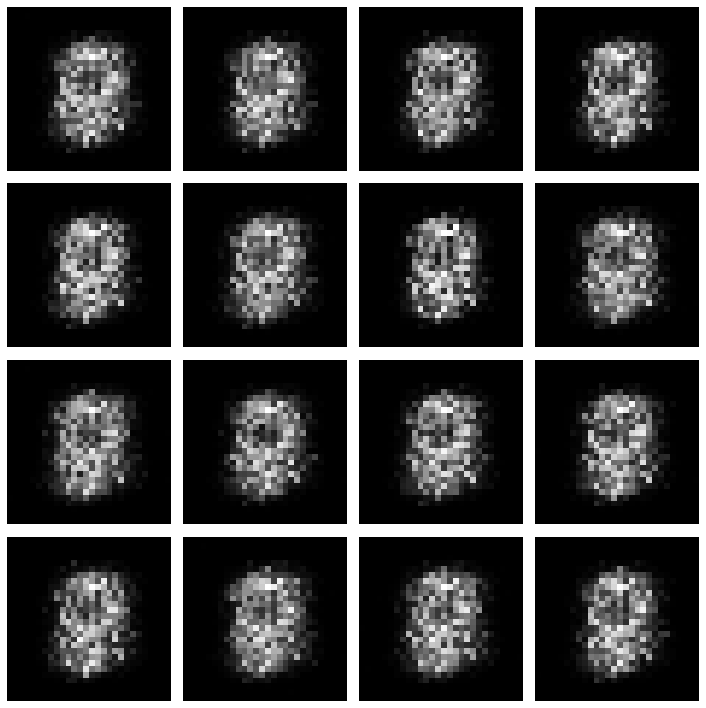

499: [D loss: 0.000945, acc: 1.000000]  [A loss: 6.058202, acc: 0.000000]


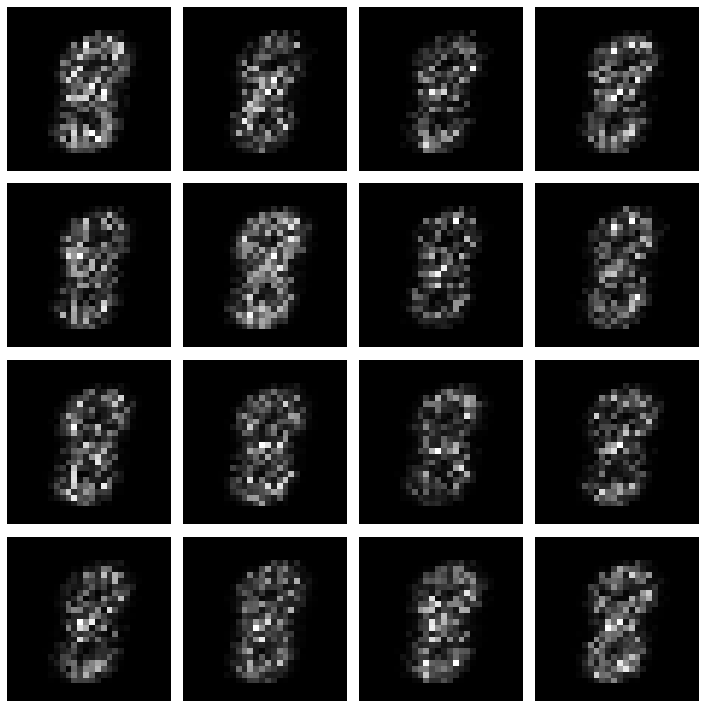

999: [D loss: 0.005329, acc: 1.000000]  [A loss: 4.091028, acc: 0.039062]


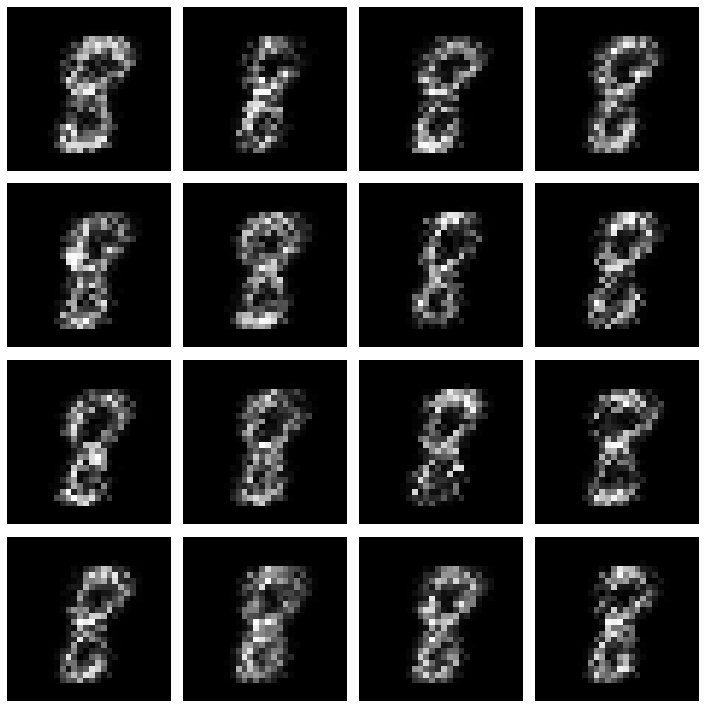

1499: [D loss: 0.004189, acc: 1.000000]  [A loss: 7.249671, acc: 0.003906]


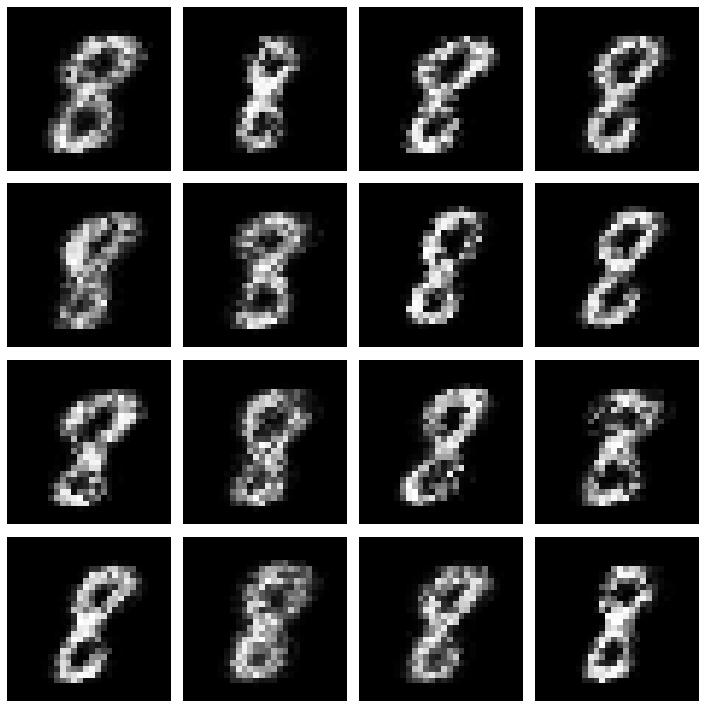

1999: [D loss: 0.030230, acc: 0.992188]  [A loss: 5.647841, acc: 0.003906]


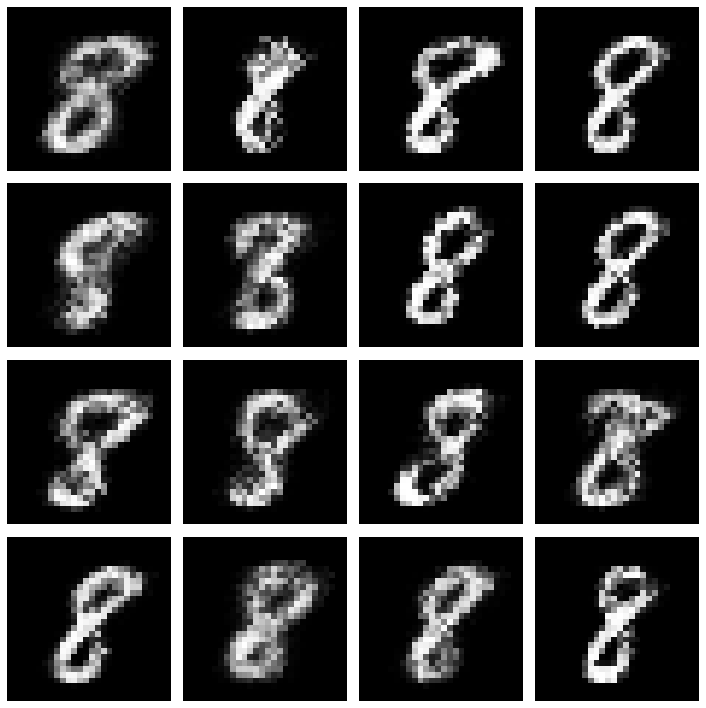

2499: [D loss: 0.020598, acc: 0.994141]  [A loss: 4.837264, acc: 0.011719]


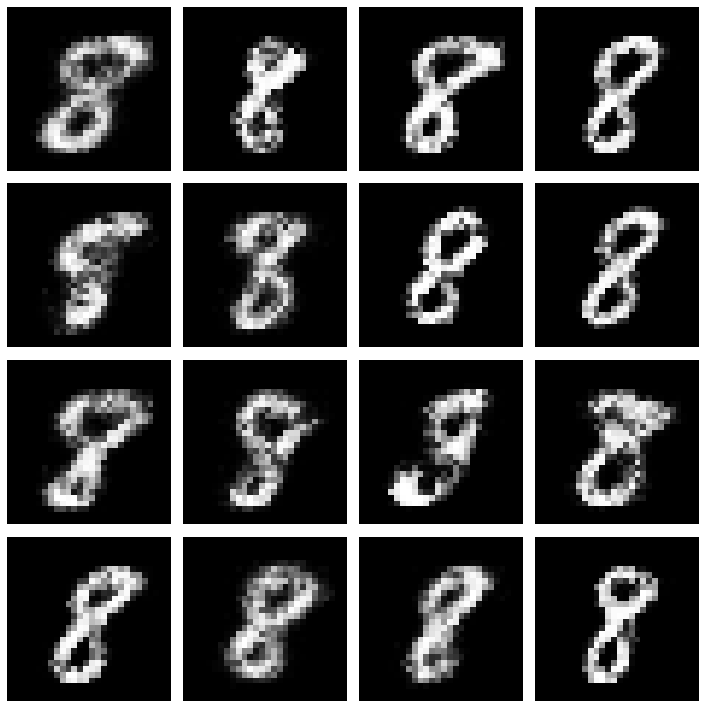

2999: [D loss: 0.038309, acc: 0.988281]  [A loss: 4.709832, acc: 0.015625]


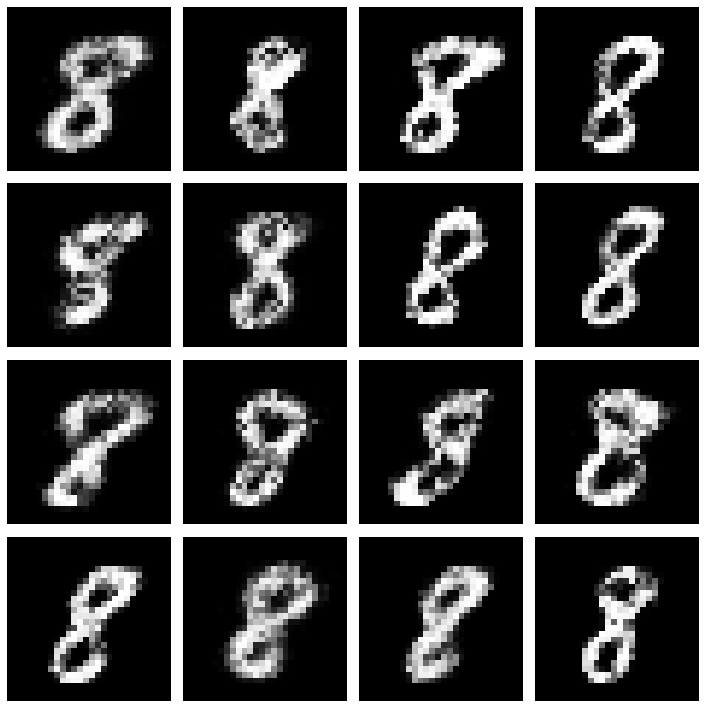

3499: [D loss: 0.042114, acc: 0.984375]  [A loss: 4.764092, acc: 0.007812]


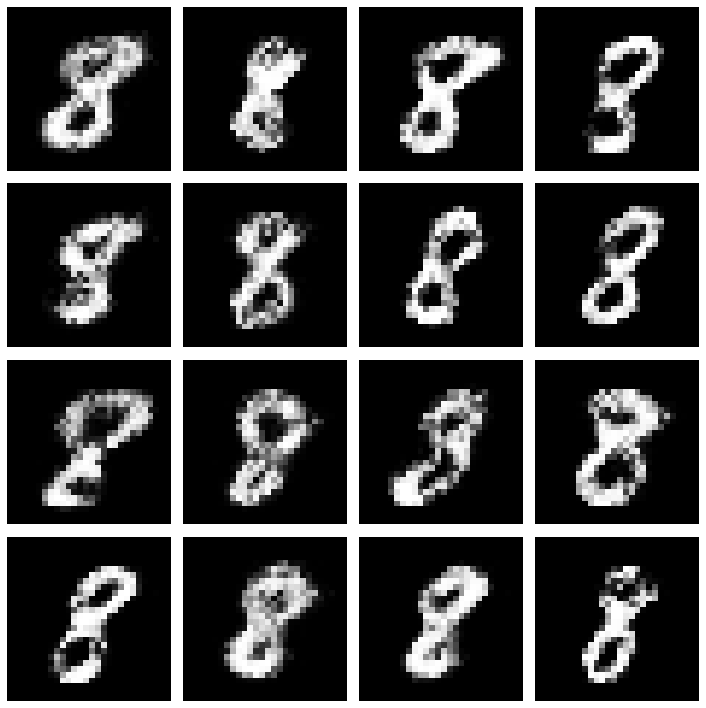

3999: [D loss: 0.061411, acc: 0.978516]  [A loss: 4.369837, acc: 0.015625]


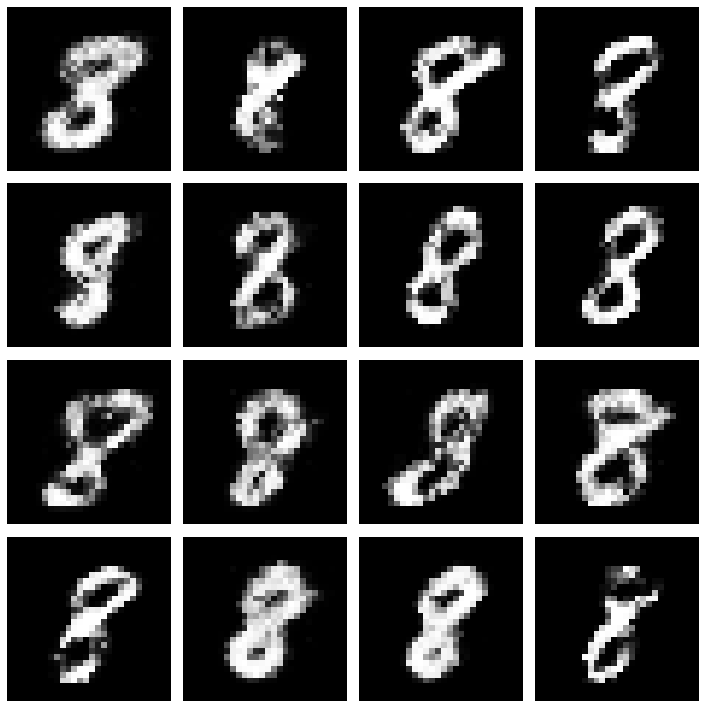

4499: [D loss: 0.065312, acc: 0.980469]  [A loss: 3.803145, acc: 0.031250]


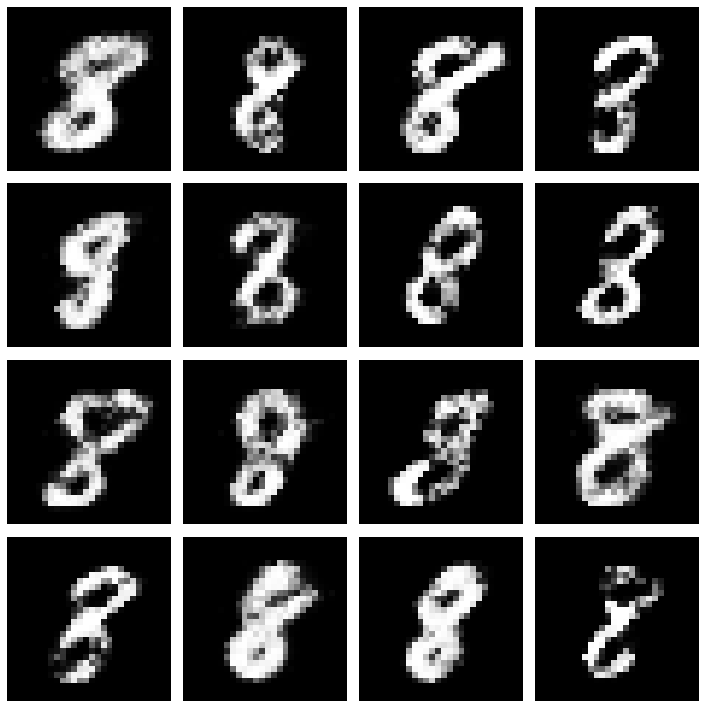

4999: [D loss: 0.052052, acc: 0.984375]  [A loss: 4.241851, acc: 0.019531]


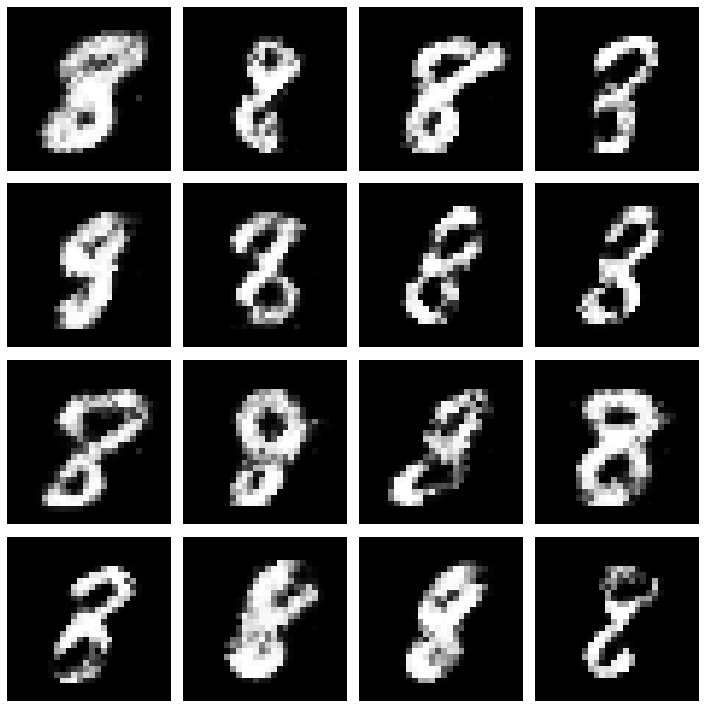

5499: [D loss: 0.074722, acc: 0.982422]  [A loss: 3.855838, acc: 0.023438]


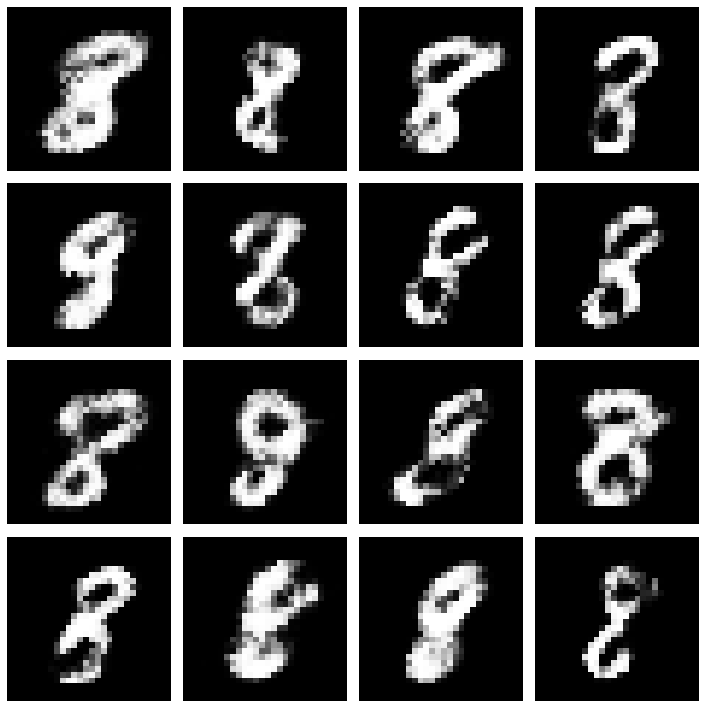

5999: [D loss: 0.085792, acc: 0.976562]  [A loss: 3.813155, acc: 0.039062]


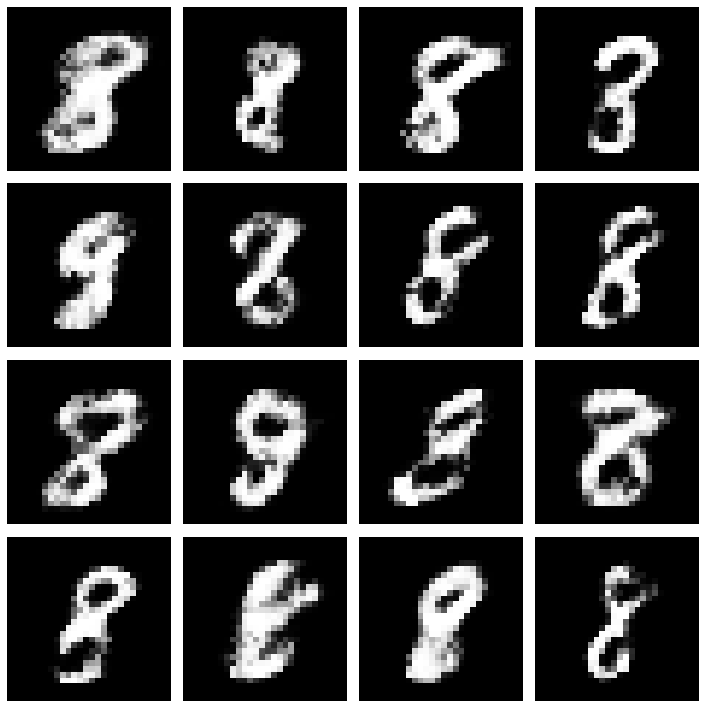

6499: [D loss: 0.118980, acc: 0.960938]  [A loss: 3.402041, acc: 0.031250]


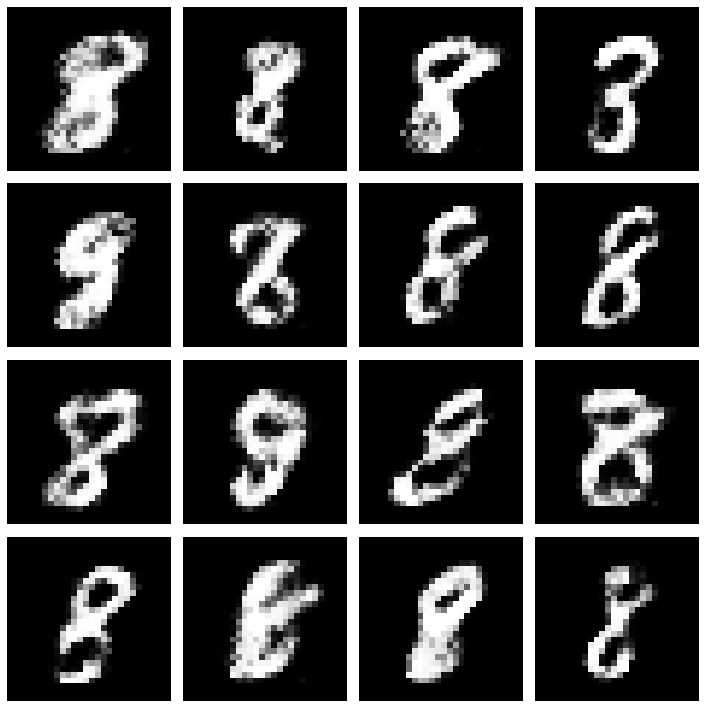

6999: [D loss: 0.141877, acc: 0.949219]  [A loss: 3.308458, acc: 0.046875]


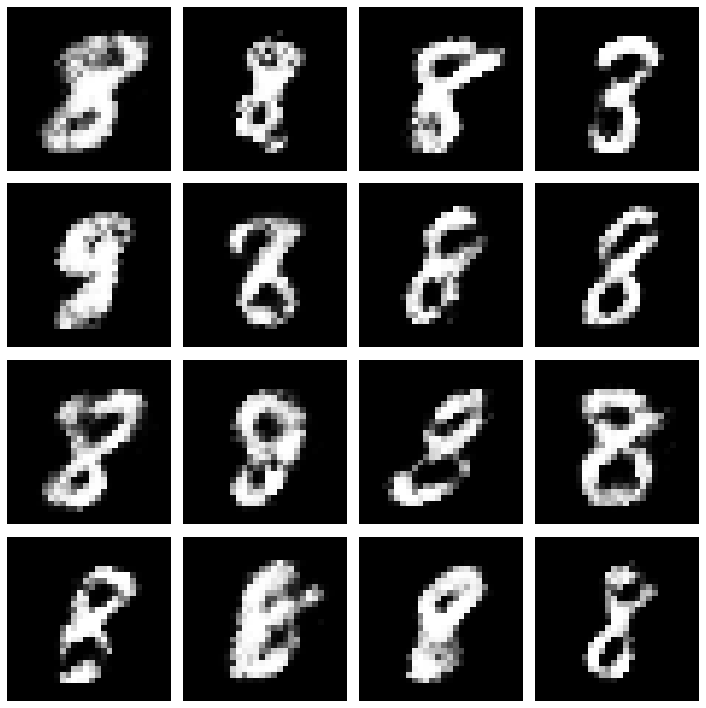

7499: [D loss: 0.104596, acc: 0.962891]  [A loss: 3.166759, acc: 0.058594]


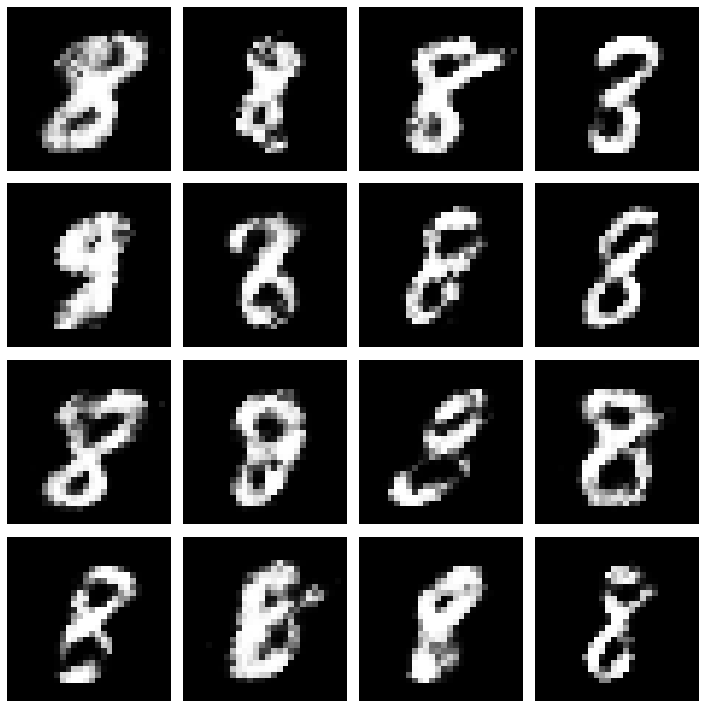

7999: [D loss: 0.102920, acc: 0.968750]  [A loss: 3.578997, acc: 0.031250]


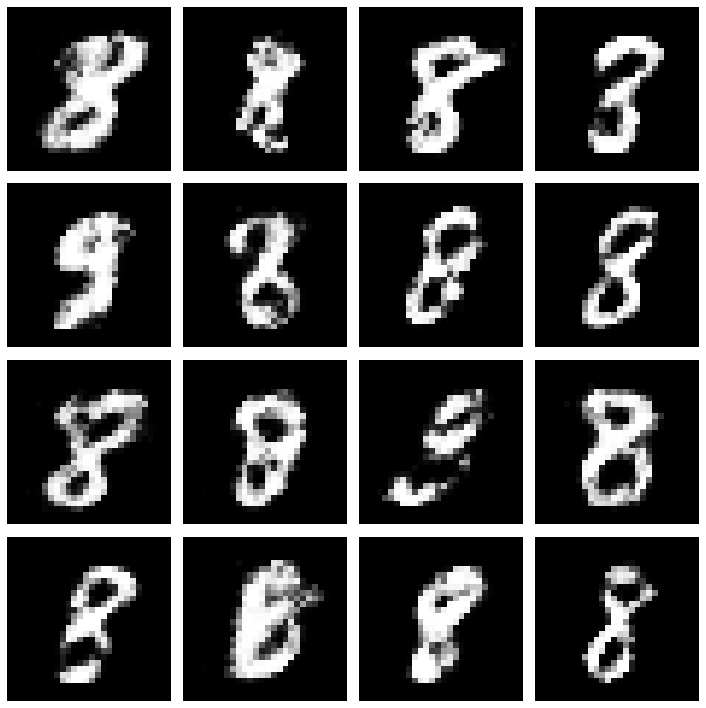

8499: [D loss: 0.122634, acc: 0.962891]  [A loss: 3.463431, acc: 0.035156]


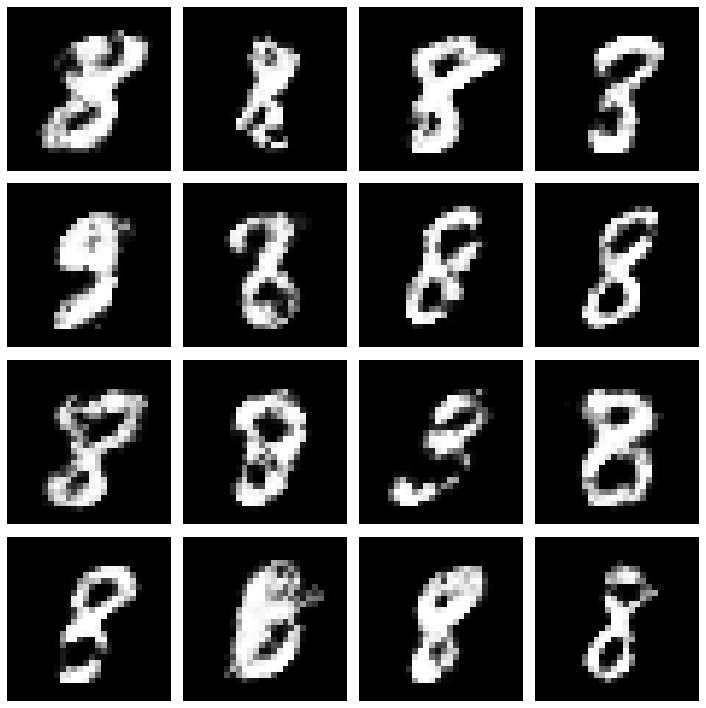

8999: [D loss: 0.106681, acc: 0.960938]  [A loss: 3.384233, acc: 0.046875]


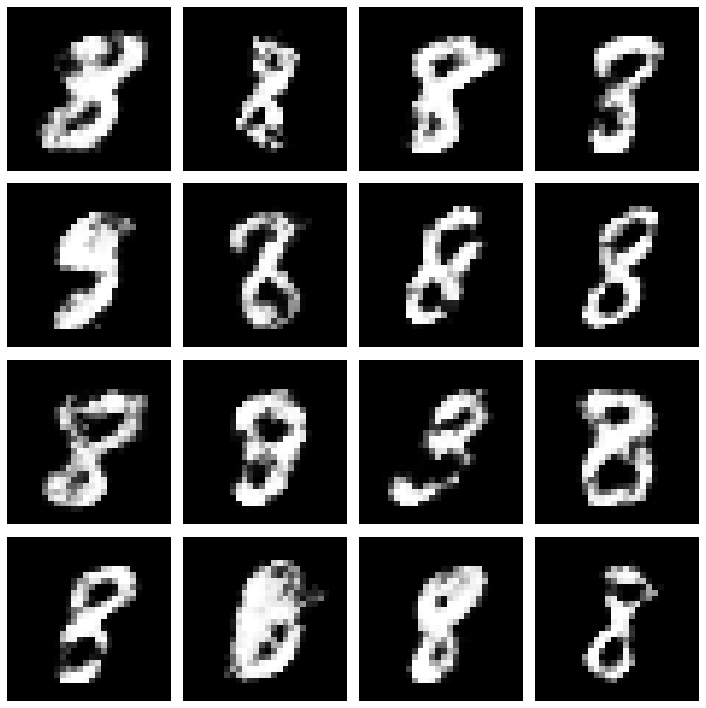

9499: [D loss: 0.171979, acc: 0.945312]  [A loss: 3.372800, acc: 0.035156]


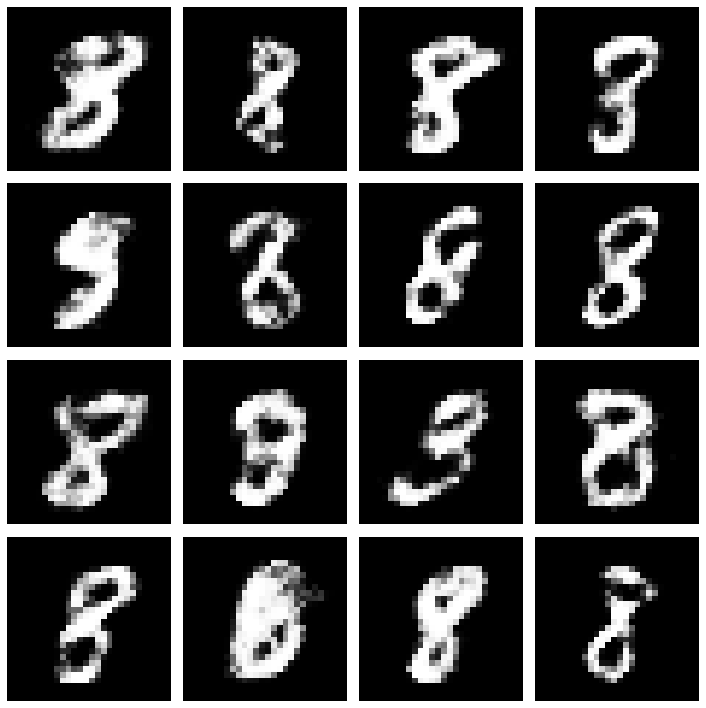

9999: [D loss: 0.120475, acc: 0.953125]  [A loss: 3.359379, acc: 0.031250]


In [ ]:
model.train(train_steps=10000, batch_size=256, save_interval=500)

In [ ]:
K.clear_session()
G = Sequential()
G.add(Dense(256, input_dim = z))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))
G.add(Dropout(dropout))

G.add(Dense(512))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))
G.add(Dropout(dropout))

G.add(Dense(784, activation = 'tanh'))
G.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
activation_2 (Activation)    (None, 512)              

In [ ]:
D = Sequential()

D.add(Dense(512, input_dim=784, activation = 'relu'))
D.add(Dropout(dropout))

D.add(Dense(256, activation = 'relu'))
D.add(Dropout(dropout))

D.add(Dense(100, activation = 'relu'))
D.add(Dropout(dropout))

D.add(Dense(1, activation = 'sigmoid'))
D.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               25700     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [ ]:
model = GAN(G,D)
model.load_dataset()
model.preprocess_data(mode = MLPGAN_TANH)
model.build()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 784)               562704    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 559049    
Total params: 1,121,753
Trainable params: 561,168
Non-trainable params: 560,585
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


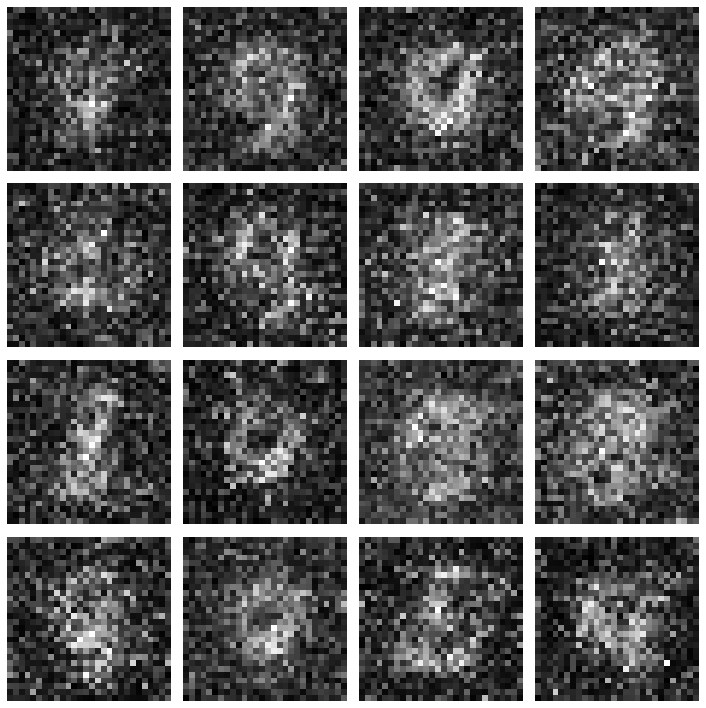

499: [D loss: 0.205773, acc: 0.910156]  [A loss: 7.008292, acc: 0.000000]


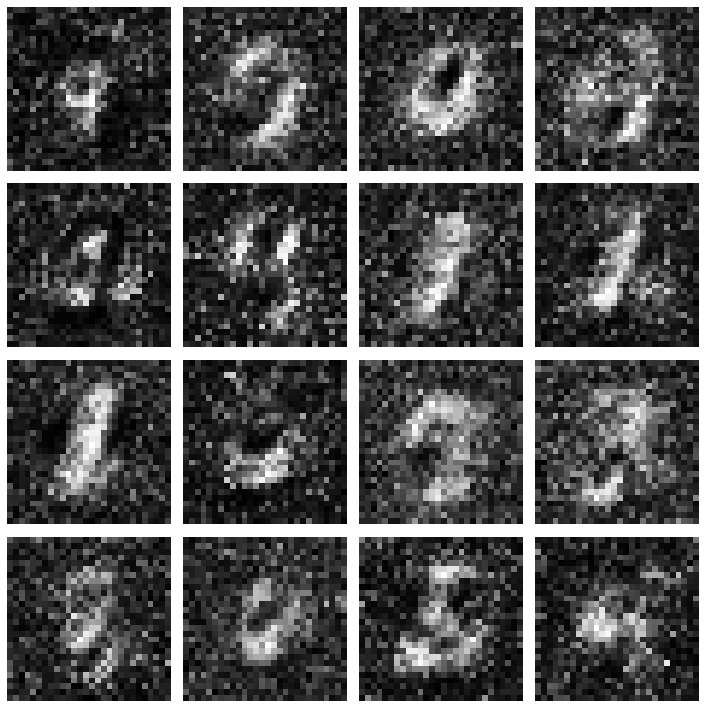

999: [D loss: 0.269929, acc: 0.880859]  [A loss: 1.959755, acc: 0.171875]


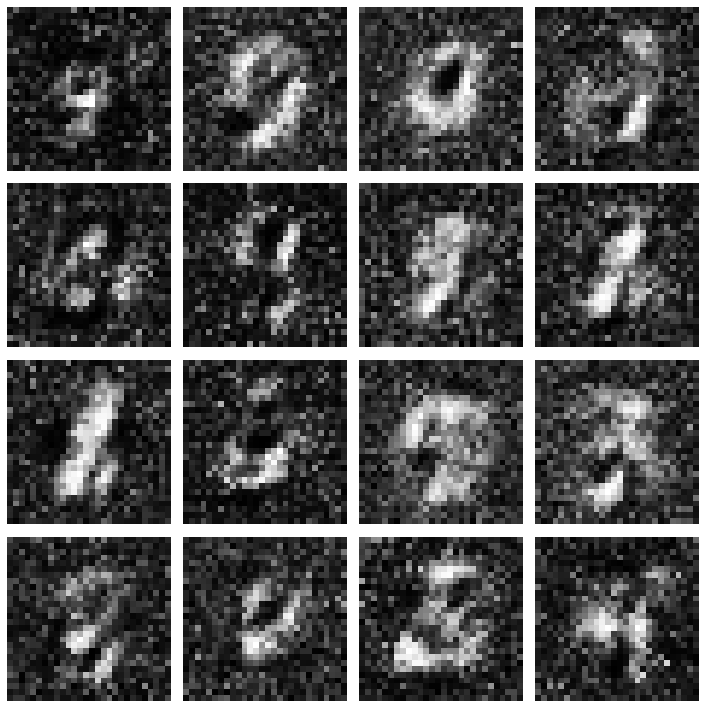

1499: [D loss: 0.286998, acc: 0.863281]  [A loss: 3.470758, acc: 0.042969]


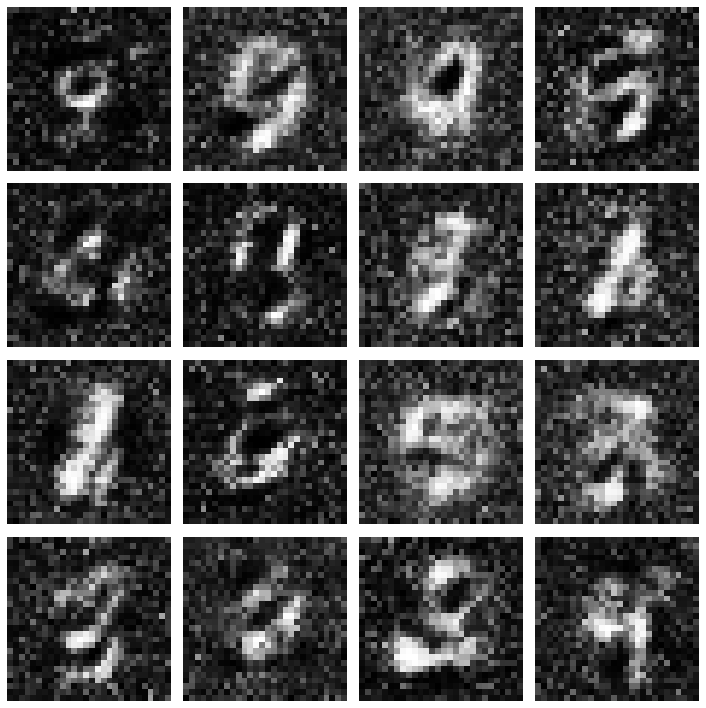

1999: [D loss: 0.280953, acc: 0.886719]  [A loss: 1.774794, acc: 0.234375]


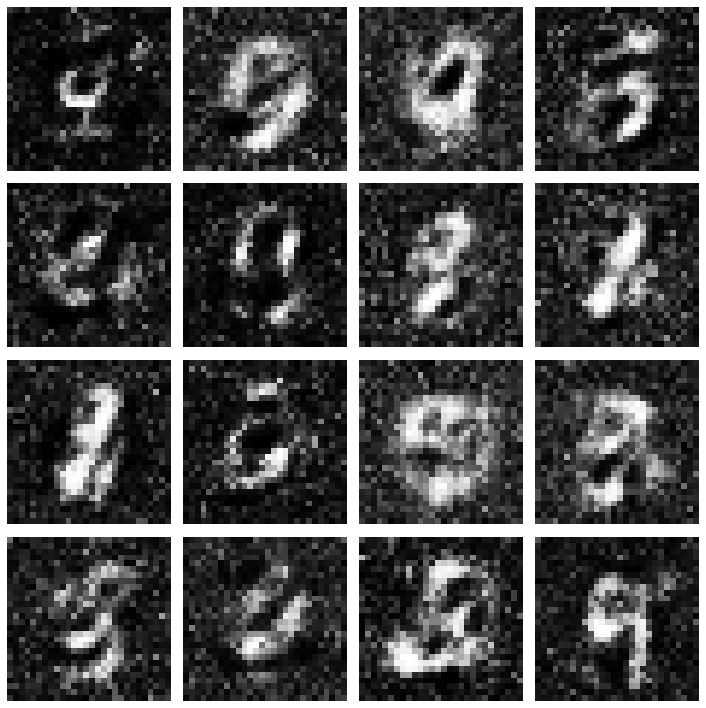

2499: [D loss: 0.259471, acc: 0.896484]  [A loss: 2.583709, acc: 0.109375]


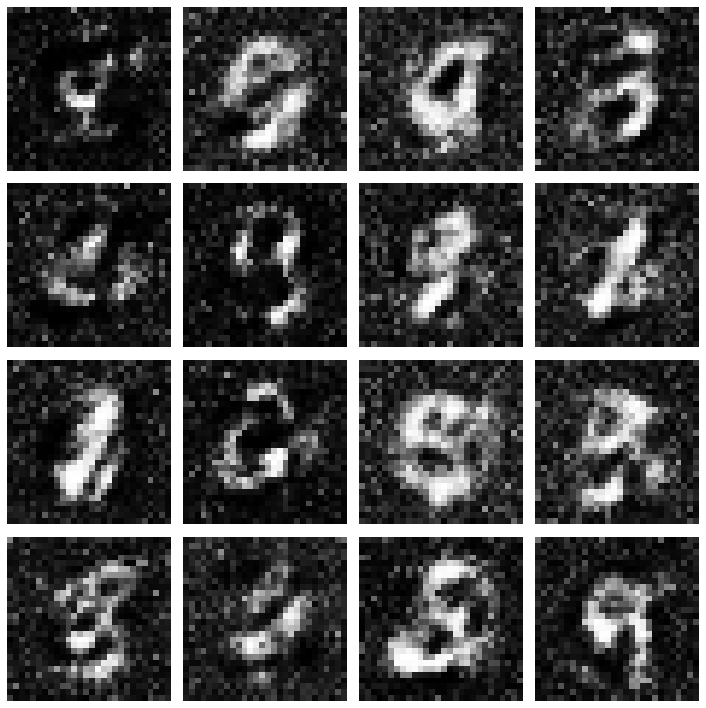

2999: [D loss: 0.245617, acc: 0.900391]  [A loss: 2.895819, acc: 0.085938]


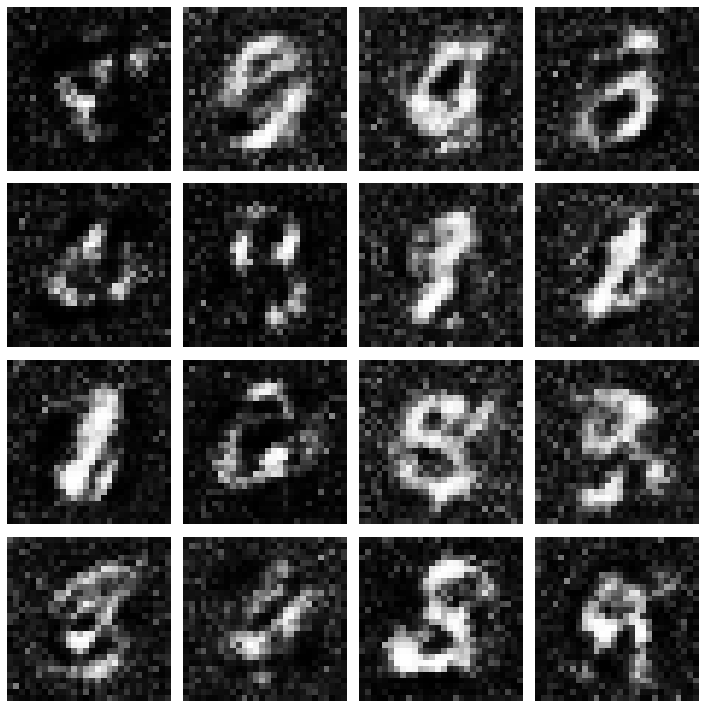

3499: [D loss: 0.331338, acc: 0.841797]  [A loss: 3.335934, acc: 0.066406]


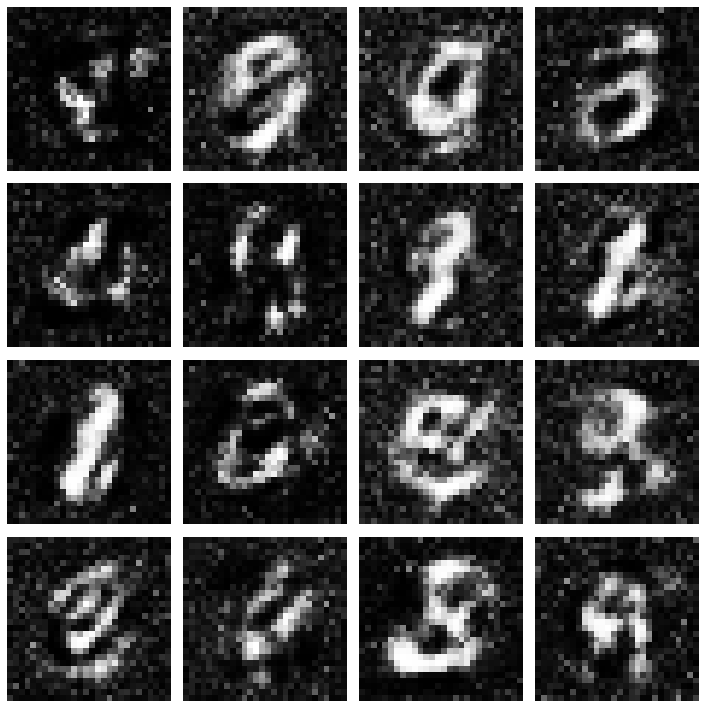

3999: [D loss: 0.270178, acc: 0.894531]  [A loss: 2.501513, acc: 0.113281]


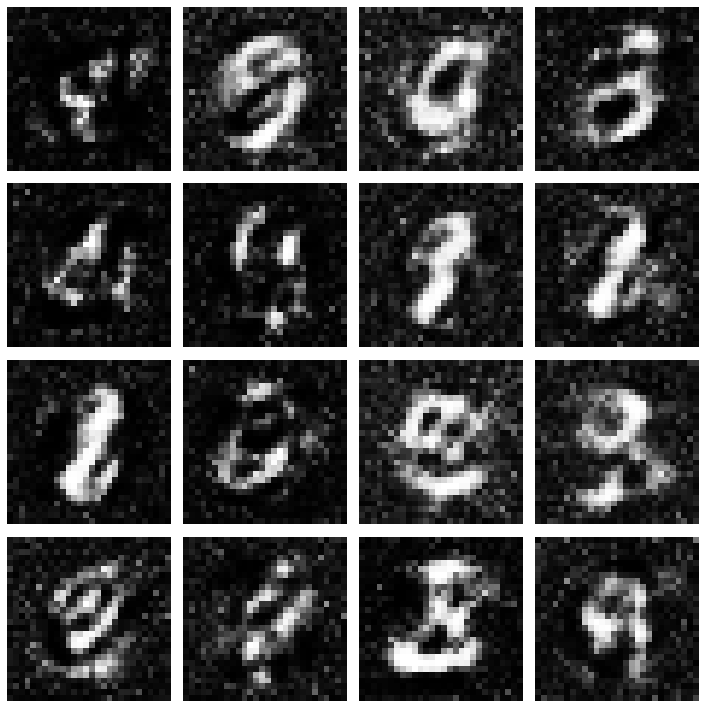

4499: [D loss: 0.281331, acc: 0.880859]  [A loss: 2.789848, acc: 0.054688]


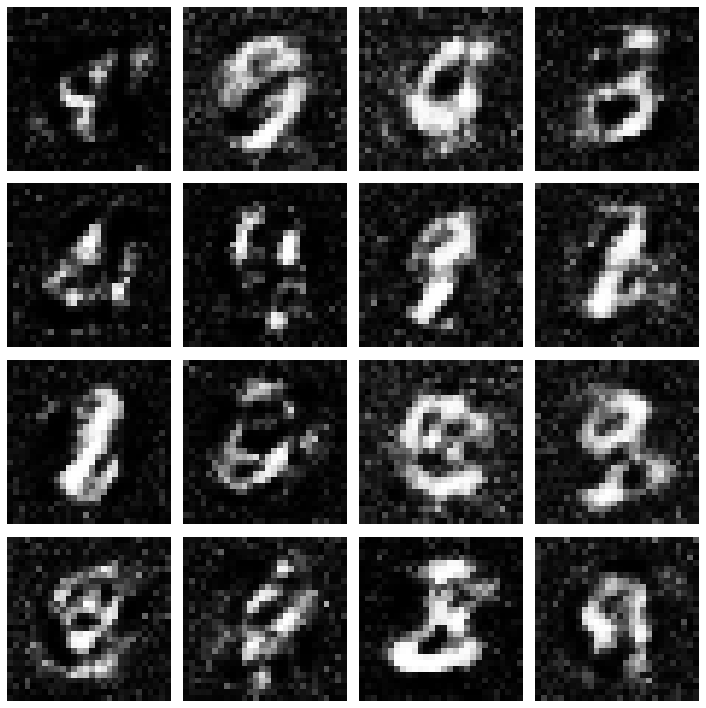

4999: [D loss: 0.273606, acc: 0.880859]  [A loss: 1.830152, acc: 0.207031]


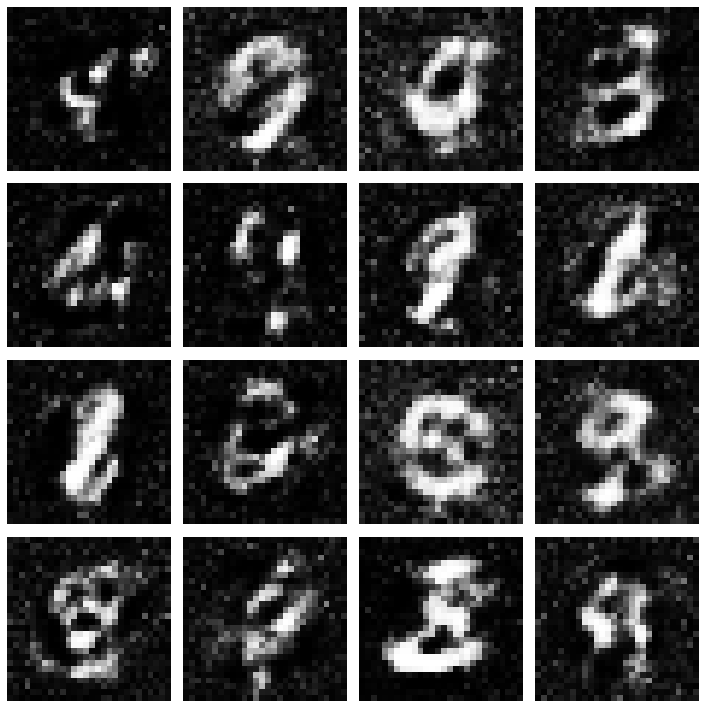

5499: [D loss: 0.368827, acc: 0.828125]  [A loss: 2.652395, acc: 0.066406]


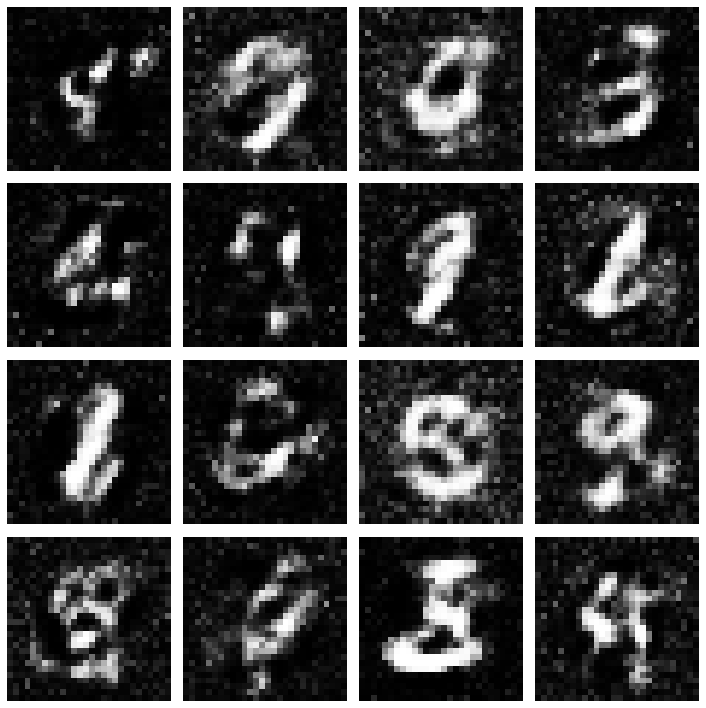

5999: [D loss: 0.322812, acc: 0.851562]  [A loss: 2.162901, acc: 0.164062]


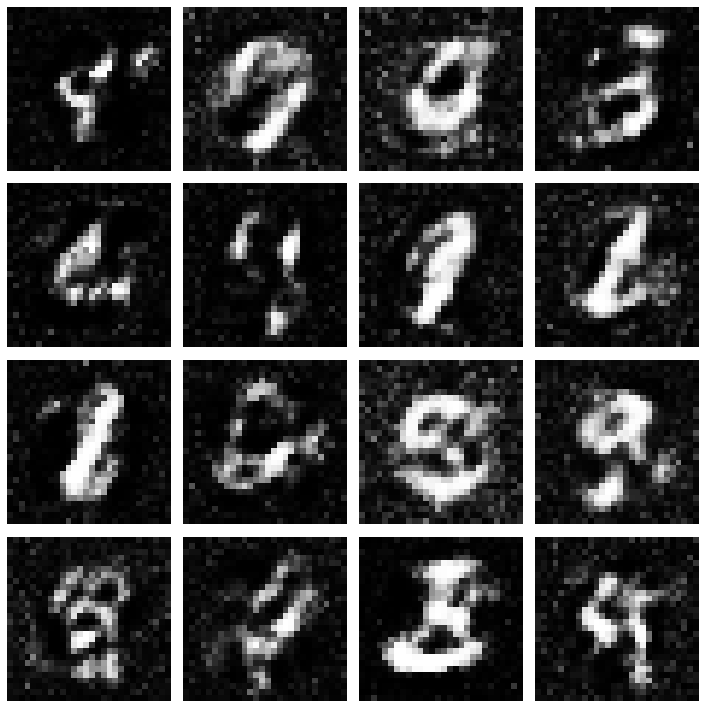

6499: [D loss: 0.367720, acc: 0.849609]  [A loss: 1.346441, acc: 0.355469]


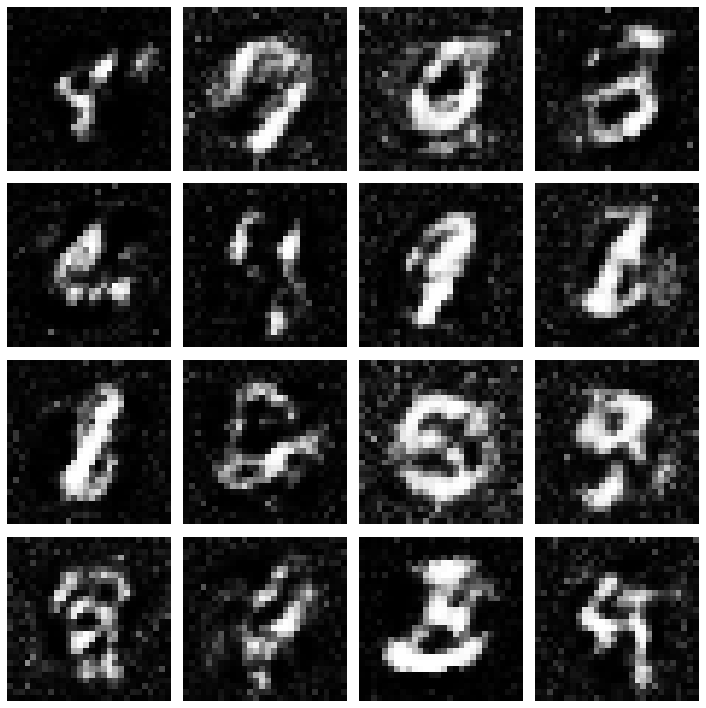

6999: [D loss: 0.337539, acc: 0.853516]  [A loss: 1.694699, acc: 0.222656]


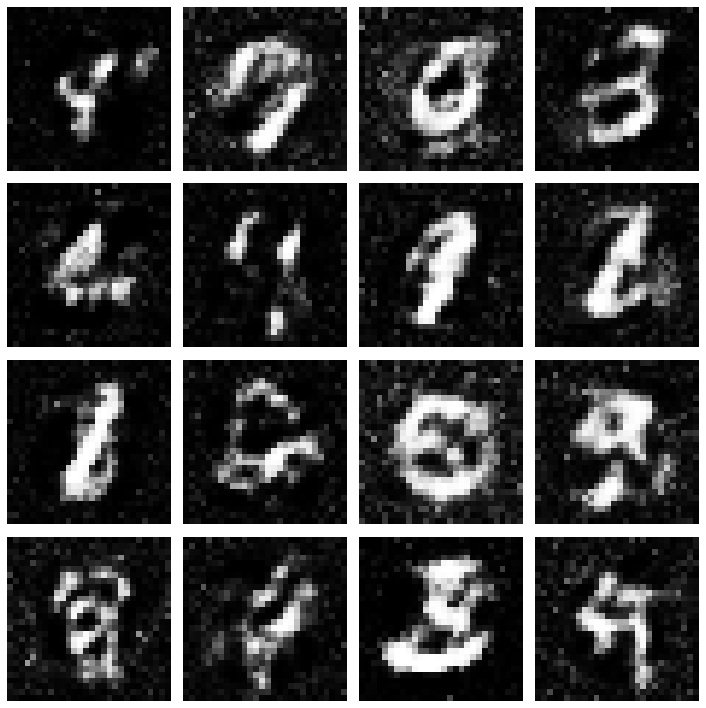

7499: [D loss: 0.375952, acc: 0.833984]  [A loss: 1.508339, acc: 0.292969]


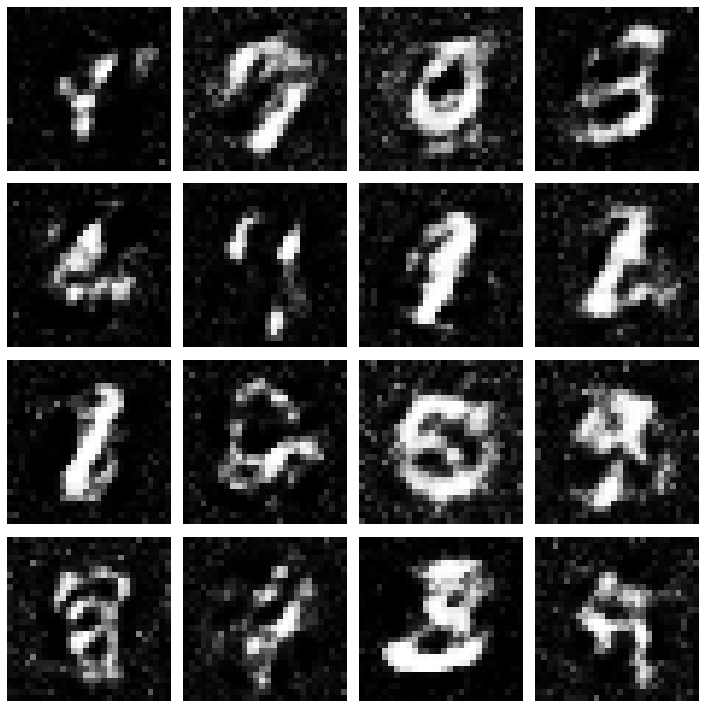

7999: [D loss: 0.411035, acc: 0.822266]  [A loss: 2.205875, acc: 0.113281]


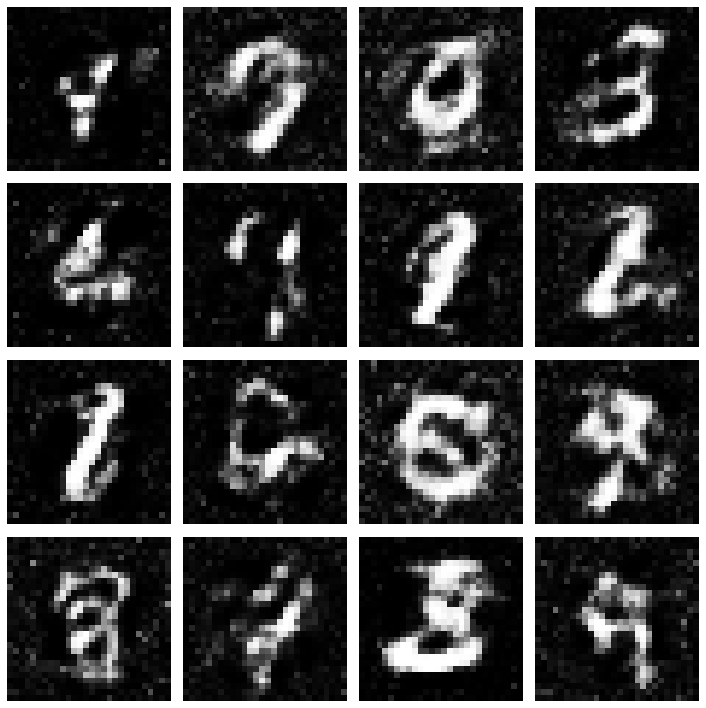

8499: [D loss: 0.359362, acc: 0.841797]  [A loss: 2.115898, acc: 0.132812]


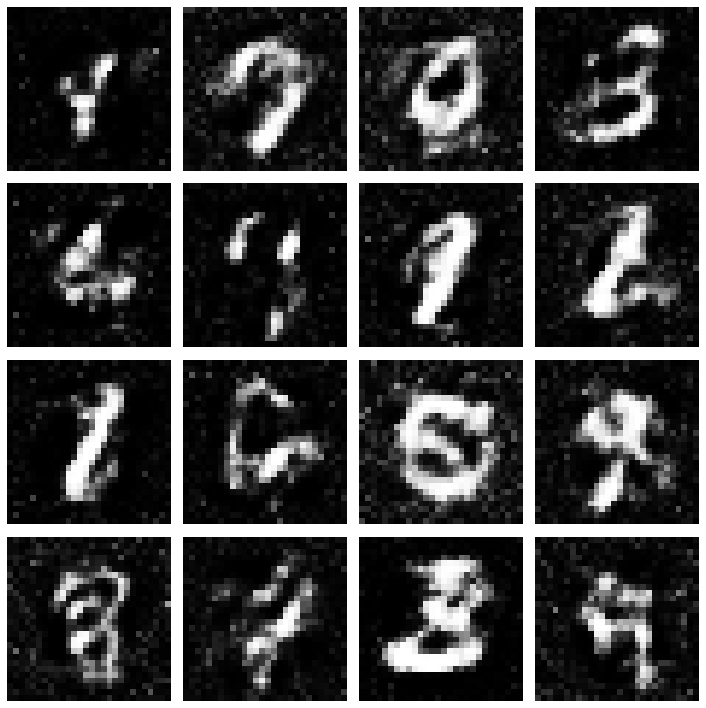

8999: [D loss: 0.353898, acc: 0.845703]  [A loss: 1.482402, acc: 0.265625]


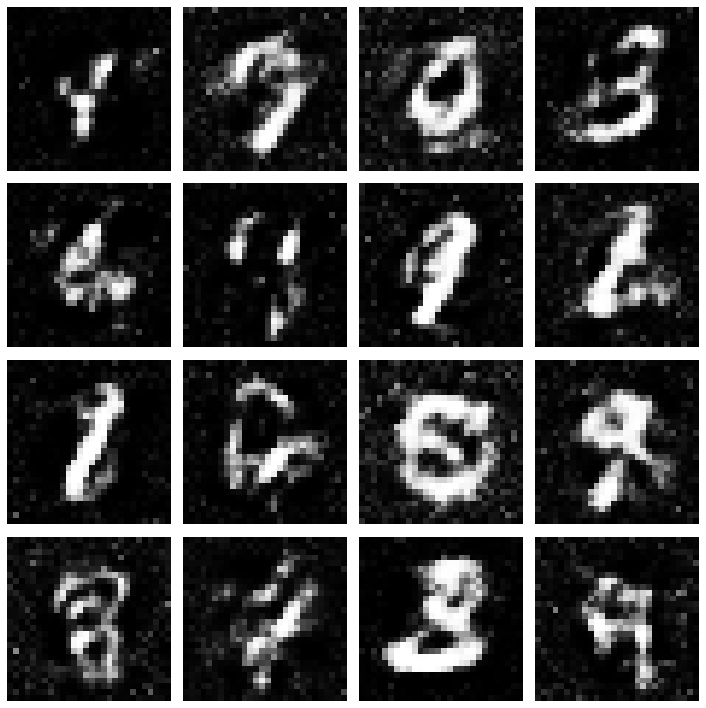

9499: [D loss: 0.320827, acc: 0.876953]  [A loss: 2.157465, acc: 0.093750]


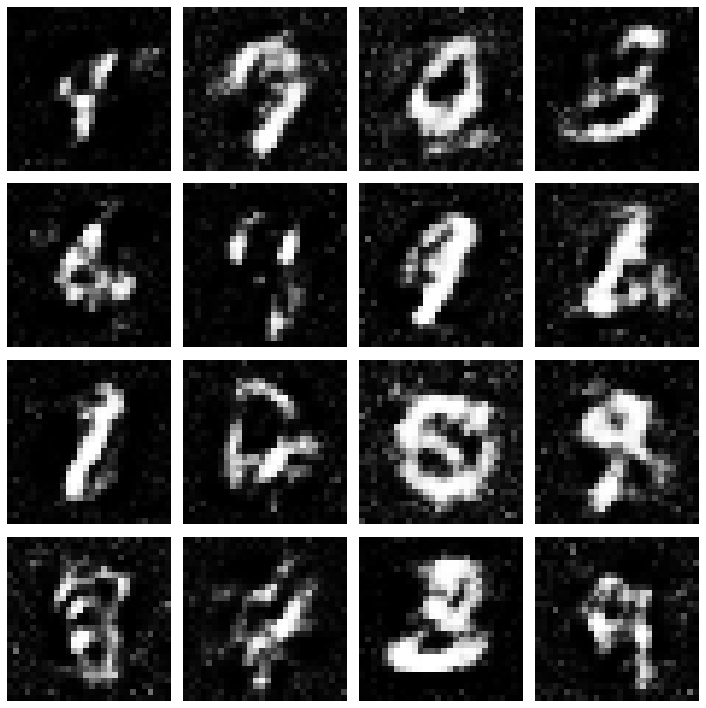

9999: [D loss: 0.371591, acc: 0.837891]  [A loss: 1.901680, acc: 0.199219]


In [ ]:
model.train(train_steps=10000, batch_size=256, save_interval=500)

In [ ]:
K.clear_session()
dropout = 0.4
depth = 64*4
dim = 7
z = 100

G = Sequential()
G.add(Dense(dim**2*depth, input_dim = z))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))
G.add(Reshape((dim,dim,depth)))
G.add(Dropout(dropout))

G.add(UpSampling2D())
G.add(Conv2DTranspose(int(depth/2), 5, padding = 'same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))

G.add(UpSampling2D())
G.add(Conv2DTranspose(int(depth/4), 5, padding = 'same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))

G.add(Conv2DTranspose(int(depth/8),5,padding = 'same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))

G.add(Conv2DTranspose(1, 5, padding = 'same'))
G.add(Activation('sigmoid'))
G.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_1 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)    

In [ ]:
depth = 64
input_shape = (28,28,1)

D = Sequential()
D.add(Conv2D(depth, 5, strides = 2, input_shape = input_shape))
D.add(LeakyReLU(alpha=0.2))
D.add(Dropout(dropout))

D.add(Conv2D(depth*2, 5, strides = 2, padding = 'same'))
D.add(LeakyReLU(alpha = 0.2))
D.add(Dropout(dropout))

D.add(Conv2D(depth*8, 5, strides = 1, padding = 'same'))
D.add(LeakyReLU(alpha = 0.2))
D.add(Dropout(dropout))

D.add(Flatten())
D.add(Dense(1, activation = 'sigmoid'))
D.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 12, 12, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 512)        

In [ ]:
model = GAN(G,D)
model.load_dataset()
model.preprocess_data(mode = DCGAN_SIGMOID)
model.build()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         2394241   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1863937   
Total params: 4,258,178
Trainable params: 2,368,705
Non-trainable params: 1,889,473
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


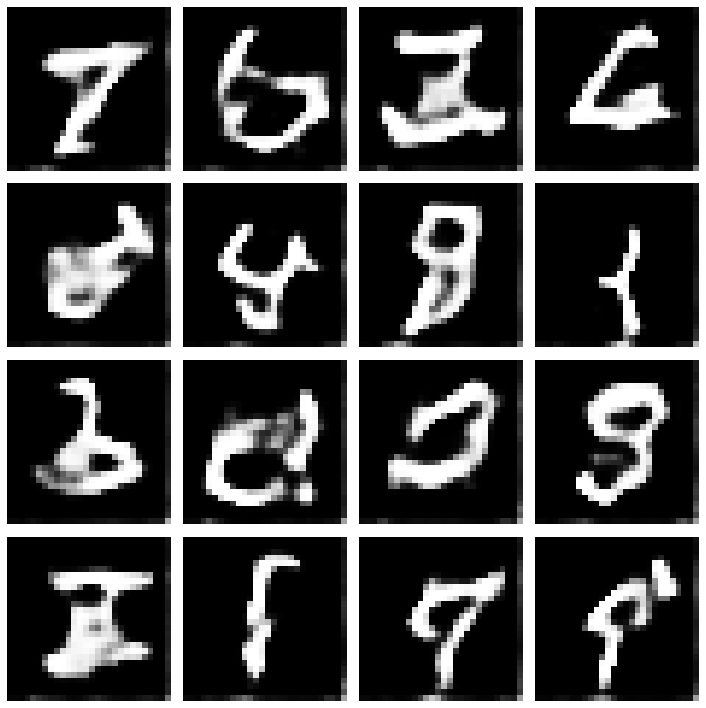

499: [D loss: 0.662557, acc: 0.587891]  [A loss: 0.830071, acc: 0.160156]


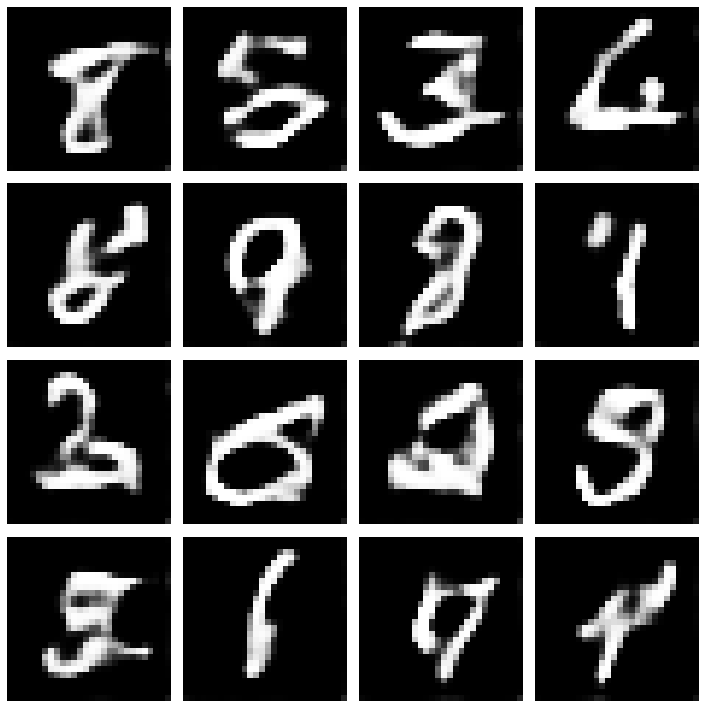

999: [D loss: 0.647736, acc: 0.625000]  [A loss: 0.757118, acc: 0.449219]


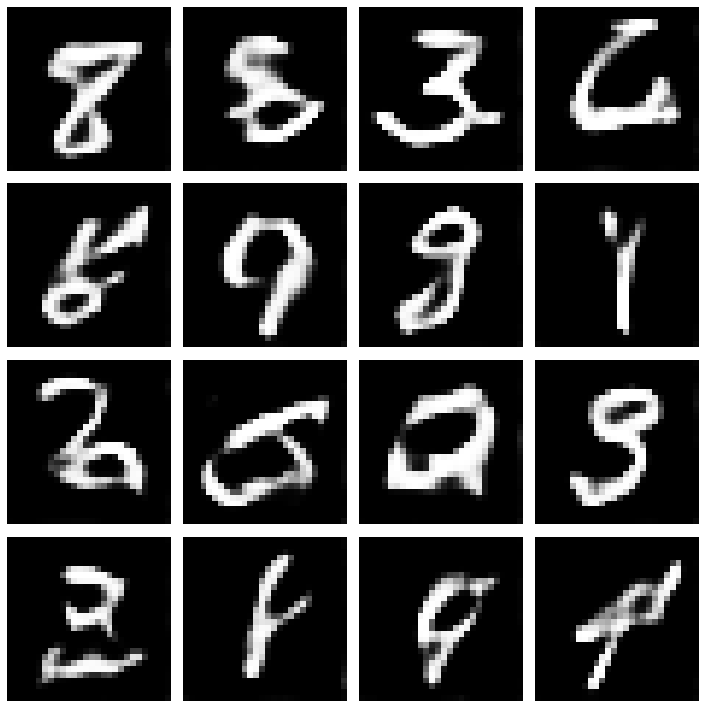

1499: [D loss: 0.646828, acc: 0.623047]  [A loss: 0.805720, acc: 0.335938]


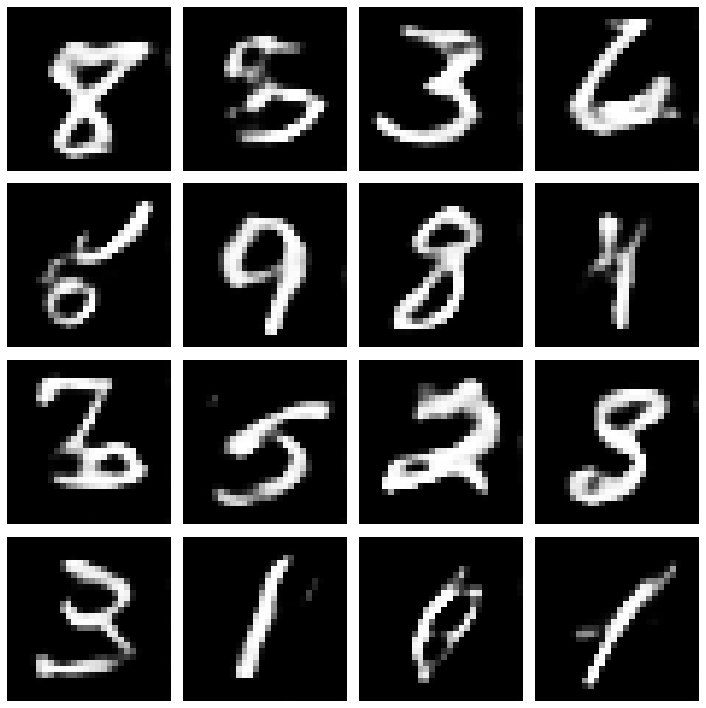

1999: [D loss: 0.673941, acc: 0.578125]  [A loss: 0.896376, acc: 0.207031]


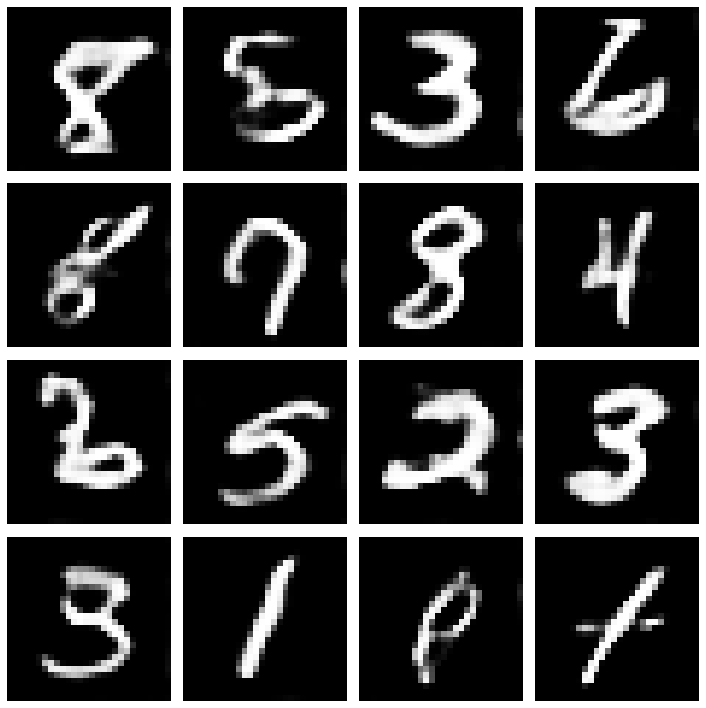

2499: [D loss: 0.644155, acc: 0.630859]  [A loss: 0.740064, acc: 0.445312]


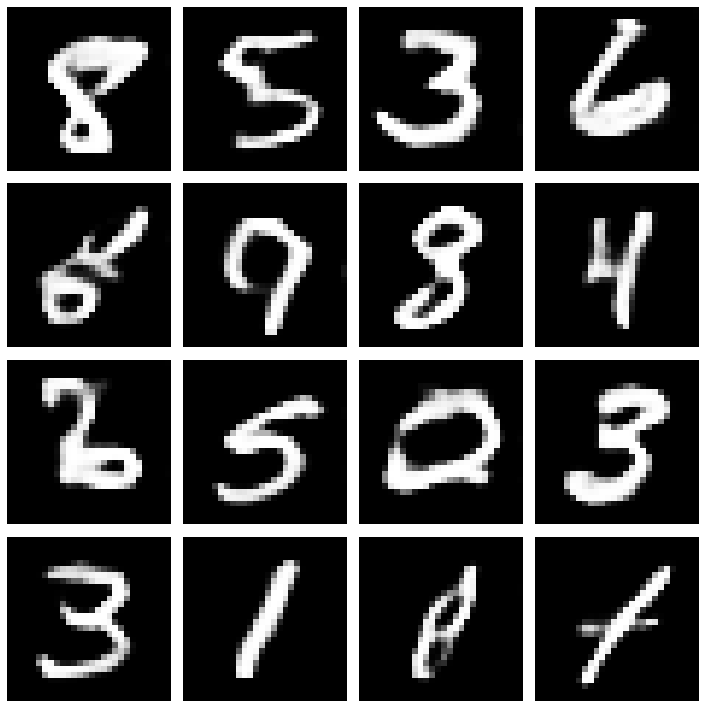

2999: [D loss: 0.670372, acc: 0.605469]  [A loss: 0.881210, acc: 0.187500]


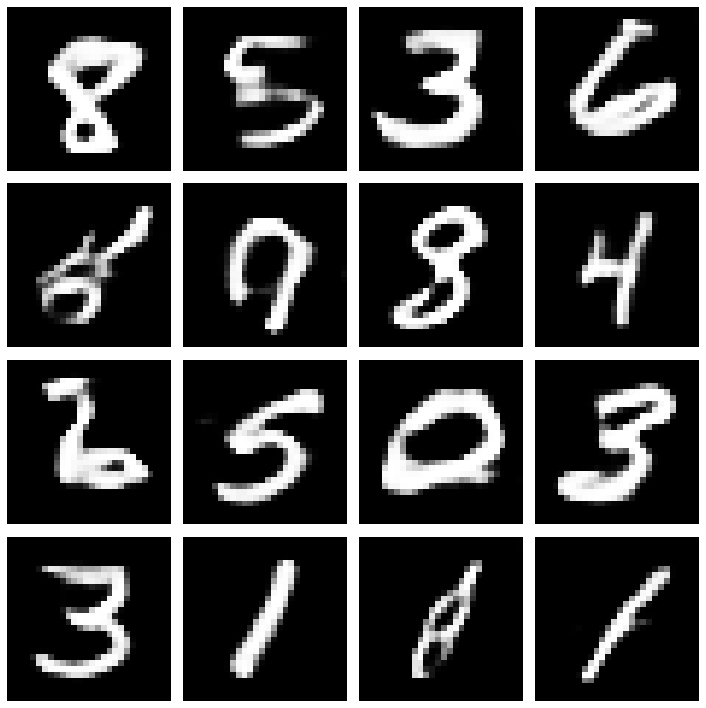

3499: [D loss: 0.675390, acc: 0.585938]  [A loss: 0.863343, acc: 0.203125]


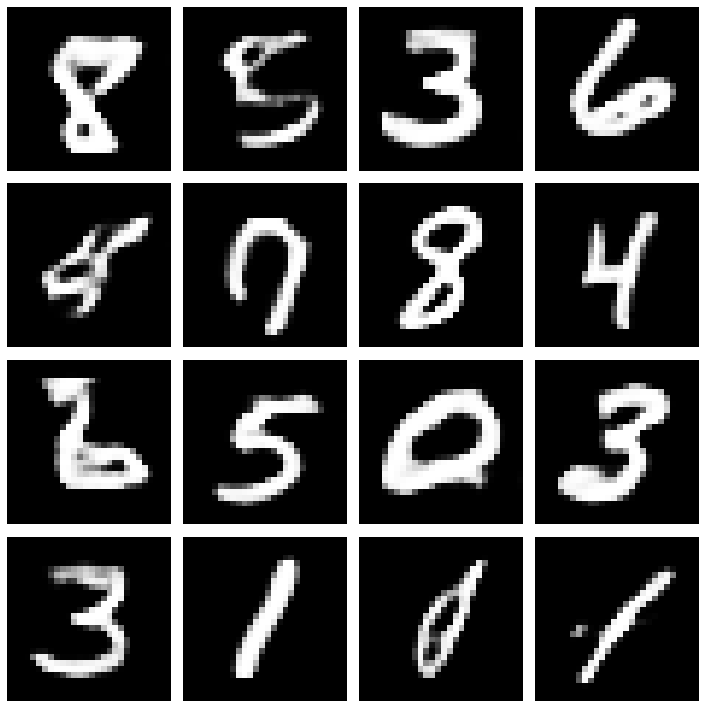

3999: [D loss: 0.660626, acc: 0.595703]  [A loss: 0.713367, acc: 0.480469]


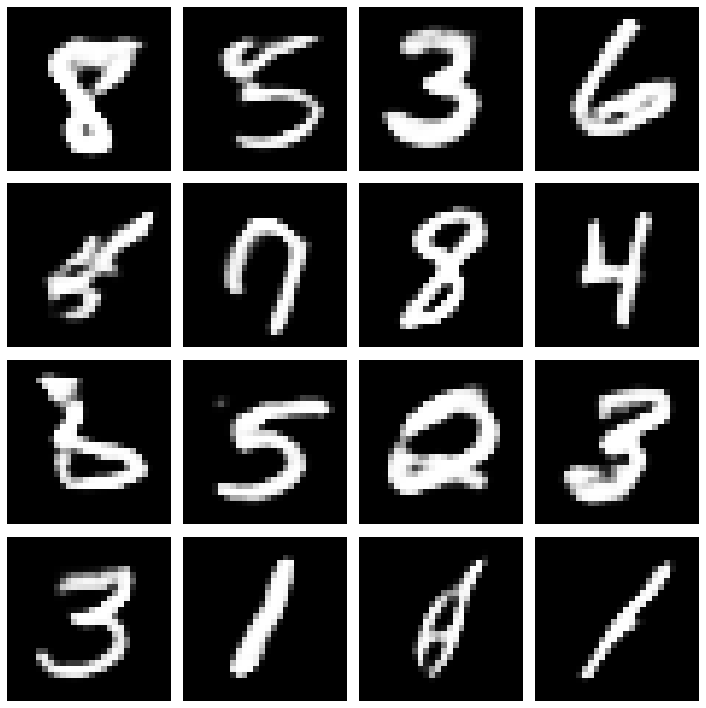

4499: [D loss: 0.671625, acc: 0.585938]  [A loss: 0.788606, acc: 0.355469]


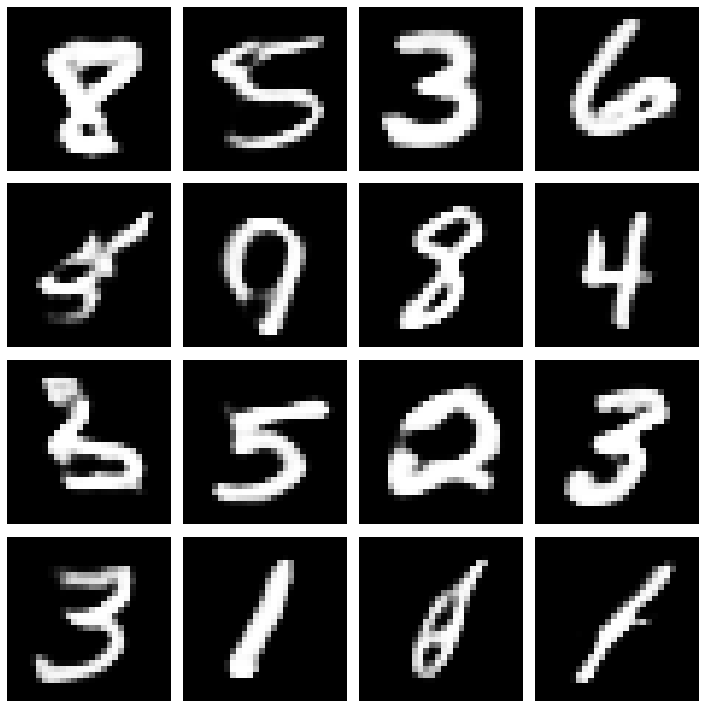

4999: [D loss: 0.673057, acc: 0.576172]  [A loss: 0.853542, acc: 0.234375]


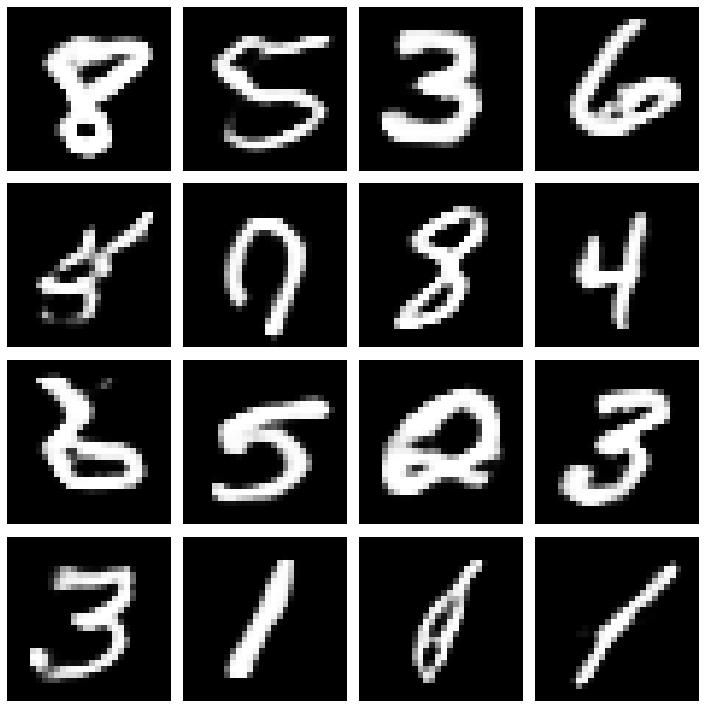

5499: [D loss: 0.678898, acc: 0.560547]  [A loss: 0.673706, acc: 0.558594]


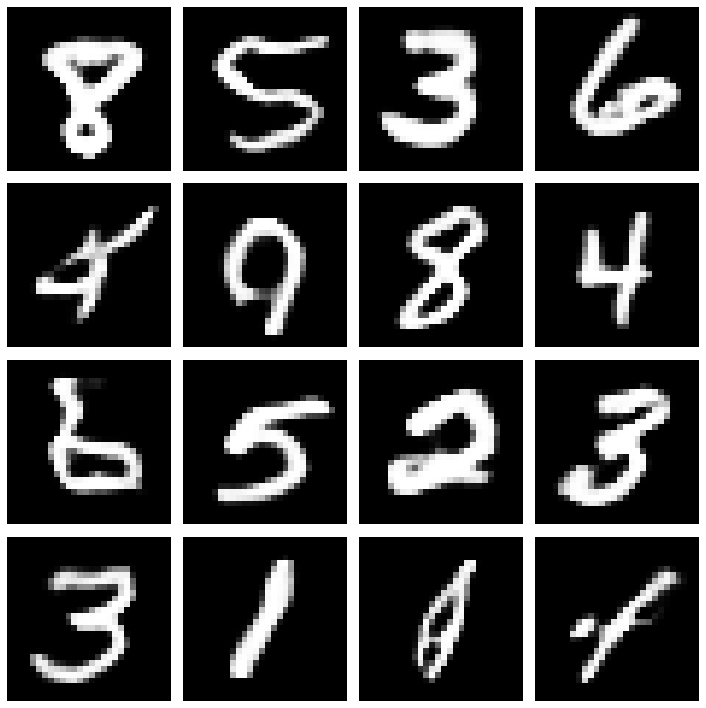

5999: [D loss: 0.680362, acc: 0.544922]  [A loss: 0.722872, acc: 0.460938]


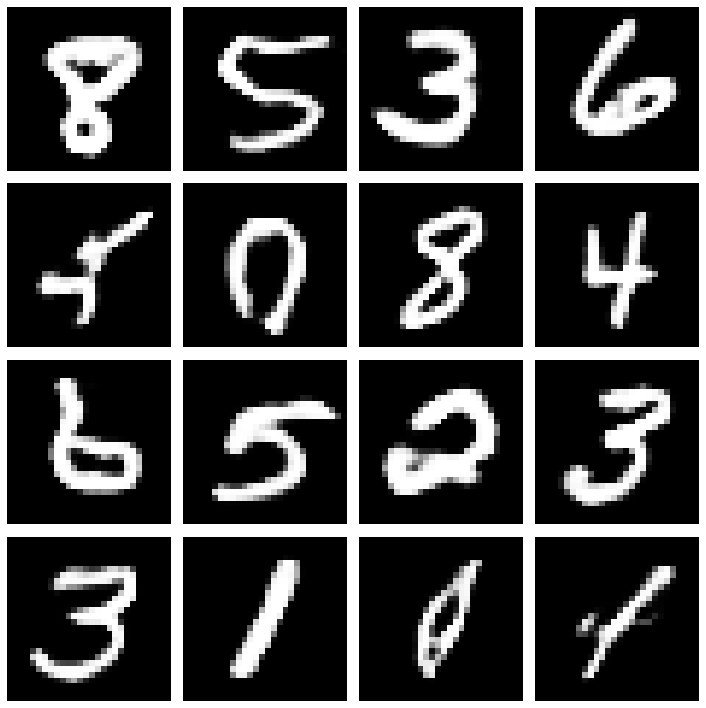

6499: [D loss: 0.667168, acc: 0.607422]  [A loss: 0.768612, acc: 0.359375]


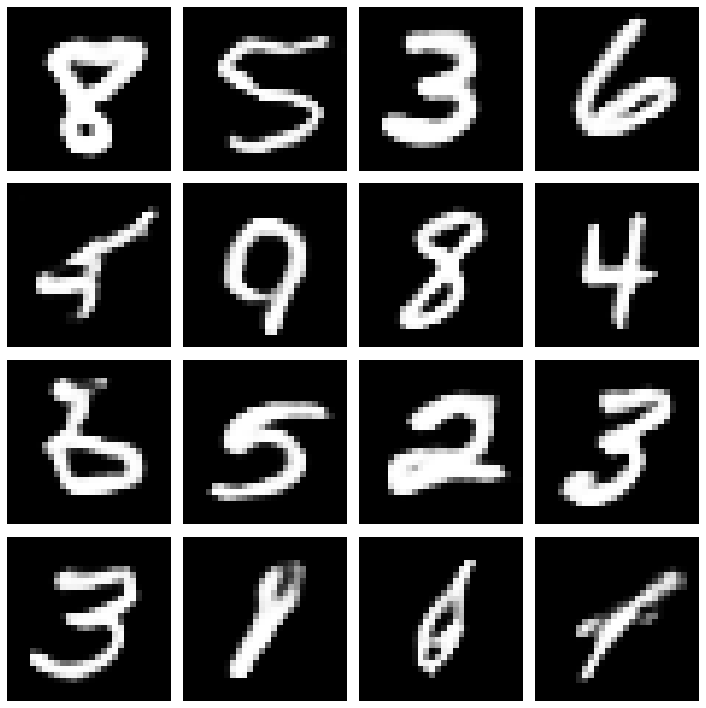

6999: [D loss: 0.659060, acc: 0.621094]  [A loss: 0.793984, acc: 0.289062]


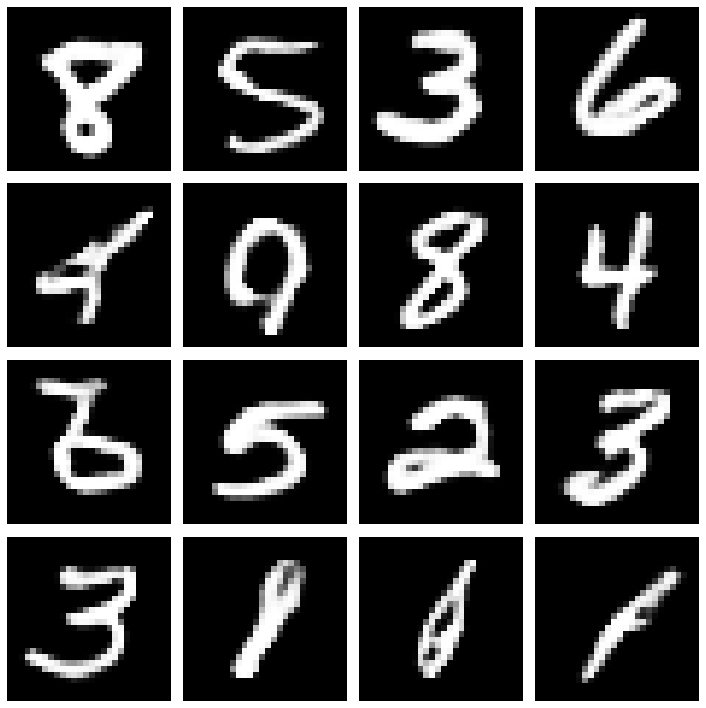

7499: [D loss: 0.656821, acc: 0.615234]  [A loss: 0.689056, acc: 0.523438]


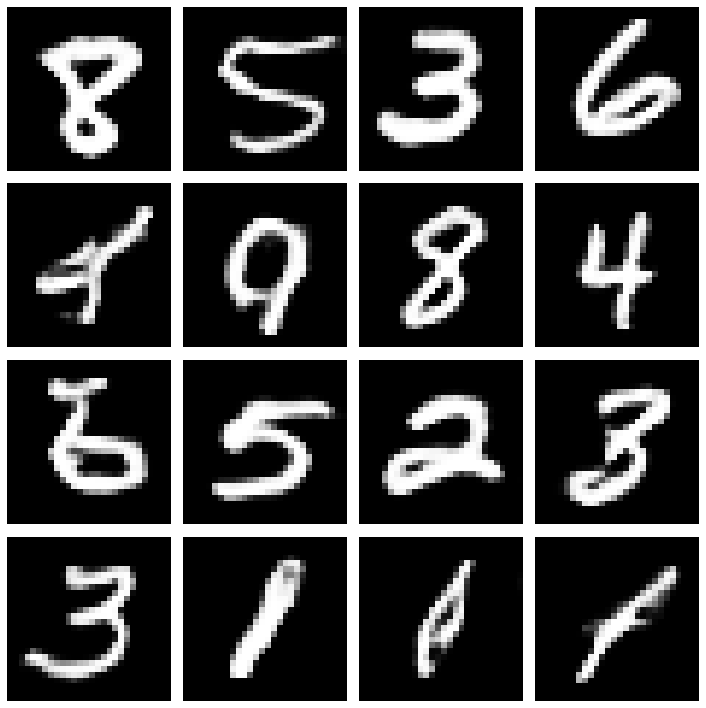

7999: [D loss: 0.670400, acc: 0.582031]  [A loss: 0.750947, acc: 0.406250]


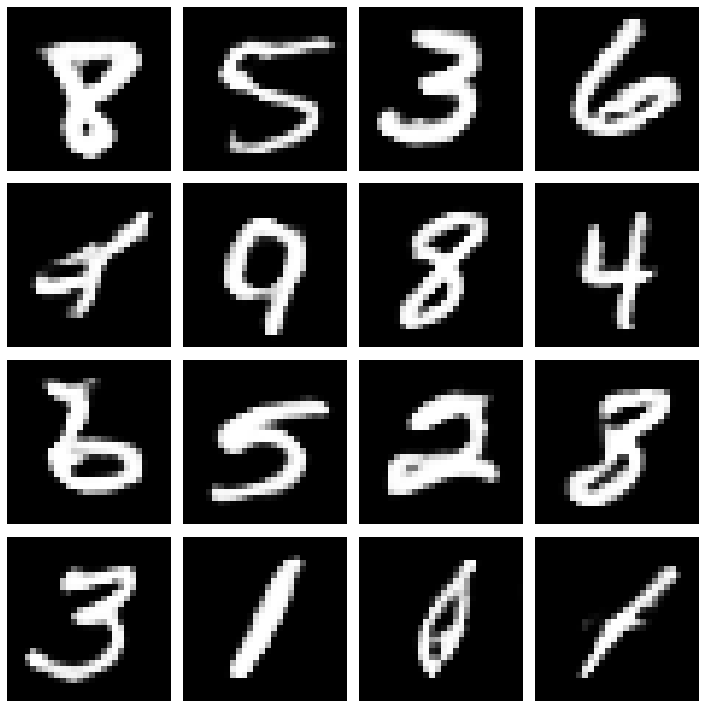

8499: [D loss: 0.702853, acc: 0.542969]  [A loss: 0.991108, acc: 0.105469]


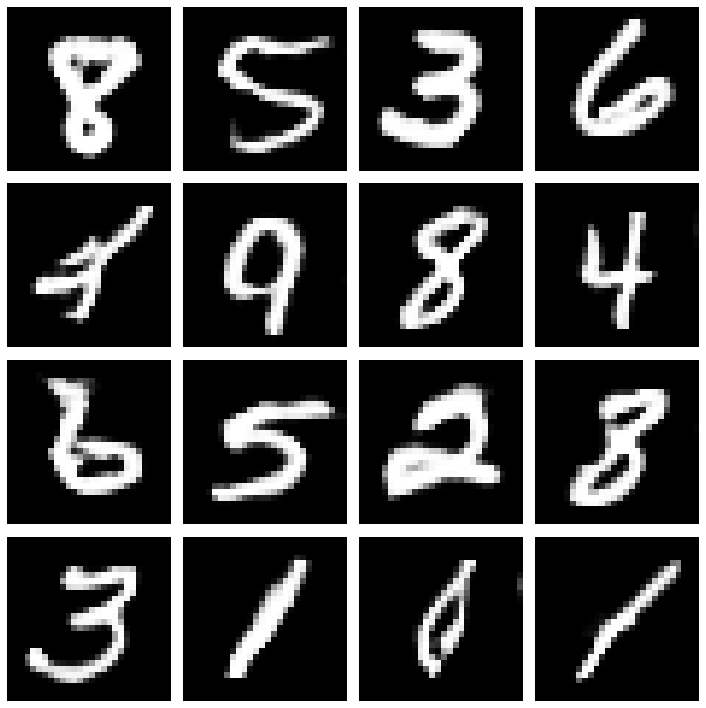

8999: [D loss: 0.688066, acc: 0.531250]  [A loss: 0.647717, acc: 0.644531]


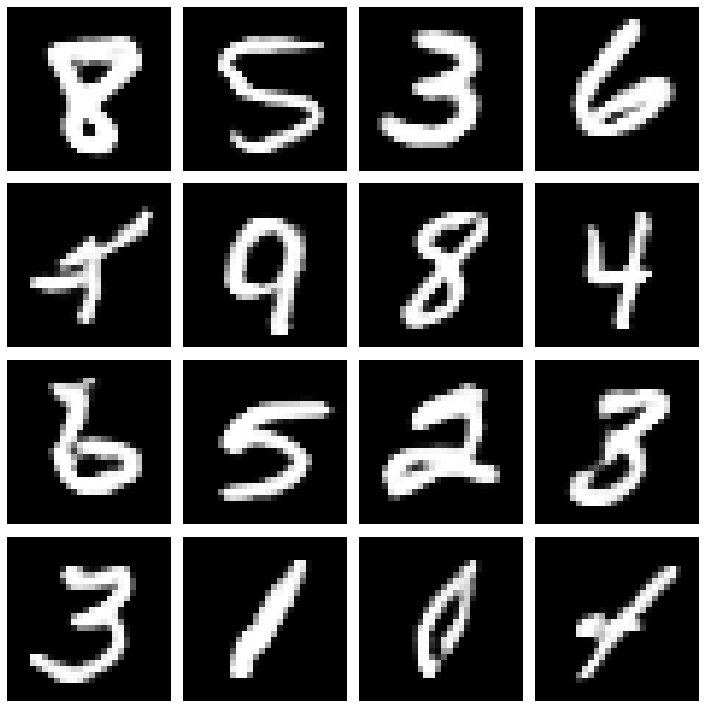

9499: [D loss: 0.660170, acc: 0.597656]  [A loss: 0.732194, acc: 0.468750]


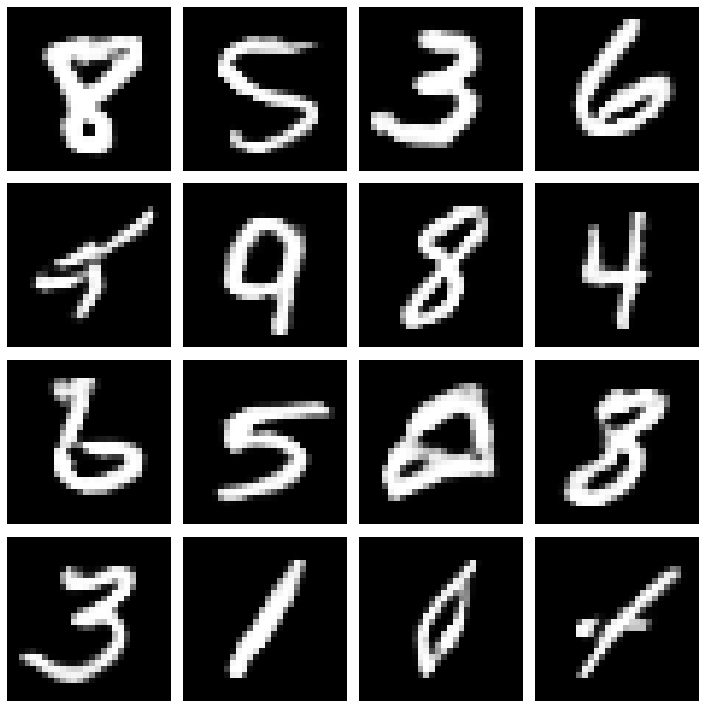

9999: [D loss: 0.663274, acc: 0.599609]  [A loss: 0.856272, acc: 0.265625]


In [ ]:
model.train(train_steps=10000, batch_size=256, save_interval=500)

In [ ]:
K.clear_session()
dropout = 0.4
depth = 64*4
dim = 7
z = 100

G = Sequential()
G.add(Dense(dim**2*depth, input_dim = z))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))
G.add(Reshape((dim,dim,depth)))
G.add(Dropout(dropout))

G.add(UpSampling2D())
G.add(Conv2DTranspose(int(depth/2), 5, padding = 'same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))

G.add(UpSampling2D())
G.add(Conv2DTranspose(int(depth/4), 5, padding = 'same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))

G.add(Conv2DTranspose(int(depth/8),5,padding = 'same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))

G.add(Conv2DTranspose(1, 5, padding = 'same'))
G.add(Activation('tanh'))
G.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_1 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)      

In [ ]:
depth = 64
input_shape = (28,28,1)

D = Sequential()
D.add(Conv2D(depth, 5, strides = 2, input_shape = input_shape))
D.add(LeakyReLU(alpha=0.2))
D.add(Dropout(dropout))

D.add(Conv2D(depth*2, 5, strides = 2, padding = 'same'))
D.add(LeakyReLU(alpha = 0.2))
D.add(Dropout(dropout))

D.add(Conv2D(depth*8, 5, strides = 1, padding = 'same'))
D.add(LeakyReLU(alpha = 0.2))
D.add(Dropout(dropout))

D.add(Flatten())
D.add(Dense(1, activation = 'sigmoid'))
D.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 12, 12, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 512)        

In [ ]:
model = GAN(G,D)
model.load_dataset()
model.preprocess_data(mode = DCGAN_TANH)
model.build()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         2394241   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1863937   
Total params: 4,258,178
Trainable params: 2,368,705
Non-trainable params: 1,889,473
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


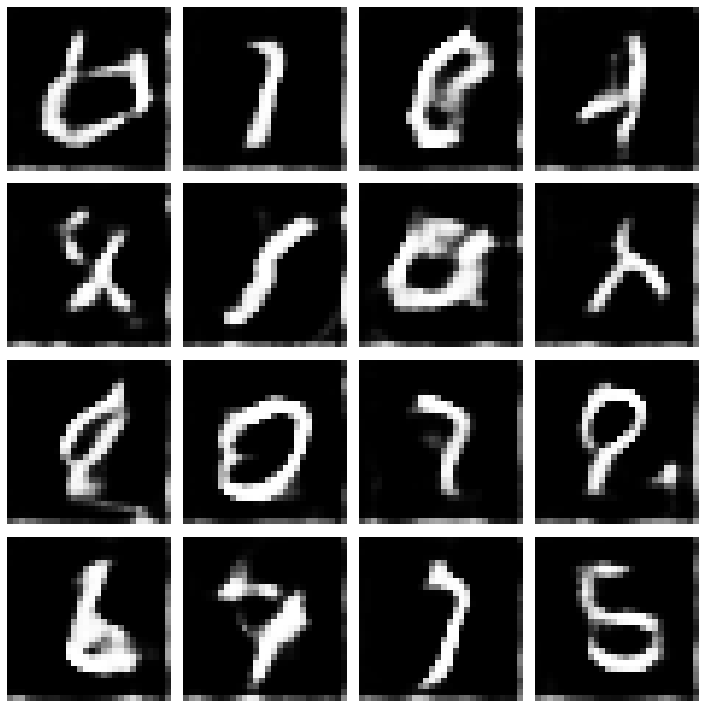

499: [D loss: 0.661203, acc: 0.601562]  [A loss: 0.731388, acc: 0.417969]


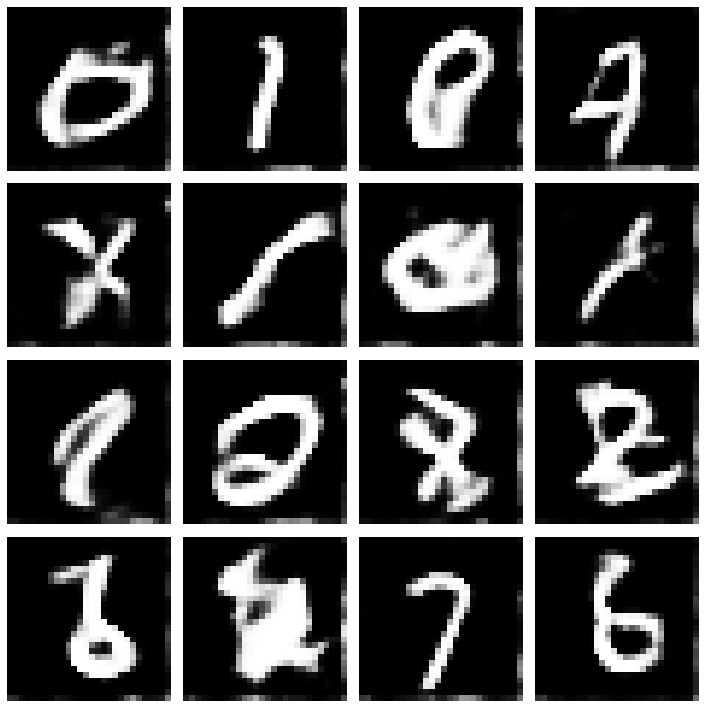

999: [D loss: 0.649261, acc: 0.619141]  [A loss: 1.035866, acc: 0.125000]


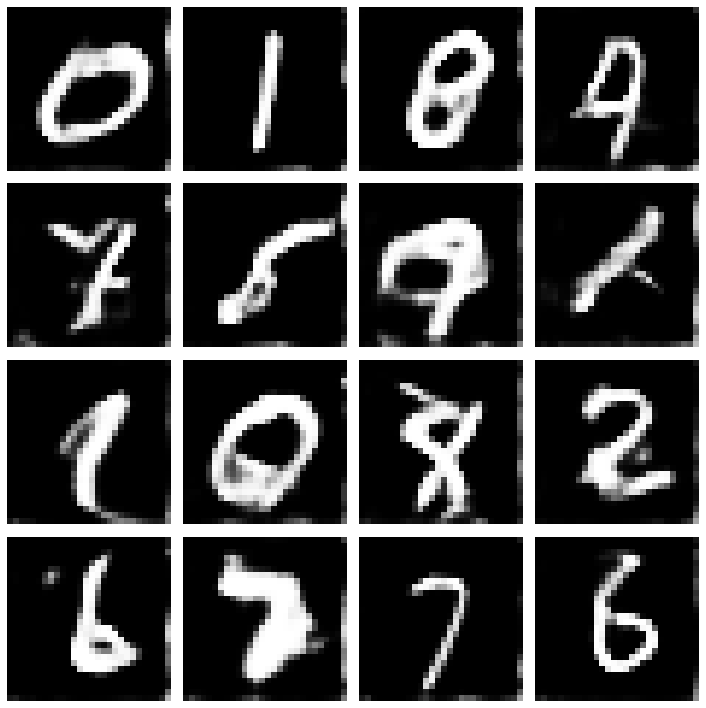

1499: [D loss: 0.621192, acc: 0.671875]  [A loss: 0.776294, acc: 0.402344]


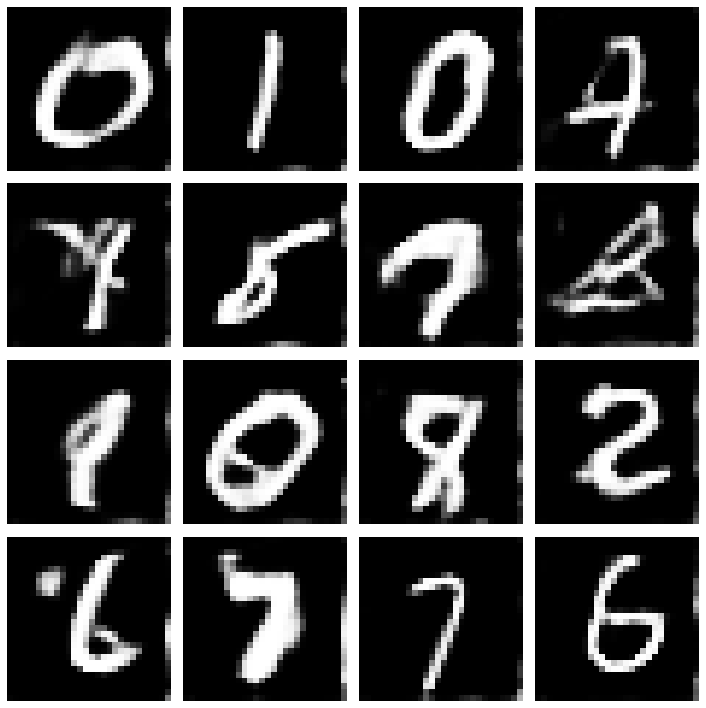

1999: [D loss: 0.649265, acc: 0.609375]  [A loss: 0.970178, acc: 0.171875]


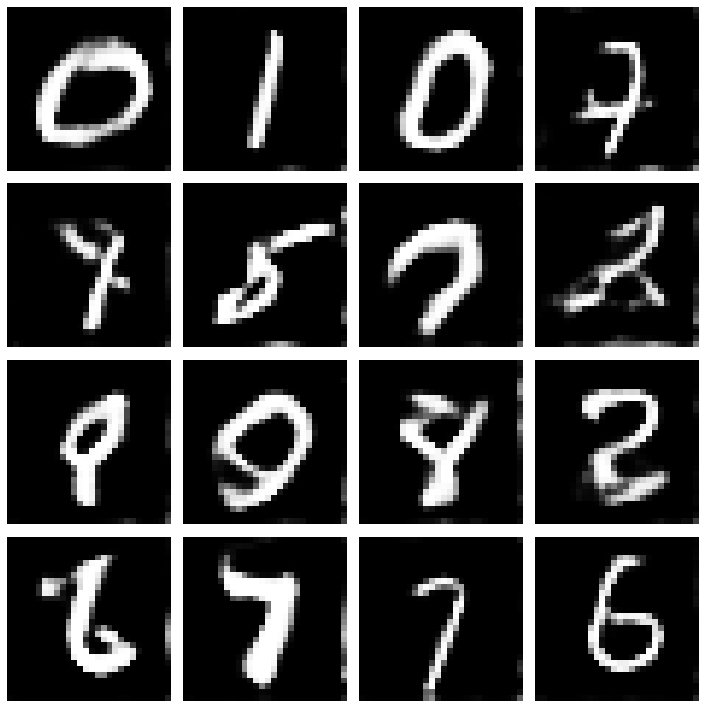

2499: [D loss: 0.667122, acc: 0.589844]  [A loss: 0.975954, acc: 0.164062]


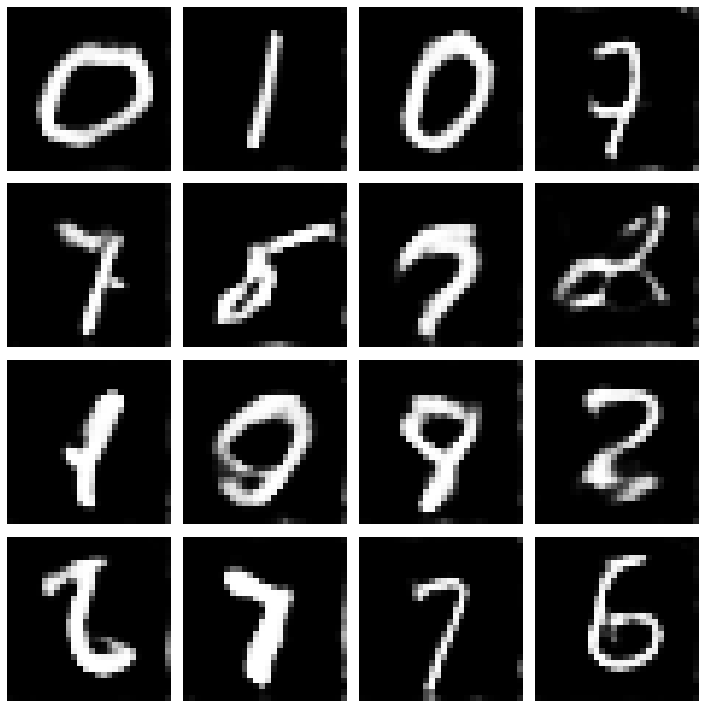

2999: [D loss: 0.642381, acc: 0.640625]  [A loss: 0.893612, acc: 0.210938]


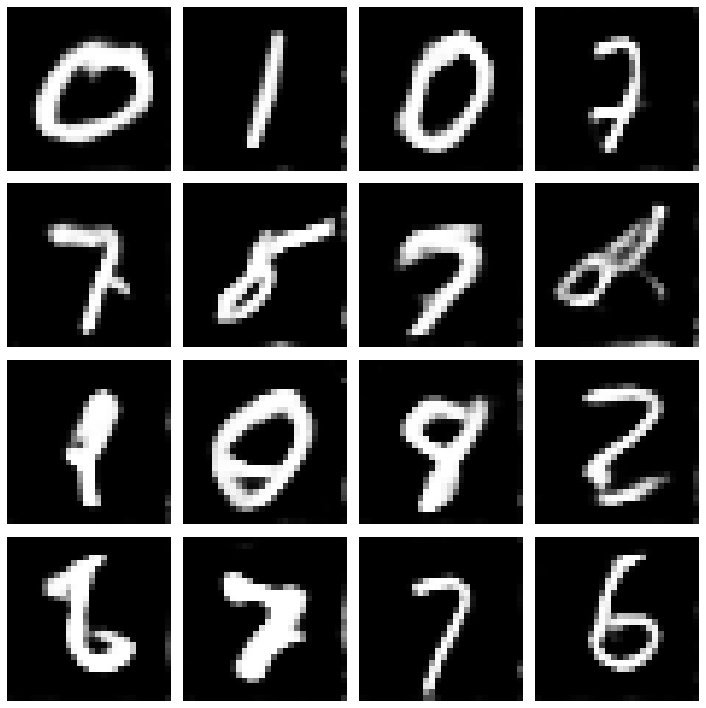

3499: [D loss: 0.653736, acc: 0.626953]  [A loss: 0.762329, acc: 0.421875]


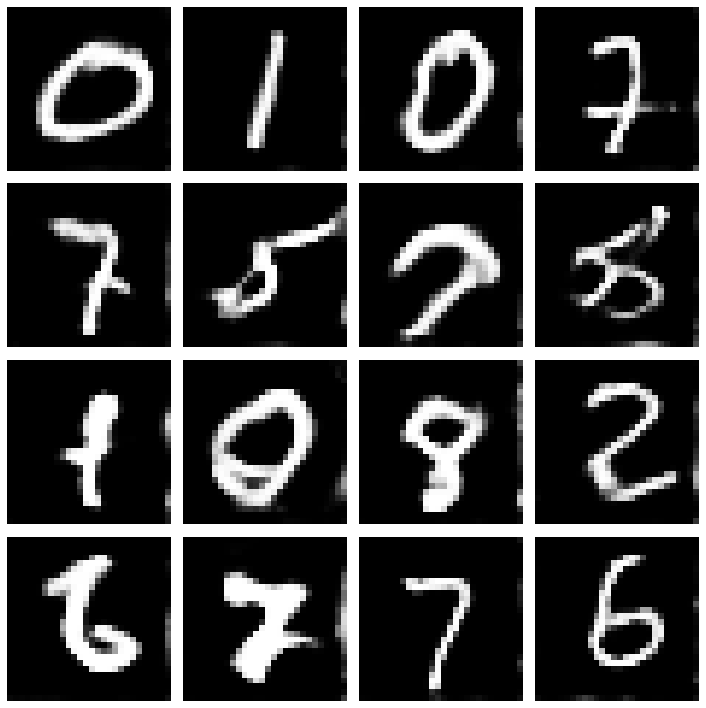

3999: [D loss: 0.676461, acc: 0.566406]  [A loss: 0.752853, acc: 0.414062]


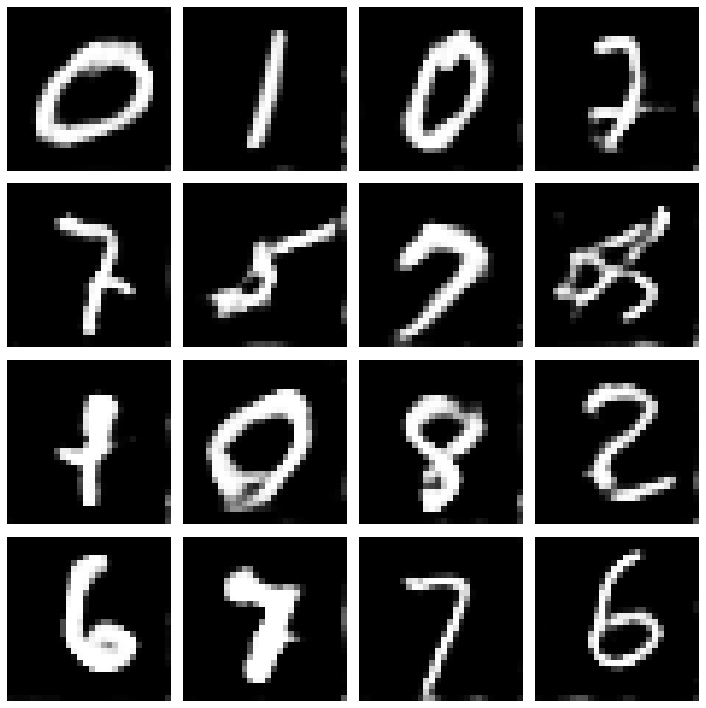

4499: [D loss: 0.655427, acc: 0.609375]  [A loss: 0.929589, acc: 0.175781]


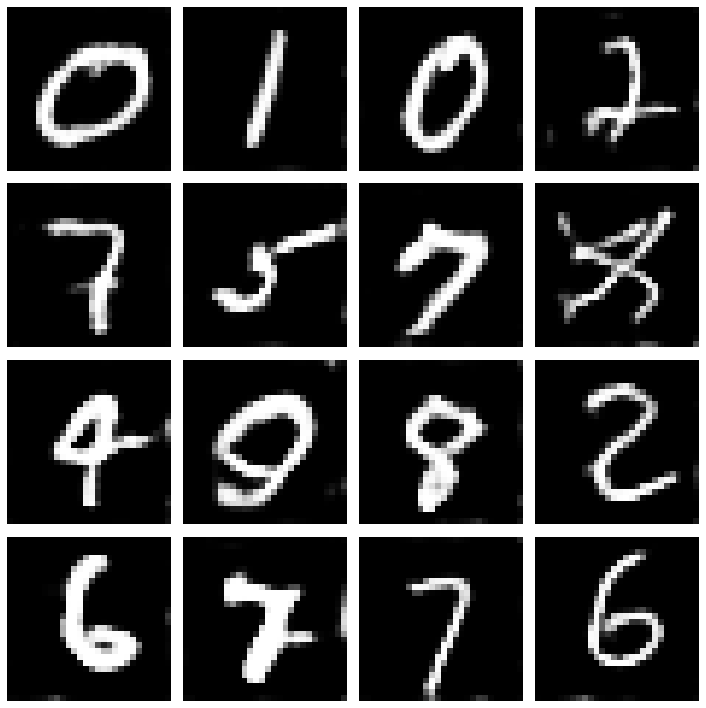

4999: [D loss: 0.653533, acc: 0.599609]  [A loss: 0.721432, acc: 0.507812]


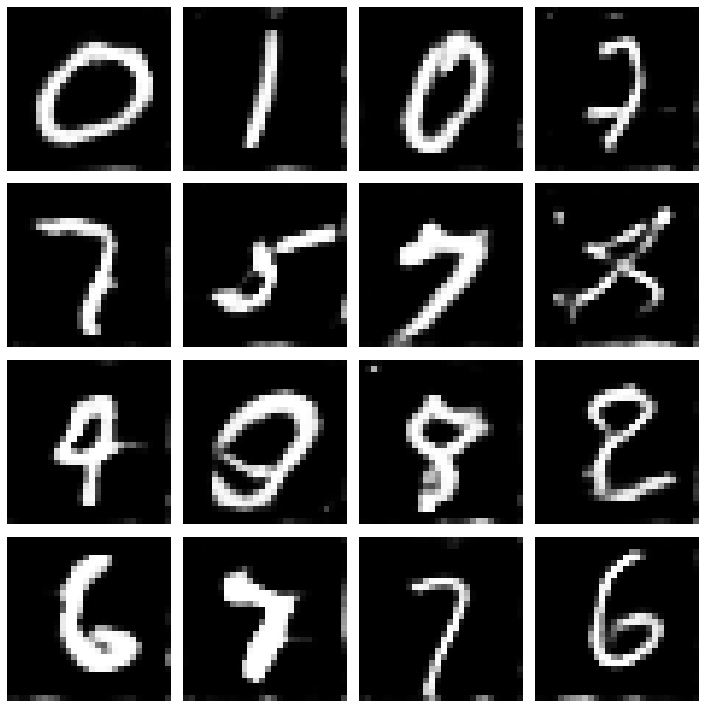

5499: [D loss: 0.672409, acc: 0.595703]  [A loss: 0.851822, acc: 0.242188]


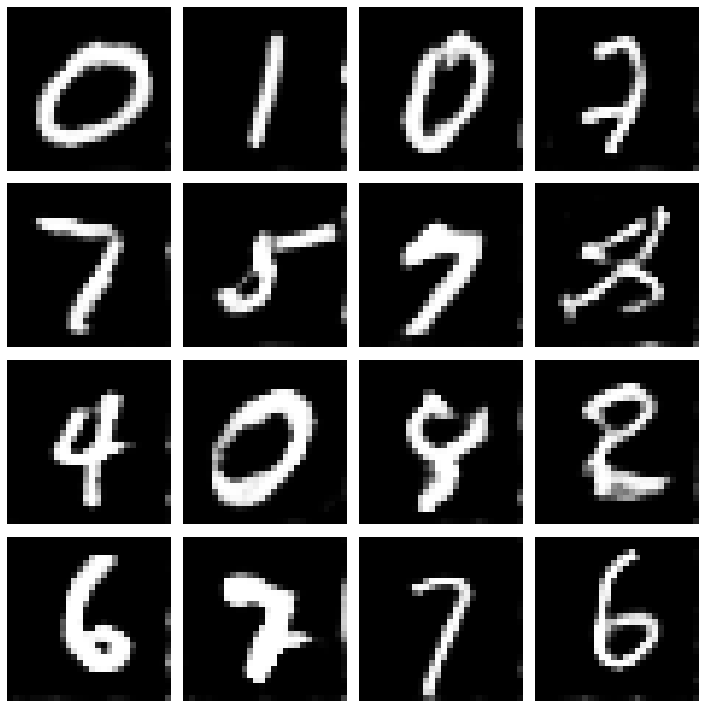

5999: [D loss: 0.637089, acc: 0.646484]  [A loss: 0.781905, acc: 0.378906]


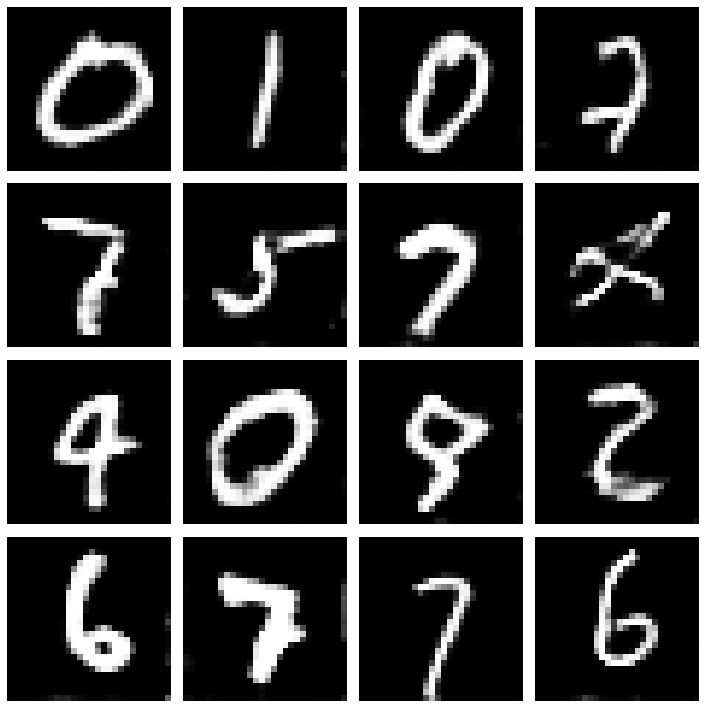

6499: [D loss: 0.667548, acc: 0.597656]  [A loss: 0.838195, acc: 0.292969]


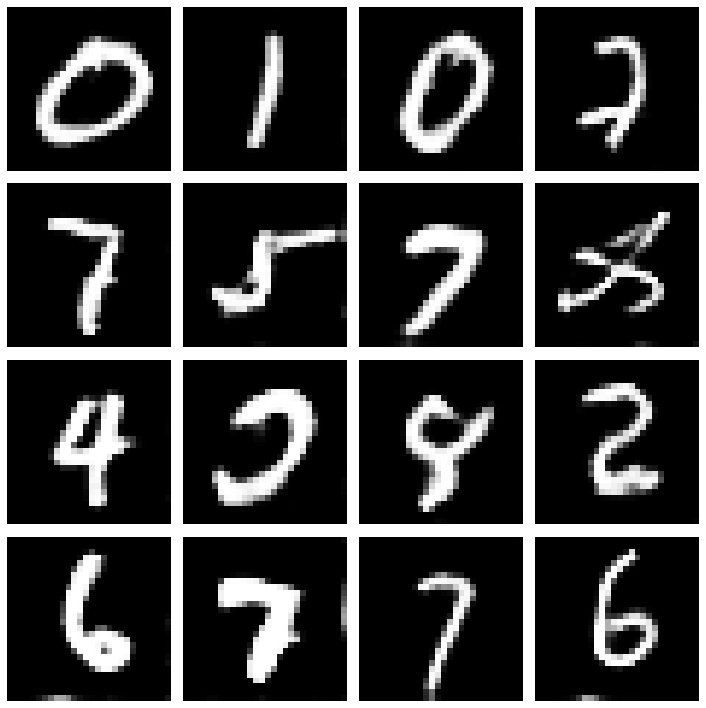

6999: [D loss: 0.662221, acc: 0.593750]  [A loss: 0.865261, acc: 0.257812]


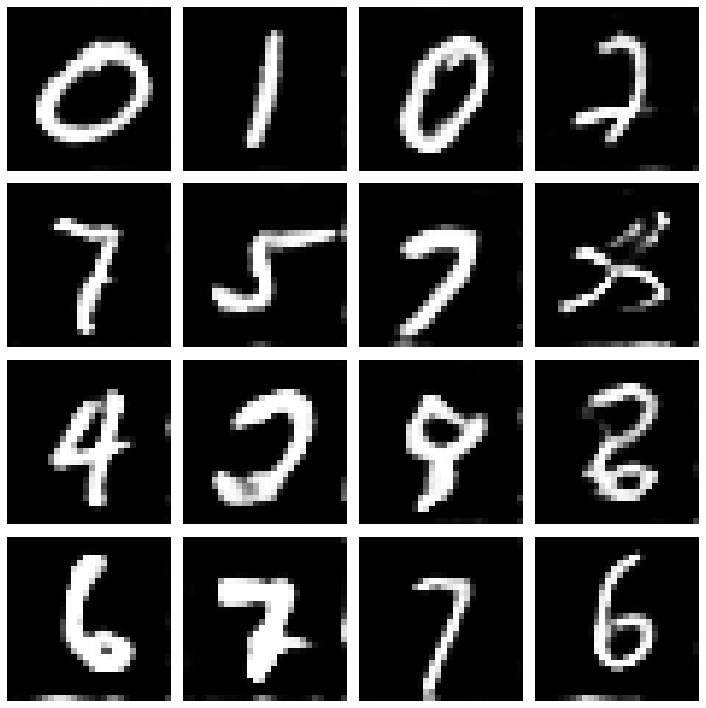

7499: [D loss: 0.674973, acc: 0.578125]  [A loss: 0.874850, acc: 0.222656]


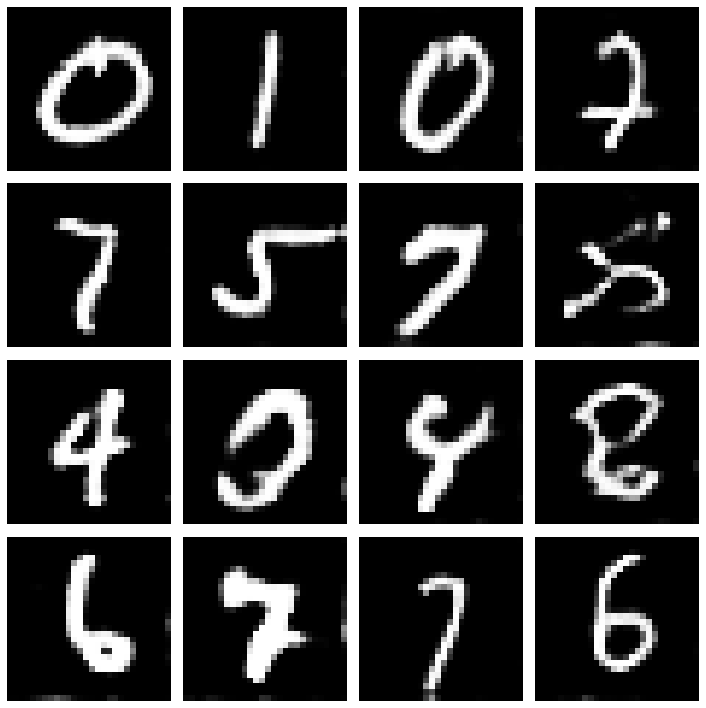

7999: [D loss: 0.666431, acc: 0.609375]  [A loss: 0.759266, acc: 0.406250]


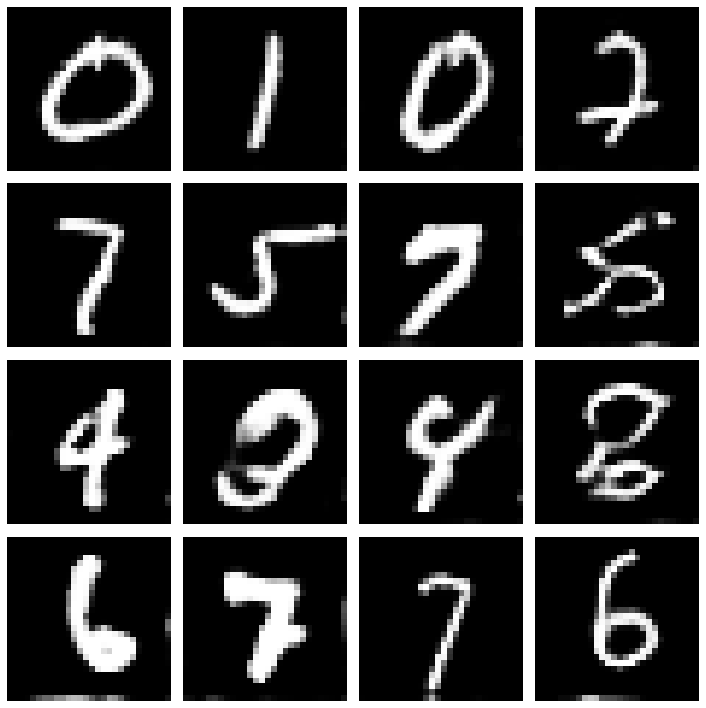

8499: [D loss: 0.661438, acc: 0.615234]  [A loss: 0.738970, acc: 0.449219]


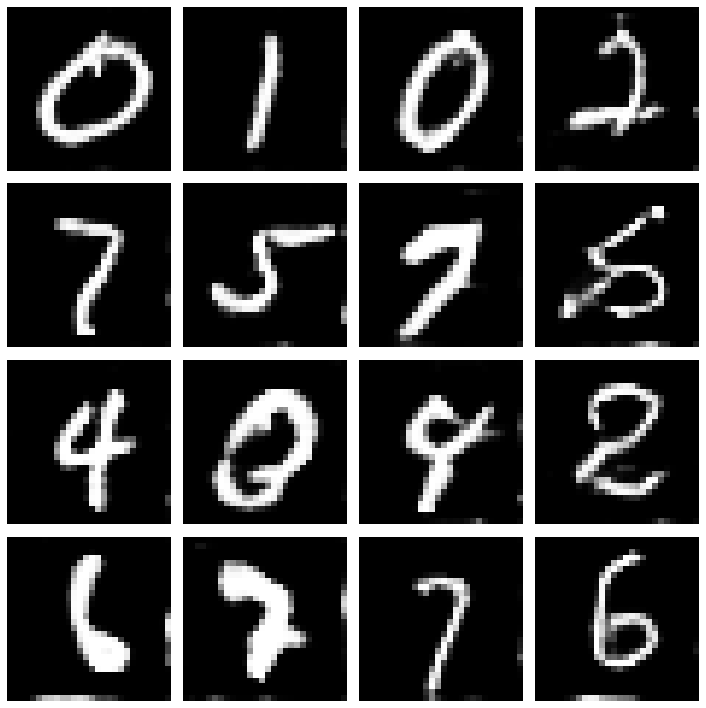

8999: [D loss: 0.682536, acc: 0.562500]  [A loss: 0.782404, acc: 0.406250]


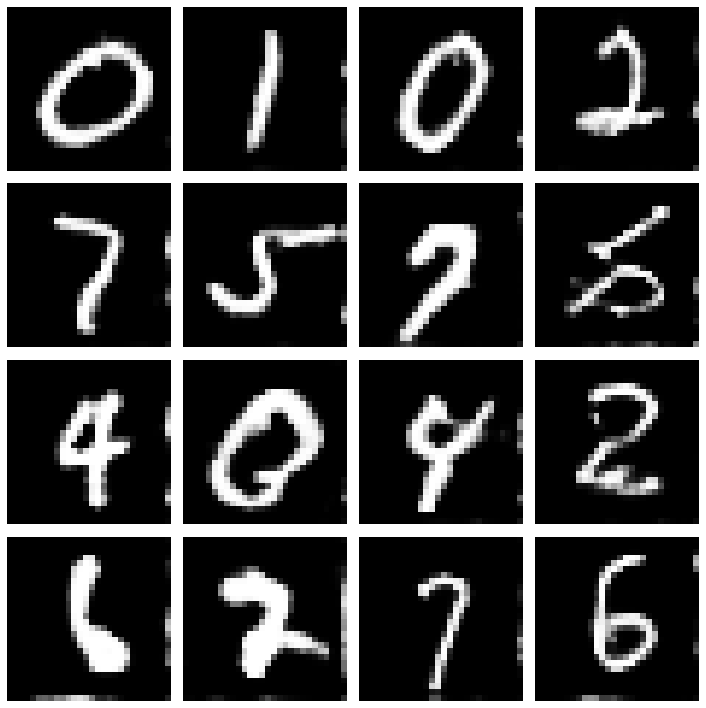

9499: [D loss: 0.673231, acc: 0.585938]  [A loss: 0.836877, acc: 0.277344]


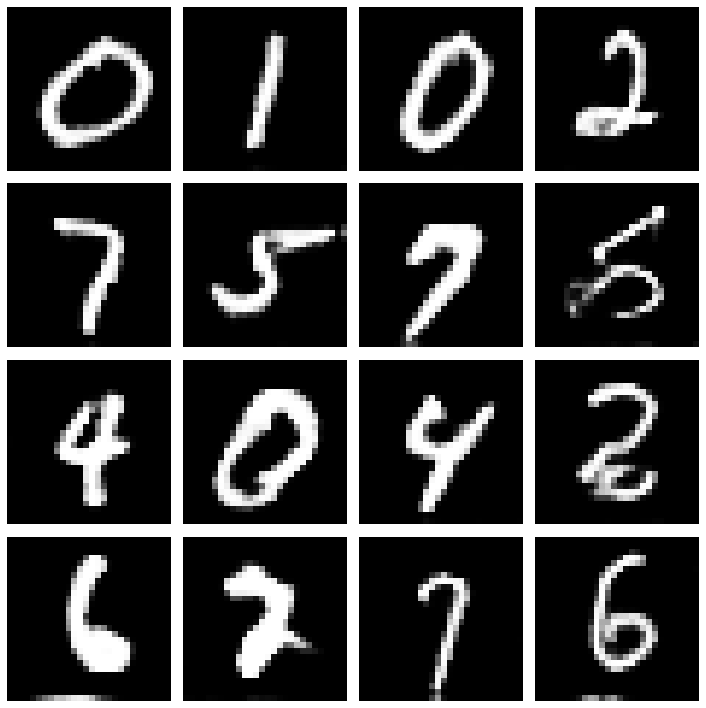

9999: [D loss: 0.648612, acc: 0.599609]  [A loss: 0.852491, acc: 0.289062]


In [ ]:
model.train(train_steps=10000, batch_size=256, save_interval=500)

In [ ]:
K.clear_session()
dropout = 0.4
depth = 64*4
dim = 7
z = 100
G = Sequential()
G.add(Dense(dim**2*depth, input_dim = z))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))
G.add(Reshape((dim,dim,depth)))
G.add(Dropout(dropout))

G.add(UpSampling2D())
G.add(Conv2D(int(depth/2), 5, padding = 'same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))

G.add(UpSampling2D())
G.add(Conv2D(int(depth/4), 5, padding = 'same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))

G.add(Conv2D(int(depth/8),5,padding = 'same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))

G.add(Conv2D(1, 5, padding = 'same'))
G.add(Activation('sigmoid'))
G.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_1 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)      

In [ ]:
depth = 64
input_shape = (28,28,1)

D = Sequential()
D.add(Conv2D(depth, 5, strides = 2, input_shape = input_shape))
D.add(LeakyReLU(alpha=0.2))
D.add(Dropout(dropout))

D.add(Conv2D(depth*2, 5, strides = 2, padding = 'same'))
D.add(LeakyReLU(alpha = 0.2))
D.add(Dropout(dropout))

D.add(Conv2D(depth*8, 5, strides = 1, padding = 'same'))
D.add(LeakyReLU(alpha = 0.2))
D.add(Dropout(dropout))

D.add(Flatten())
D.add(Dense(1, activation = 'sigmoid'))
D.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 12, 12, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 512)        

In [ ]:
model = GAN(G,D)
model.load_dataset()
model.preprocess_data(mode = DCGAN_SIGMOID)
model.build()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         2394241   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1863937   
Total params: 4,258,178
Trainable params: 2,368,705
Non-trainable params: 1,889,473
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


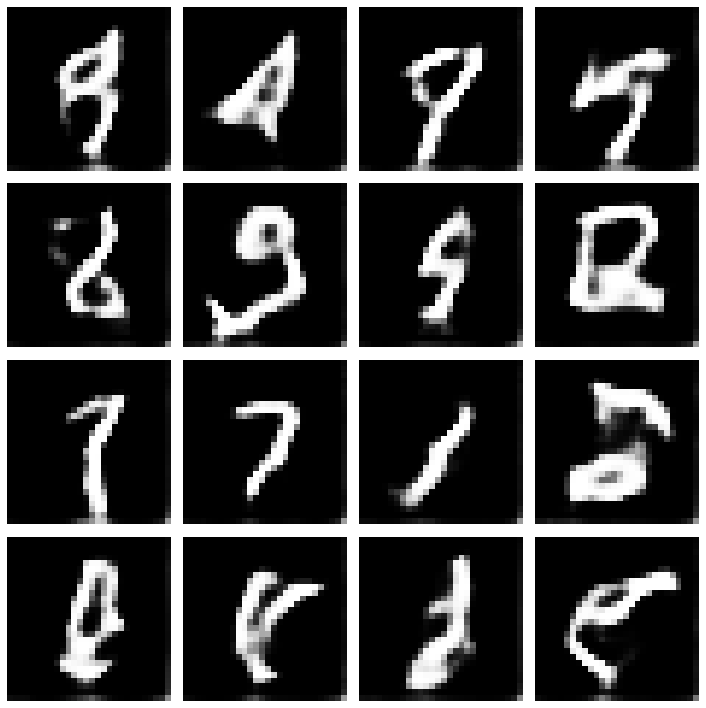

499: [D loss: 0.670842, acc: 0.613281]  [A loss: 0.752081, acc: 0.339844]


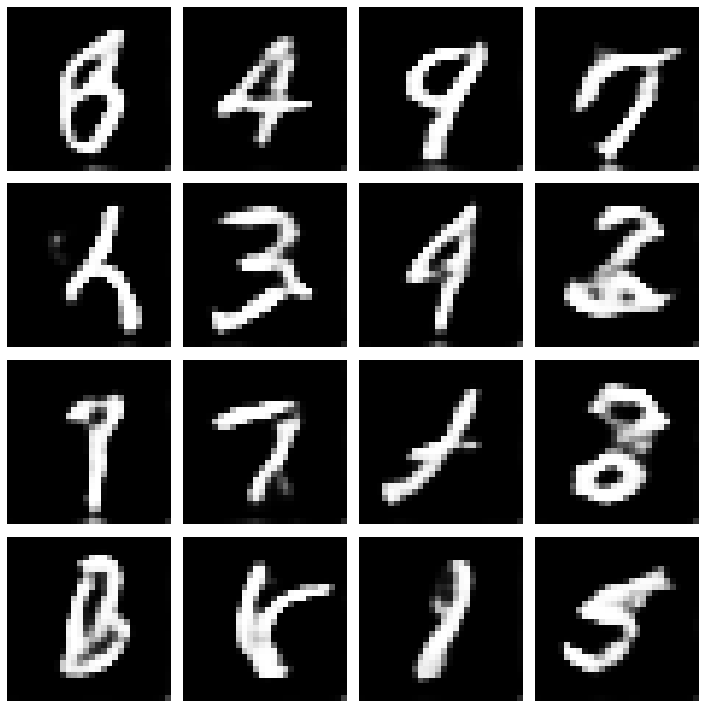

999: [D loss: 0.659352, acc: 0.615234]  [A loss: 0.856112, acc: 0.234375]


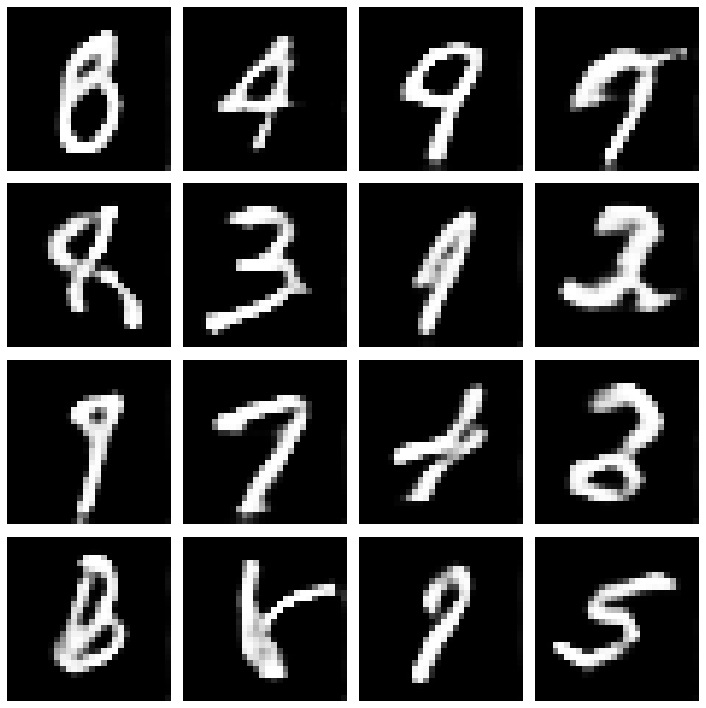

1499: [D loss: 0.651252, acc: 0.626953]  [A loss: 0.924905, acc: 0.164062]


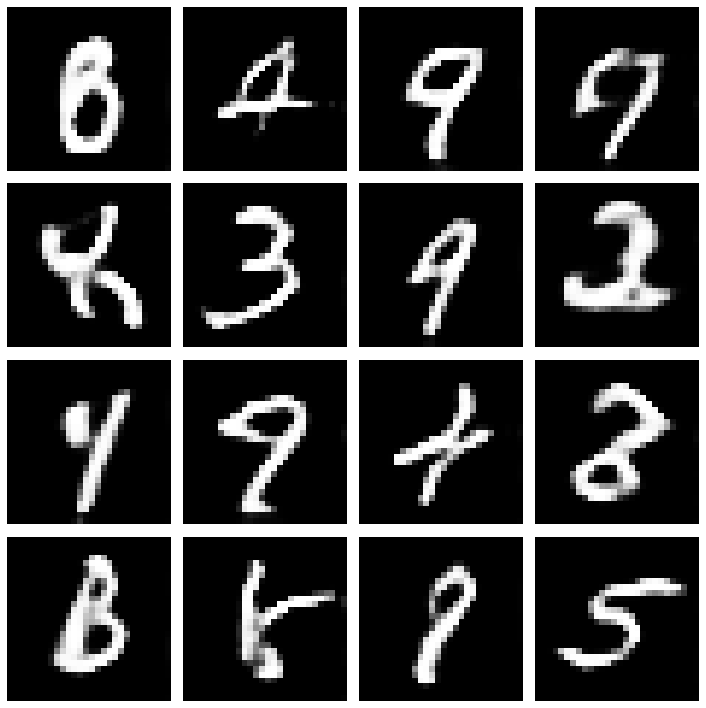

1999: [D loss: 0.664119, acc: 0.611328]  [A loss: 1.006237, acc: 0.113281]


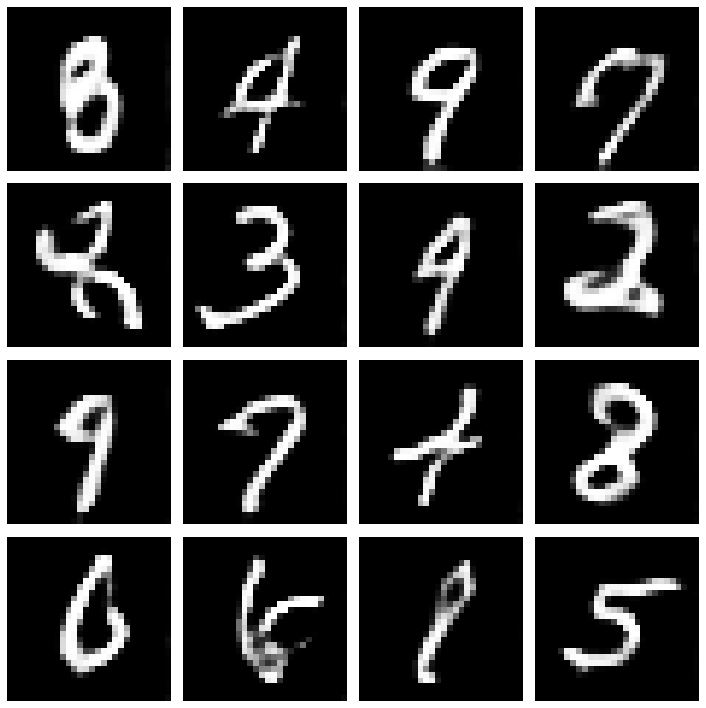

2499: [D loss: 0.661932, acc: 0.611328]  [A loss: 0.896722, acc: 0.199219]


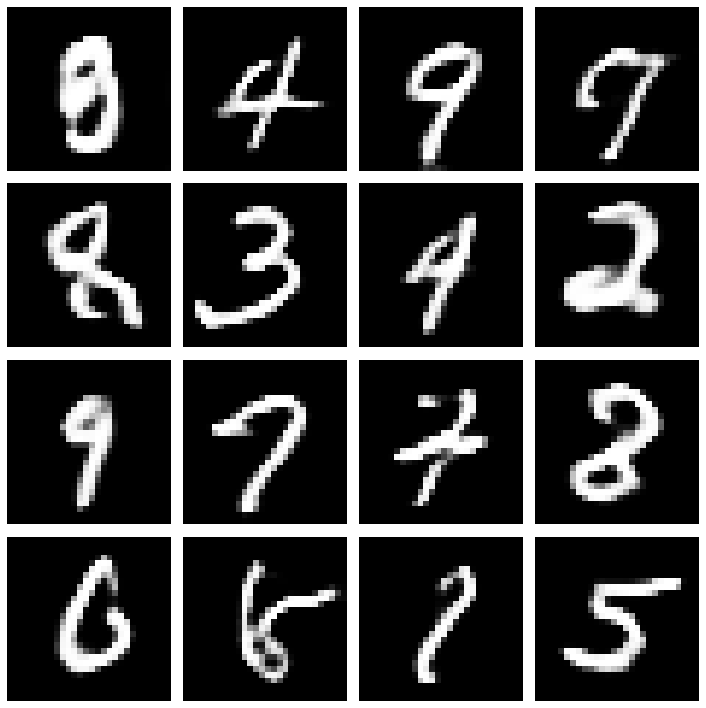

2999: [D loss: 0.659087, acc: 0.601562]  [A loss: 0.715537, acc: 0.507812]


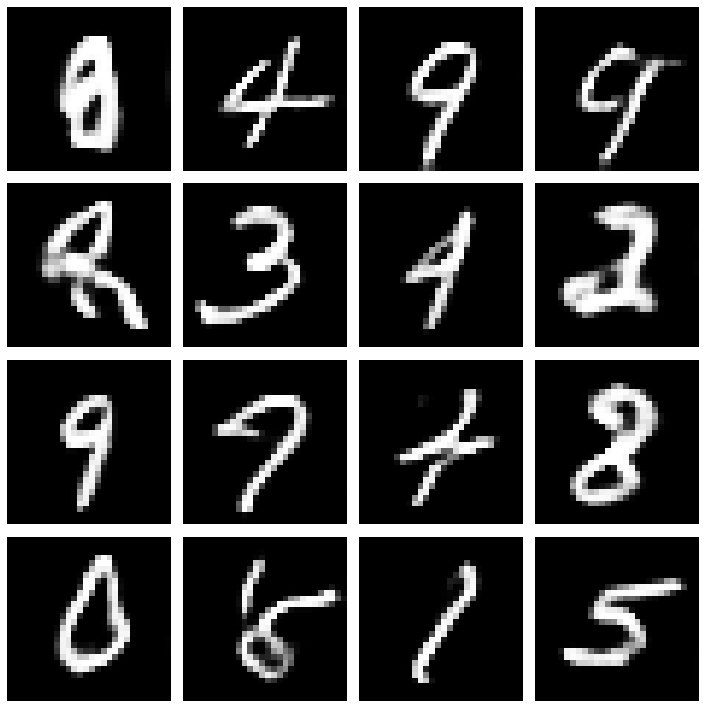

3499: [D loss: 0.663295, acc: 0.591797]  [A loss: 0.819960, acc: 0.289062]


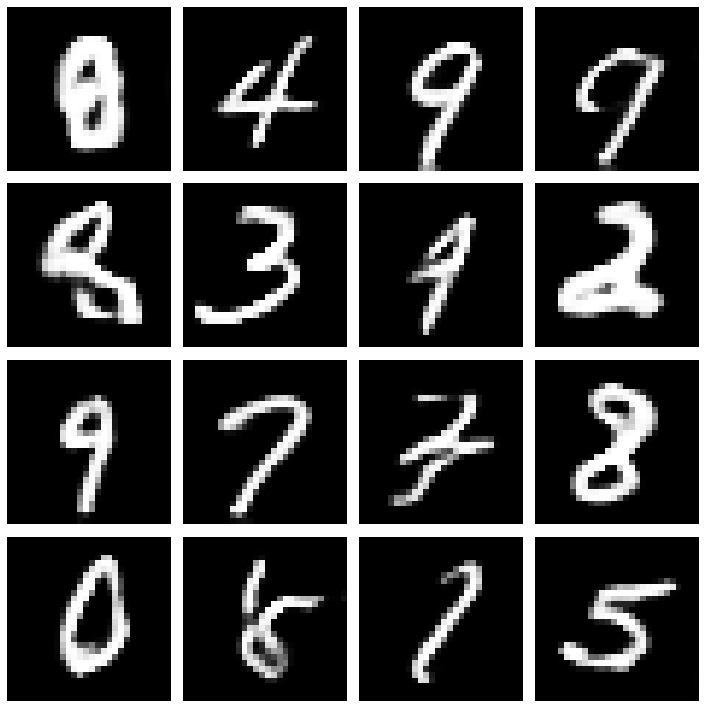

3999: [D loss: 0.671788, acc: 0.574219]  [A loss: 0.788543, acc: 0.351562]


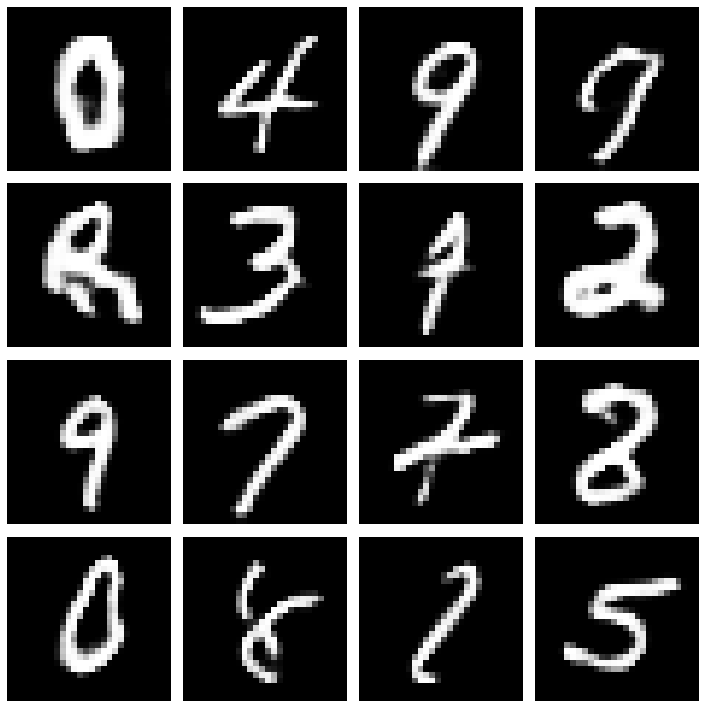

4499: [D loss: 0.673605, acc: 0.582031]  [A loss: 0.840678, acc: 0.250000]


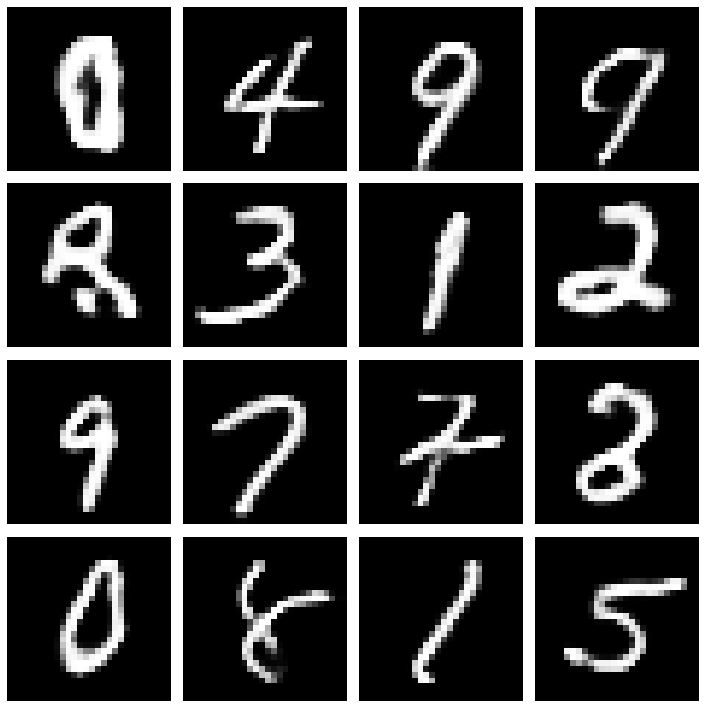

4999: [D loss: 0.689240, acc: 0.554688]  [A loss: 0.867240, acc: 0.175781]


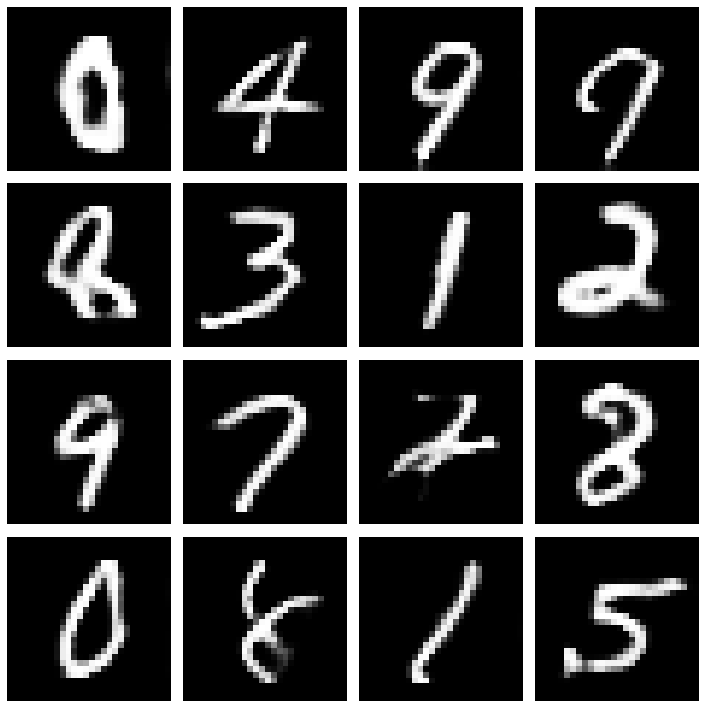

5499: [D loss: 0.659837, acc: 0.589844]  [A loss: 0.790288, acc: 0.312500]


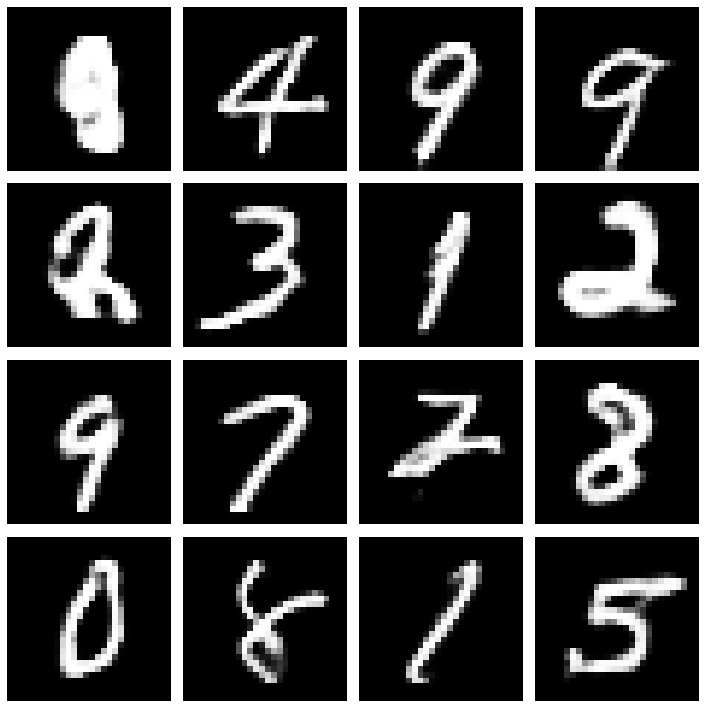

5999: [D loss: 0.677072, acc: 0.560547]  [A loss: 0.772494, acc: 0.324219]


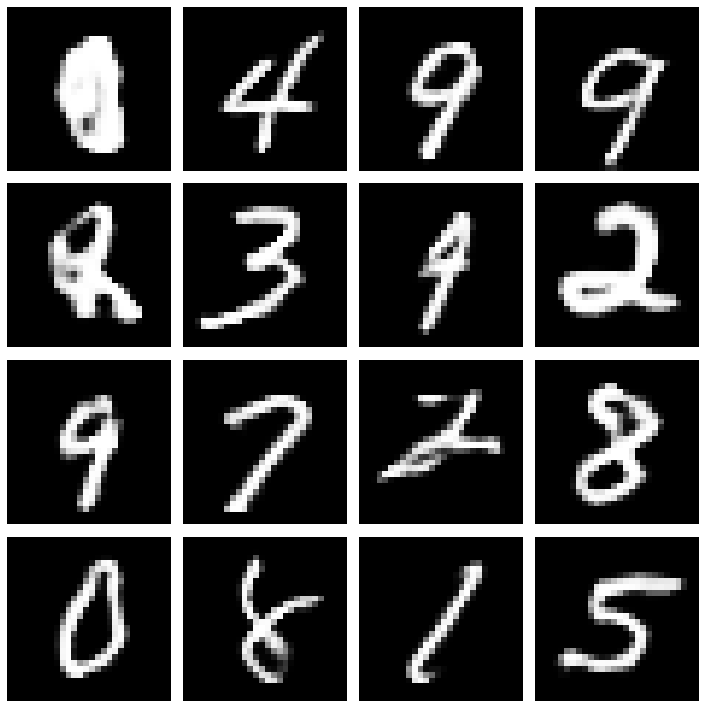

6499: [D loss: 0.670416, acc: 0.595703]  [A loss: 0.826350, acc: 0.261719]


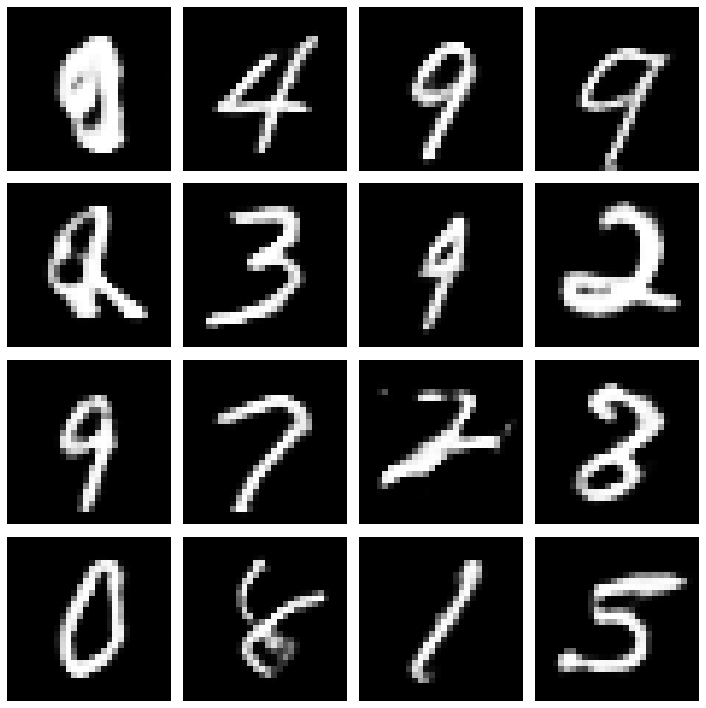

6999: [D loss: 0.696164, acc: 0.509766]  [A loss: 0.842228, acc: 0.250000]


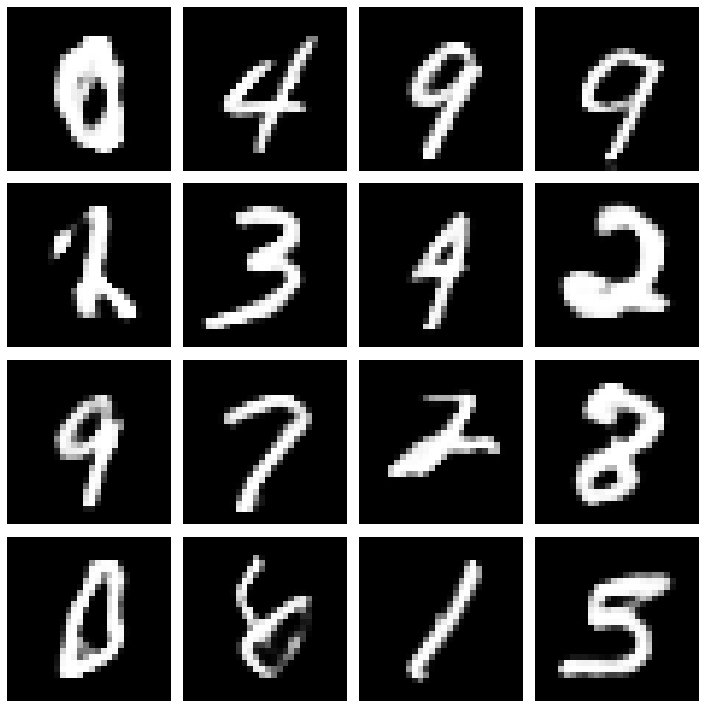

7499: [D loss: 0.659999, acc: 0.626953]  [A loss: 0.850822, acc: 0.238281]


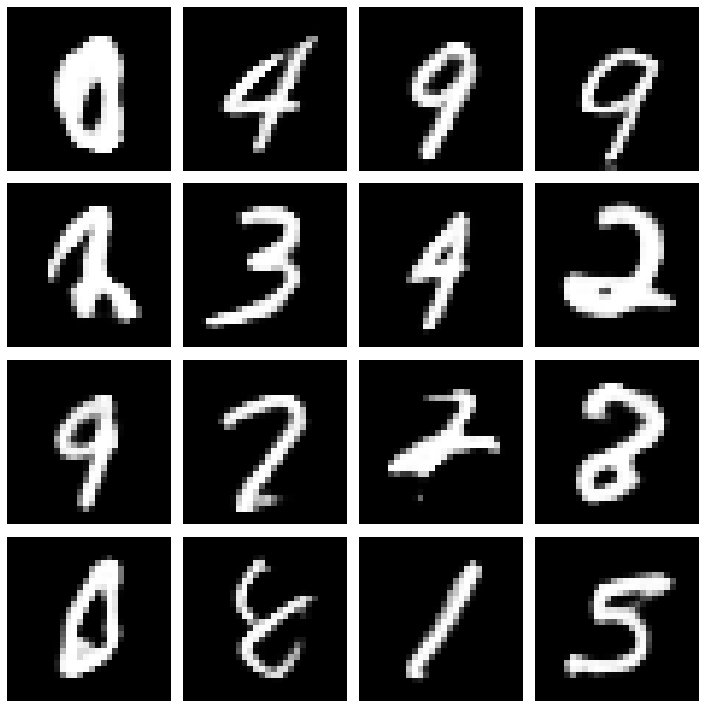

7999: [D loss: 0.663975, acc: 0.603516]  [A loss: 0.818232, acc: 0.300781]


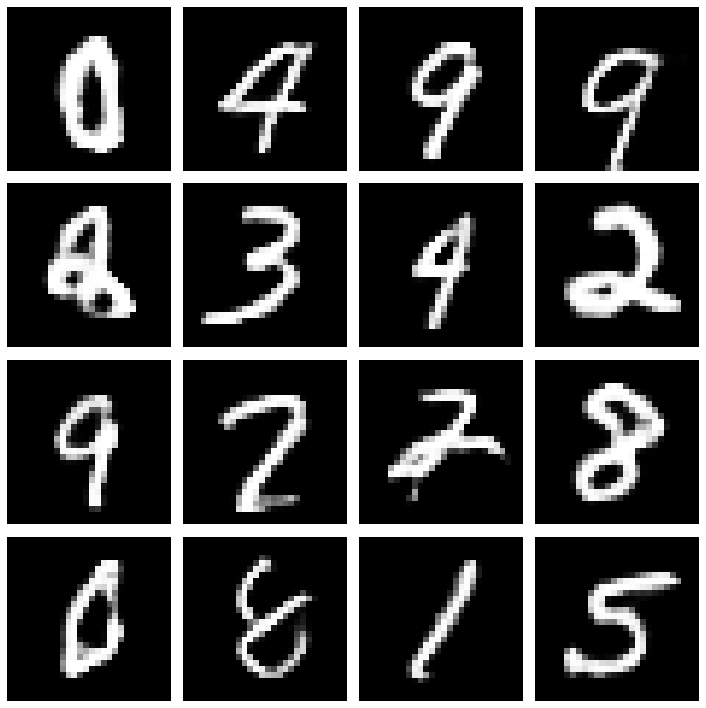

8499: [D loss: 0.673359, acc: 0.587891]  [A loss: 0.729482, acc: 0.453125]


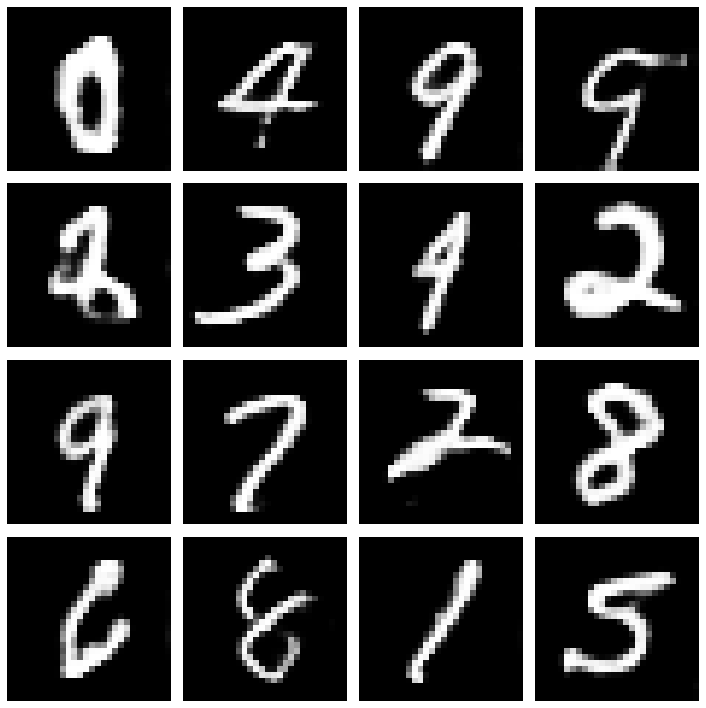

8999: [D loss: 0.650498, acc: 0.626953]  [A loss: 0.866086, acc: 0.226562]


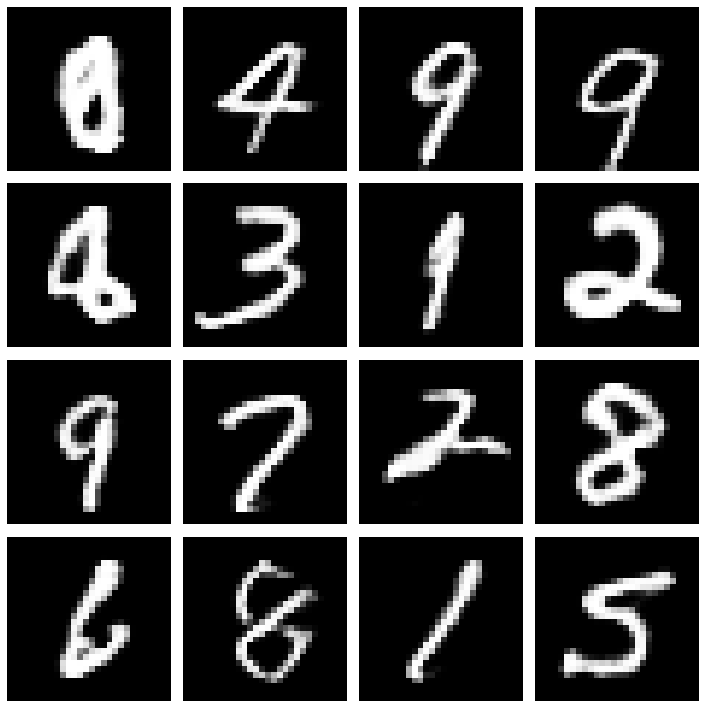

9499: [D loss: 0.680137, acc: 0.566406]  [A loss: 0.850437, acc: 0.242188]


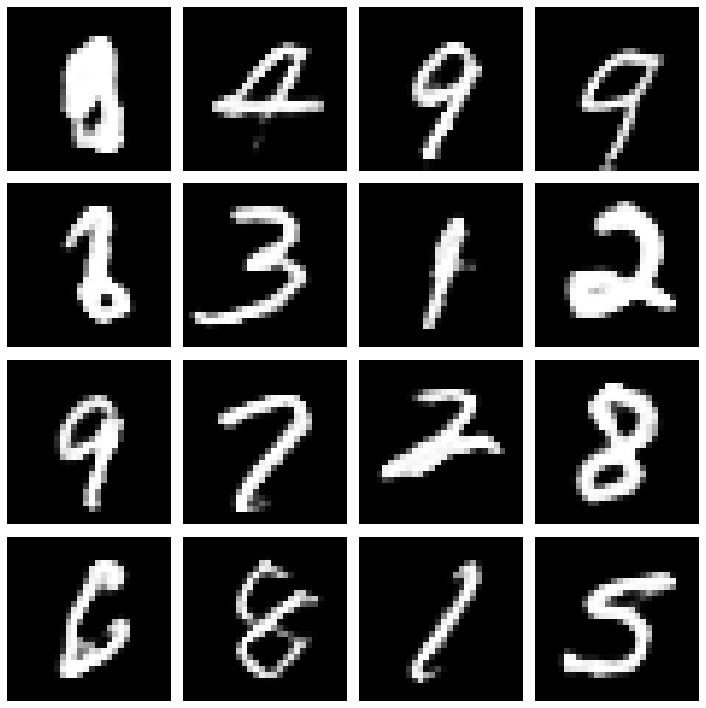

9999: [D loss: 0.657043, acc: 0.609375]  [A loss: 0.798417, acc: 0.316406]


In [ ]:
model.train(train_steps=10000, batch_size=256, save_interval=500)

In [ ]:
K.clear_session()
dropout = 0.4
depth = 64*4
dim = 7
z = 100
G = Sequential()
G.add(Dense(dim**2*depth, input_dim = z))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))
G.add(Reshape((dim,dim,depth)))
G.add(Dropout(dropout))

G.add(UpSampling2D())
G.add(Conv2D(int(depth/2), 5, padding = 'same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))

G.add(UpSampling2D())
G.add(Conv2D(int(depth/4), 5, padding = 'same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))

G.add(Conv2D(int(depth/8),5,padding = 'same'))
G.add(BatchNormalization(momentum=0.9))
G.add(Activation('relu'))

G.add(Conv2D(1, 5, padding = 'same'))
G.add(Activation('tanh'))
G.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_1 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)      

In [ ]:
depth = 64
input_shape = (28,28,1)

D = Sequential()
D.add(Conv2D(depth, 5, strides = 2, input_shape = input_shape))
D.add(LeakyReLU(alpha=0.2))
D.add(Dropout(dropout))

D.add(Conv2D(depth*2, 5, strides = 2, padding = 'same'))
D.add(LeakyReLU(alpha = 0.2))
D.add(Dropout(dropout))

D.add(Conv2D(depth*8, 5, strides = 1, padding = 'same'))
D.add(LeakyReLU(alpha = 0.2))
D.add(Dropout(dropout))

D.add(Flatten())
D.add(Dense(1, activation = 'sigmoid'))
D.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 12, 12, 64)        1664      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 512)        

In [ ]:
model = GAN(G,D)
model.load_dataset()
model.preprocess_data(mode = DCGAN_TANH)
model.build()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         2394241   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1863937   
Total params: 4,258,178
Trainable params: 2,368,705
Non-trainable params: 1,889,473
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


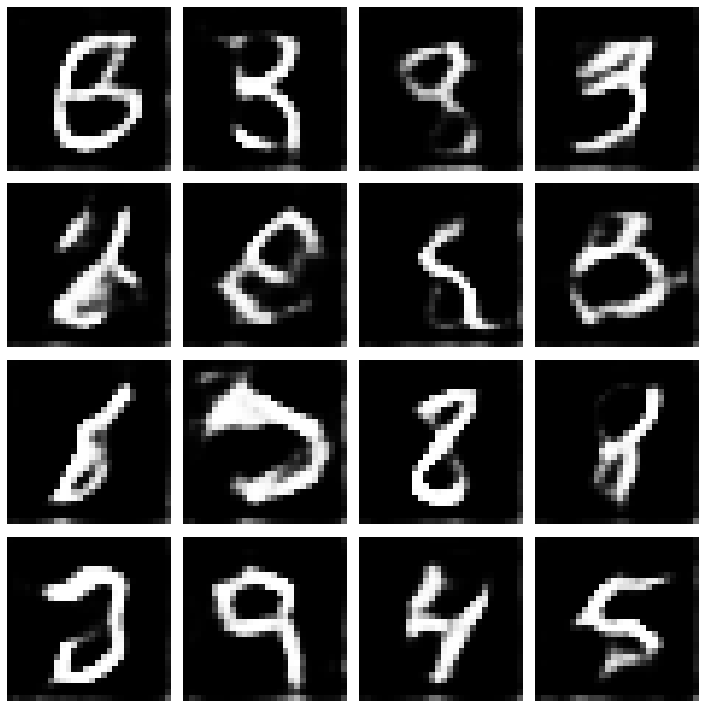

499: [D loss: 0.655392, acc: 0.601562]  [A loss: 0.849082, acc: 0.222656]


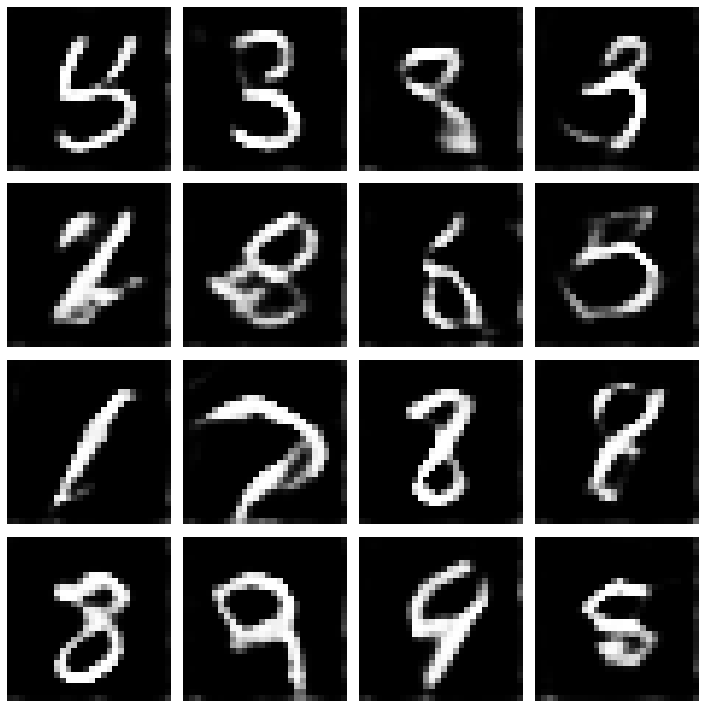

999: [D loss: 0.626805, acc: 0.648438]  [A loss: 0.976108, acc: 0.171875]


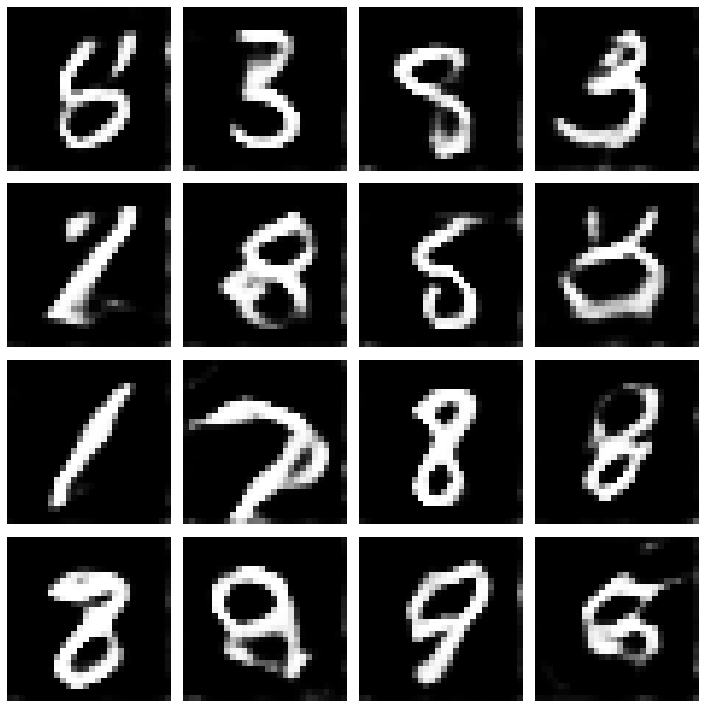

1499: [D loss: 0.616638, acc: 0.671875]  [A loss: 0.787481, acc: 0.402344]


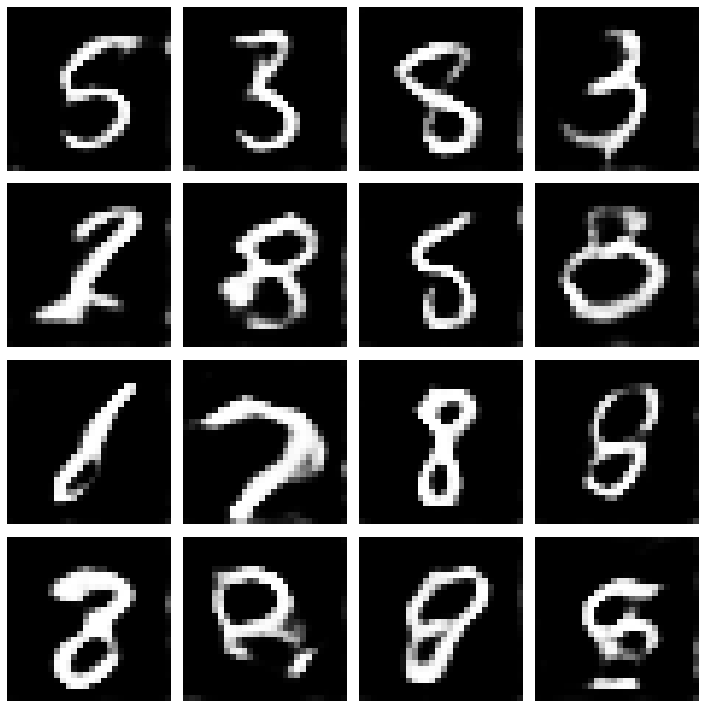

1999: [D loss: 0.639893, acc: 0.640625]  [A loss: 0.771137, acc: 0.449219]


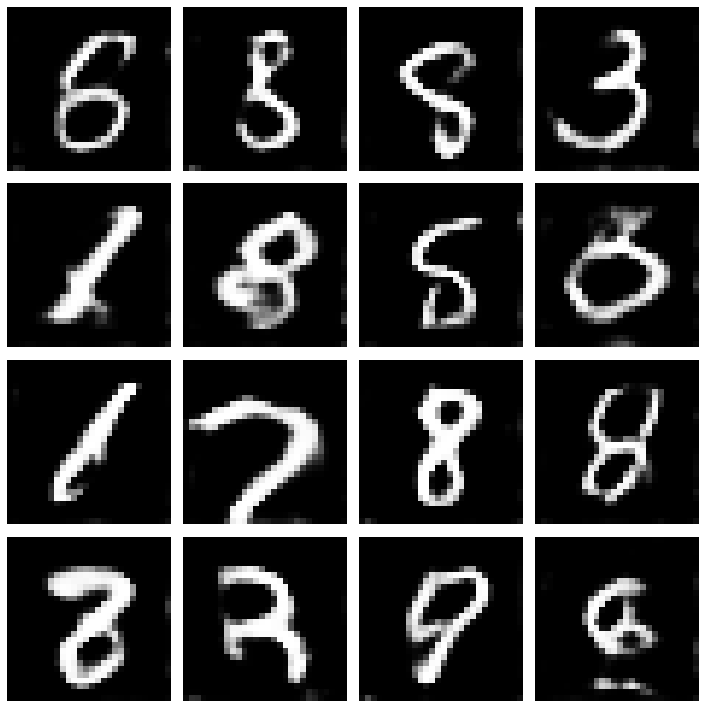

2499: [D loss: 0.651993, acc: 0.634766]  [A loss: 0.888608, acc: 0.246094]


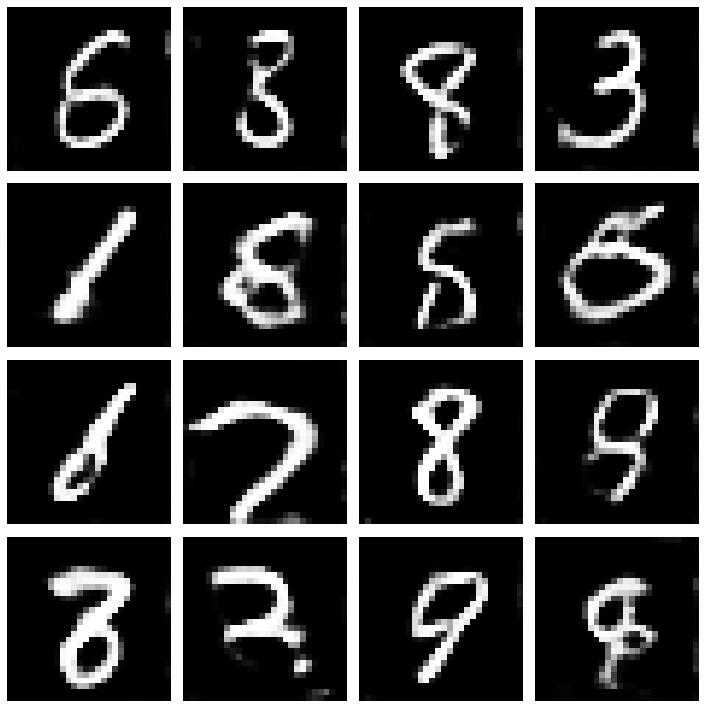

2999: [D loss: 0.676130, acc: 0.576172]  [A loss: 0.675204, acc: 0.585938]


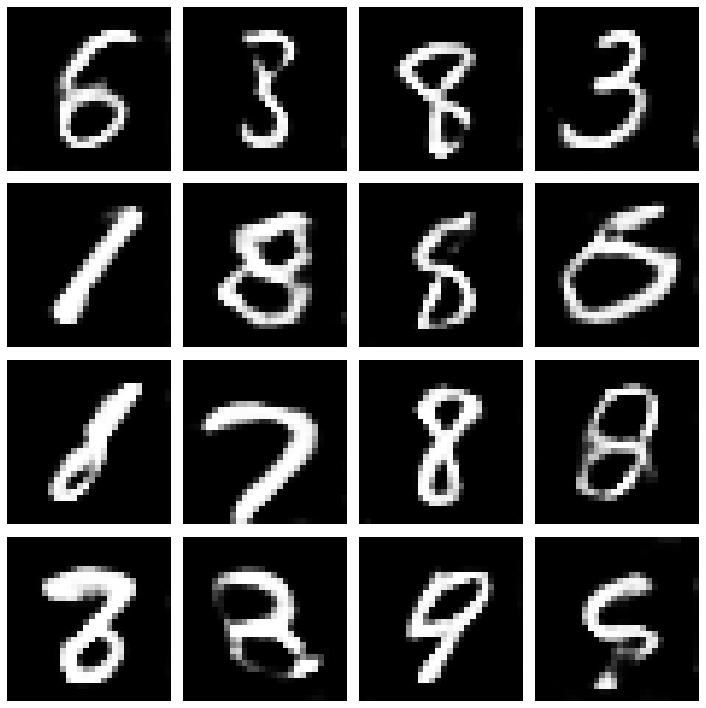

3499: [D loss: 0.659906, acc: 0.601562]  [A loss: 0.844472, acc: 0.281250]


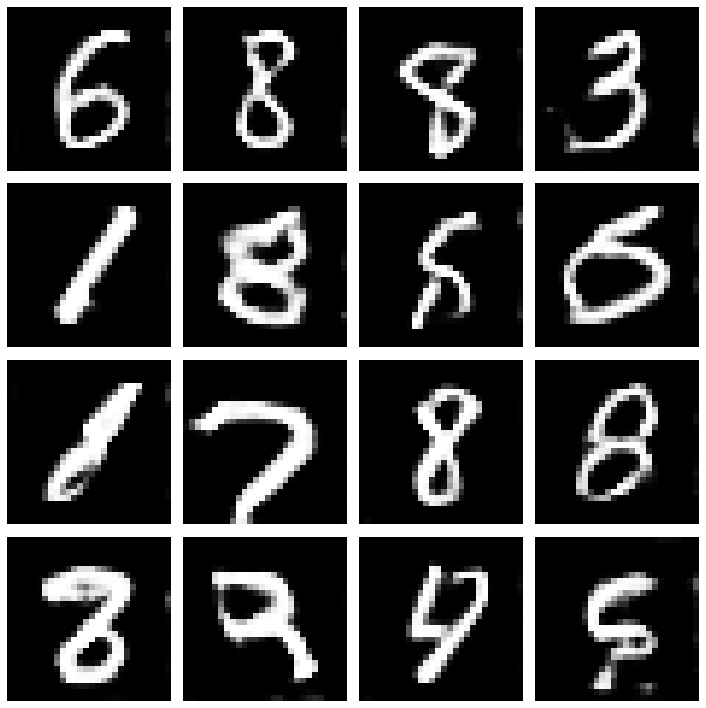

3999: [D loss: 0.677183, acc: 0.585938]  [A loss: 0.924815, acc: 0.156250]


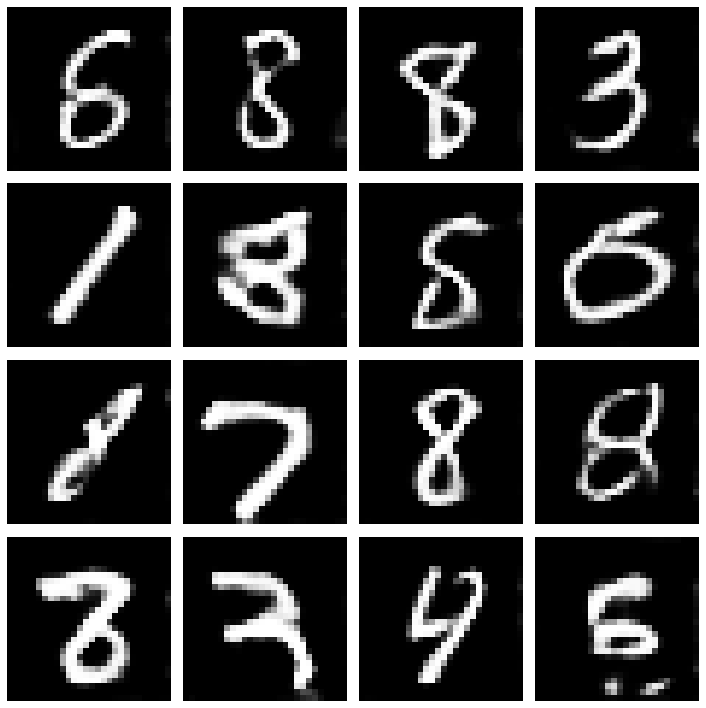

4499: [D loss: 0.672827, acc: 0.585938]  [A loss: 0.804848, acc: 0.320312]


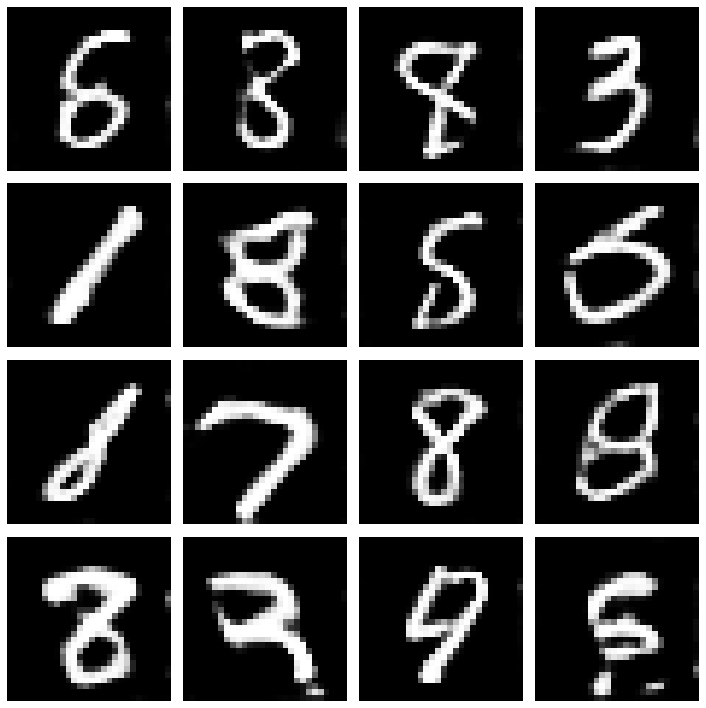

4999: [D loss: 0.682367, acc: 0.578125]  [A loss: 0.869619, acc: 0.242188]


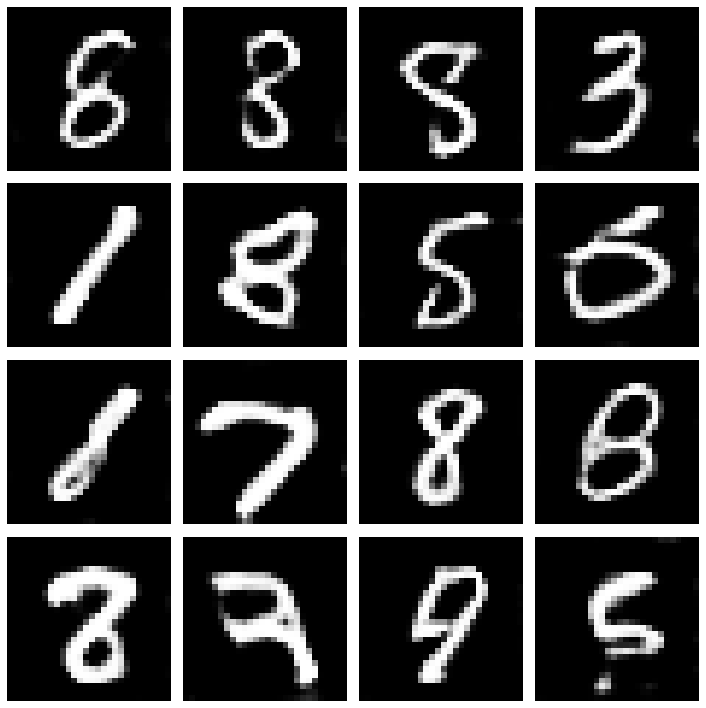

5499: [D loss: 0.660541, acc: 0.595703]  [A loss: 0.805367, acc: 0.332031]


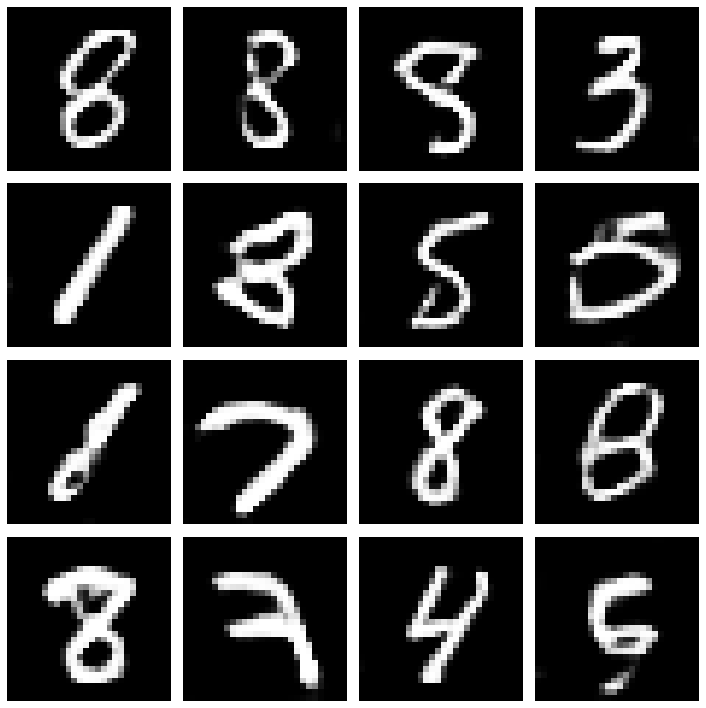

5999: [D loss: 0.661464, acc: 0.597656]  [A loss: 0.817887, acc: 0.332031]


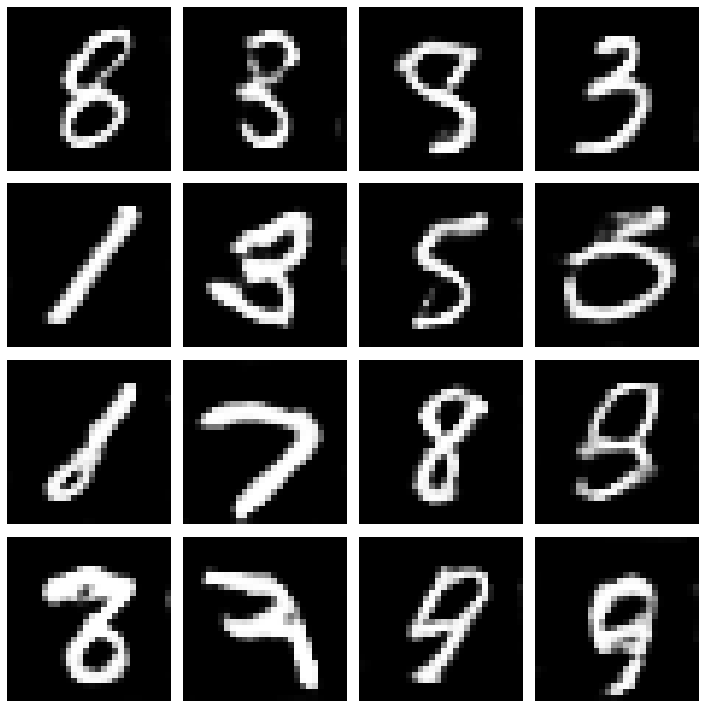

6499: [D loss: 0.678134, acc: 0.582031]  [A loss: 0.906424, acc: 0.195312]


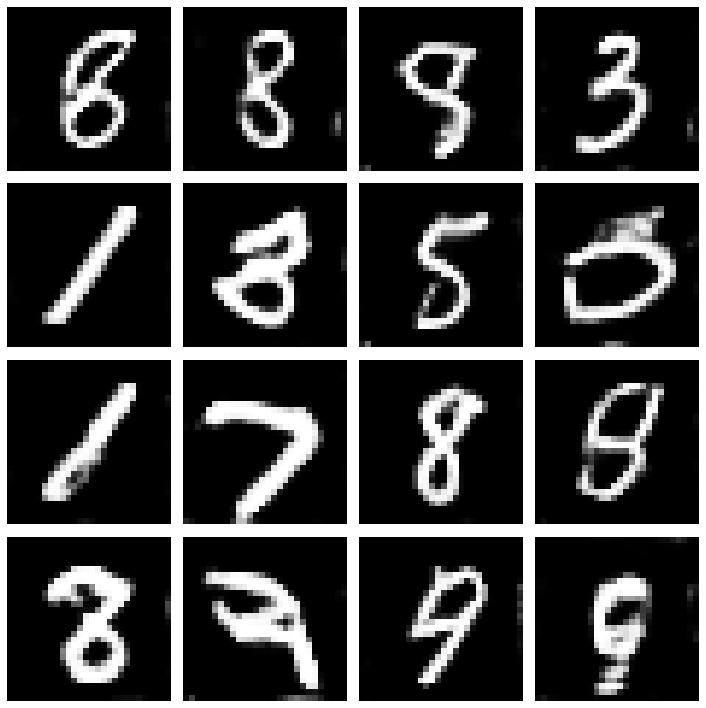

6999: [D loss: 0.653008, acc: 0.621094]  [A loss: 0.789561, acc: 0.386719]


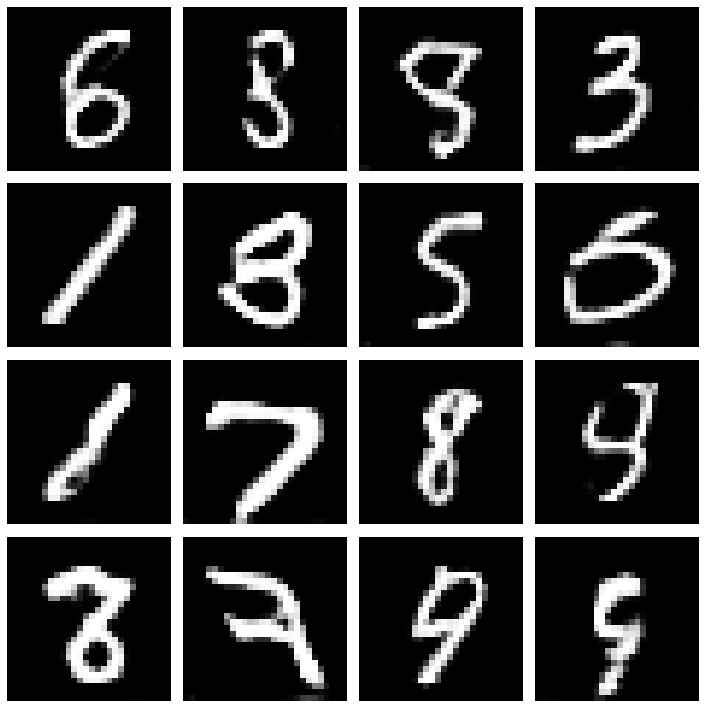

7499: [D loss: 0.652317, acc: 0.615234]  [A loss: 0.819623, acc: 0.308594]


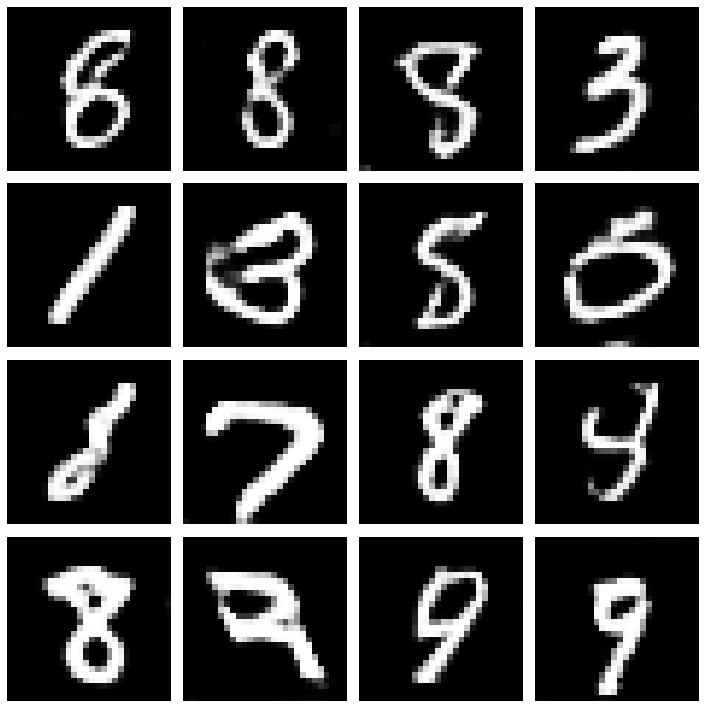

7999: [D loss: 0.649202, acc: 0.613281]  [A loss: 0.709180, acc: 0.523438]


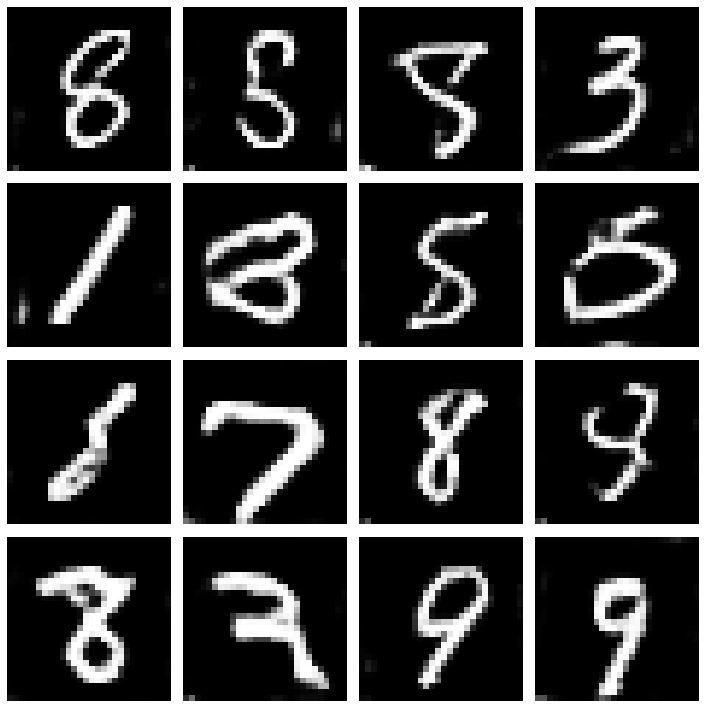

8499: [D loss: 0.653137, acc: 0.607422]  [A loss: 0.799730, acc: 0.390625]


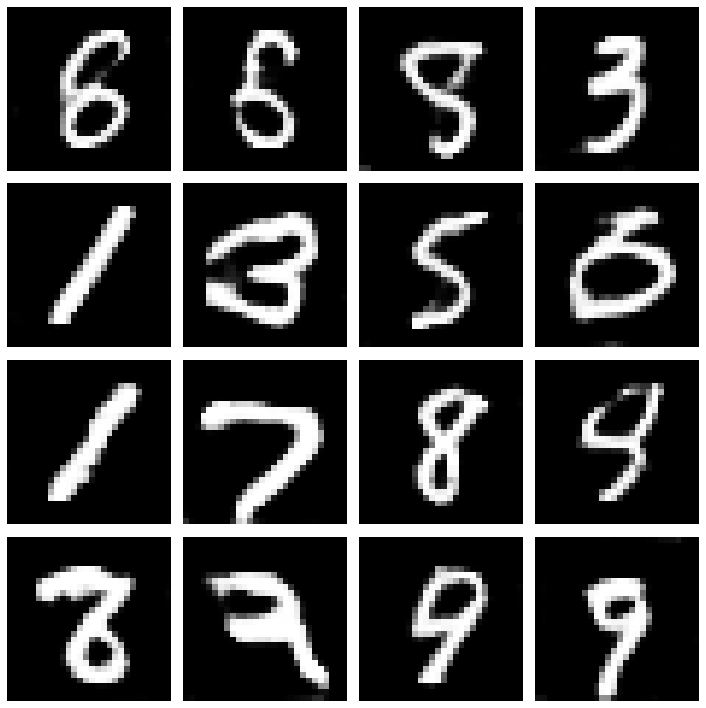

8999: [D loss: 0.659340, acc: 0.617188]  [A loss: 0.782279, acc: 0.394531]


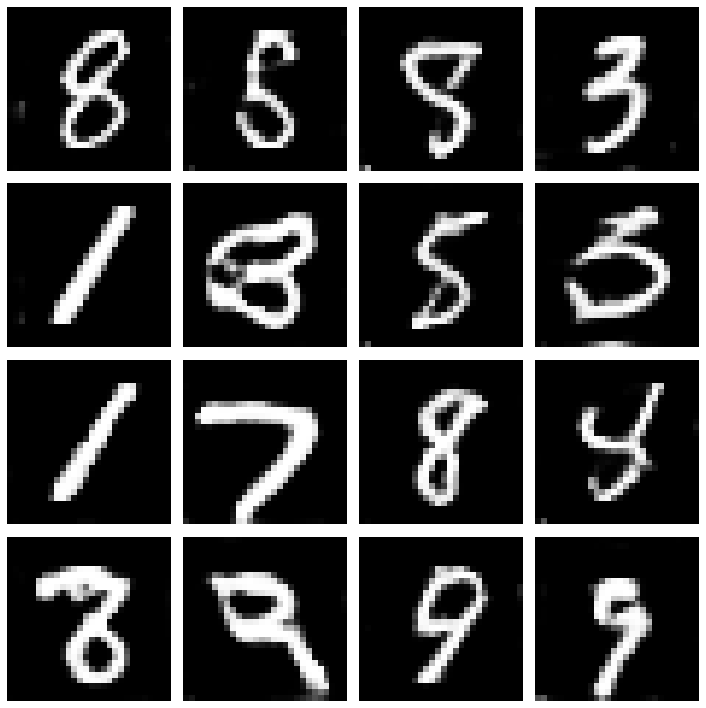

9499: [D loss: 0.669978, acc: 0.609375]  [A loss: 0.833958, acc: 0.316406]


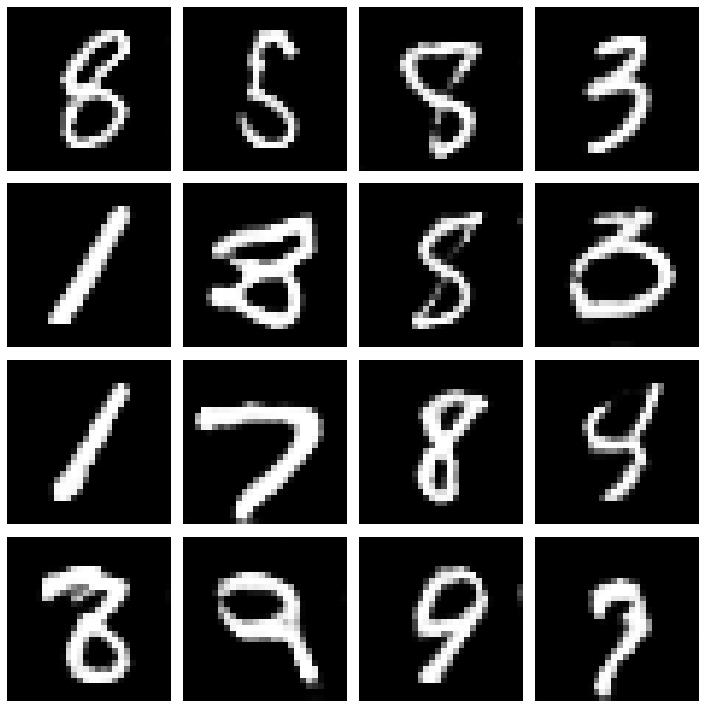

9999: [D loss: 0.674146, acc: 0.580078]  [A loss: 0.882413, acc: 0.210938]


In [ ]:
model.train(train_steps=10000, batch_size=256, save_interval=500)